In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

/Users/1233day/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import logging

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [4]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [5]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [6]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [7]:
nan_col_list = ['착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', 'PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [8]:
# NEW: 착상 전 유전 검사/진단 관련 변수와 실제 시술 여부를 합쳐서 새로운 특성 생성
train['PGS'] = train['착상 전 유전 검사 사용 여부'].astype(int) + train['PGS 시술 여부'].astype(int)
test['PGS'] = test['착상 전 유전 검사 사용 여부'].astype(int) + test['PGS 시술 여부'].astype(int)

train['PGD'] = train['착상 전 유전 진단 사용 여부'].astype(int) + train['PGD 시술 여부'].astype(int)
test['PGD'] = test['착상 전 유전 진단 사용 여부'].astype(int) + test['PGD 시술 여부'].astype(int)

In [9]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [10]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 66), (90067, 65))

In [11]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [12]:
# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
    bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
    labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
    train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
    test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=100)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=100)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [13]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [14]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [15]:
# train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
# test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )

In [16]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
       '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부', 'PGS',
       'PGD', '임신시도_bin', '총_생성_배아_bin', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',
       '남성 불임 원인', '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [17]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', '총_생성_배아_bin','PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인',"임신시도_bin"] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

# DI 시술인 경우, 배아 관련 수치형 변수에 대해 결측치를 0으로 보간
embryo_cols = ["이식된 배아 수", "미세주입 배아 이식 수", "배아 이식 경과일", "배아 해동 경과일",
               "미세주입에서 생성된 배아 수", "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수"]
di_mask_train = train["시술 유형"] == "DI"
di_mask_test = test["시술 유형"] == "DI"
for col in embryo_cols:
    if col in train.columns:
        train.loc[di_mask_train, col] = train.loc[di_mask_train, col].fillna(0)
    if col in test.columns:
        test.loc[di_mask_test, col] = test.loc[di_mask_test, col].fillna(0)

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [18]:
len(categorical_columns) + len(numeric_columns)

59

In [19]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [20]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 69), (90067, 69))

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 수치형 변수(정수, 실수)를 선택하여 스케일링
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

X.shape, test.shape

((256351, 69), (90067, 69))

In [22]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [23]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [24]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [25]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 40)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_cpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="cpu" )
    # model_cpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_cpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-26 03:52:28,359] A new study created in memory with name: no-name-7fa82798-b555-4262-9a23-231d1ae98002


Seed 4972 Start!
0:	test: 0.7261107	best: 0.7261107 (0)	total: 180ms	remaining: 7m 5s
300:	test: 0.7384885	best: 0.7384885 (300)	total: 36.7s	remaining: 4m 11s
600:	test: 0.7399102	best: 0.7399256 (597)	total: 1m 17s	remaining: 3m 47s
900:	test: 0.7403351	best: 0.7403364 (898)	total: 1m 58s	remaining: 3m 13s
1200:	test: 0.7405525	best: 0.7405525 (1200)	total: 2m 43s	remaining: 2m 38s
1500:	test: 0.7406340	best: 0.7406359 (1470)	total: 3m 36s	remaining: 2m 4s
1800:	test: 0.7406766	best: 0.7406832 (1780)	total: 4m 27s	remaining: 1m 24s
2100:	test: 0.7405870	best: 0.7407132 (1822)	total: 5m 18s	remaining: 40.2s


[I 2025-02-26 03:57:51,502] Trial 0 finished with value: 0.7407131514449148 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7407131514449148.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407131514
bestIteration = 1822

Shrink model to first 1823 iterations.
저장 완료
0:	test: 0.6974265	best: 0.6974265 (0)	total: 50.8ms	remaining: 1m 51s
300:	test: 0.7314086	best: 0.7314086 (300)	total: 13.3s	remaining: 1m 23s
600:	test: 0.7344263	best: 0.7344263 (600)	total: 26.6s	remaining: 1m 10s
900:	test: 0.7363576	best: 0.7363576 (900)	total: 40.8s	remaining: 58.5s
1200:	test: 0.7373284	best: 0.7373284 (1200)	total: 54.9s	remaining: 45.4s
1500:	test: 0.7379812	best: 0.7379820 (1499)	total: 1m 9s	remaining: 32.1s
1800:	test: 0.7384519	best: 0.7384519 (1800)	total: 1m 24s	remaining: 18.3s
2100:	test: 0.7388409	best: 0.7388409 (2100)	total: 1m 38s	remaining: 4.31s


[I 2025-02-26 03:59:34,804] Trial 1 finished with value: 0.7389633136331881 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7407131514449148.


2192:	test: 0.7389610	best: 0.7389633 (2188)	total: 1m 42s	remaining: 0us

bestTest = 0.7389633136
bestIteration = 2188

Shrink model to first 2189 iterations.
0:	test: 0.6974265	best: 0.6974265 (0)	total: 57.5ms	remaining: 2m 25s
300:	test: 0.7401623	best: 0.7401623 (300)	total: 15.3s	remaining: 1m 53s
600:	test: 0.7401827	best: 0.7404520 (569)	total: 31.5s	remaining: 1m 41s


[I 2025-02-26 04:00:20,677] Trial 2 finished with value: 0.740451980140673 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7407131514449148.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404519801
bestIteration = 569

Shrink model to first 570 iterations.
0:	test: 0.6974265	best: 0.6974265 (0)	total: 50.3ms	remaining: 1m 57s
300:	test: 0.7391020	best: 0.7391364 (299)	total: 14.4s	remaining: 1m 37s
600:	test: 0.7399175	best: 0.7399414 (576)	total: 29.1s	remaining: 1m 23s


[I 2025-02-26 04:01:03,505] Trial 3 finished with value: 0.7399414264733113 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7407131514449148.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7399414265
bestIteration = 576

Shrink model to first 577 iterations.
0:	test: 0.7259911	best: 0.7259911 (0)	total: 115ms	remaining: 3m 20s
300:	test: 0.7377098	best: 0.7377708 (298)	total: 36.6s	remaining: 2m 55s
600:	test: 0.7386934	best: 0.7386982 (596)	total: 1m 16s	remaining: 2m 24s
900:	test: 0.7385962	best: 0.7387269 (609)	total: 1m 55s	remaining: 1m 47s


[I 2025-02-26 04:03:00,379] Trial 4 finished with value: 0.7387269392091438 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7407131514449148.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387269392
bestIteration = 609

Shrink model to first 610 iterations.
0:	test: 0.6974265	best: 0.6974265 (0)	total: 48.3ms	remaining: 1m 40s
300:	test: 0.7402149	best: 0.7402404 (295)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7407619	best: 0.7408000 (497)	total: 28.9s	remaining: 1m 11s
900:	test: 0.7406922	best: 0.7408208 (693)	total: 44s	remaining: 57.7s


[I 2025-02-26 04:03:49,286] Trial 5 finished with value: 0.7408207845964783 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.7408207845964783.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408207846
bestIteration = 693

Shrink model to first 694 iterations.
저장 완료
0:	test: 0.7184700	best: 0.7184700 (0)	total: 59.3ms	remaining: 1m 58s
300:	test: 0.7403560	best: 0.7403700 (299)	total: 17.4s	remaining: 1m 37s
600:	test: 0.7408524	best: 0.7408687 (562)	total: 35.1s	remaining: 1m 21s
900:	test: 0.7407904	best: 0.7409252 (693)	total: 53.3s	remaining: 1m 4s


[I 2025-02-26 04:04:48,473] Trial 6 finished with value: 0.7409252292941106 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7409252292941106.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409252293
bestIteration = 693

Shrink model to first 694 iterations.
저장 완료
0:	test: 0.7231231	best: 0.7231231 (0)	total: 74.4ms	remaining: 2m 23s
300:	test: 0.7392042	best: 0.7402738 (152)	total: 24s	remaining: 2m 9s


[I 2025-02-26 04:05:25,496] Trial 7 finished with value: 0.7402738079055694 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7409252292941106.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402738079
bestIteration = 152

Shrink model to first 153 iterations.
0:	test: 0.7231225	best: 0.7231225 (0)	total: 76.6ms	remaining: 2m 25s
300:	test: 0.7409809	best: 0.7409902 (297)	total: 22.8s	remaining: 2m 1s
600:	test: 0.7410319	best: 0.7411737 (393)	total: 47.9s	remaining: 1m 43s


[I 2025-02-26 04:06:21,362] Trial 8 finished with value: 0.7411736785480478 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7411736785480478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411736785
bestIteration = 393

Shrink model to first 394 iterations.
저장 완료
0:	test: 0.7227409	best: 0.7227409 (0)	total: 66.3ms	remaining: 2m 54s
300:	test: 0.7398133	best: 0.7398169 (299)	total: 19.5s	remaining: 2m 31s
600:	test: 0.7407357	best: 0.7407774 (468)	total: 41s	remaining: 2m 18s
900:	test: 0.7406764	best: 0.7407840 (613)	total: 1m 2s	remaining: 2m


[I 2025-02-26 04:07:25,032] Trial 9 finished with value: 0.7407839605345163 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7411736785480478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407839605
bestIteration = 613

Shrink model to first 614 iterations.
0:	test: 0.7228991	best: 0.7228991 (0)	total: 83.6ms	remaining: 4m 5s
300:	test: 0.7399597	best: 0.7399787 (293)	total: 26.8s	remaining: 3m 55s
600:	test: 0.7402582	best: 0.7404333 (419)	total: 55.5s	remaining: 3m 36s


[I 2025-02-26 04:08:32,182] Trial 10 finished with value: 0.7404332981036307 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7411736785480478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404332981
bestIteration = 419

Shrink model to first 420 iterations.
0:	test: 0.7227142	best: 0.7227142 (0)	total: 65ms	remaining: 1m 46s
300:	test: 0.7405258	best: 0.7405350 (295)	total: 19.8s	remaining: 1m 28s
600:	test: 0.7412934	best: 0.7412935 (598)	total: 40.9s	remaining: 1m 11s
900:	test: 0.7411413	best: 0.7413065 (603)	total: 1m 2s	remaining: 51.6s


[I 2025-02-26 04:09:35,091] Trial 11 finished with value: 0.7413064500580628 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7413064500580628.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413064501
bestIteration = 603

Shrink model to first 604 iterations.
저장 완료
0:	test: 0.7231143	best: 0.7231143 (0)	total: 75.4ms	remaining: 1m 57s
300:	test: 0.7411462	best: 0.7411551 (298)	total: 23.3s	remaining: 1m 36s
600:	test: 0.7408553	best: 0.7411965 (318)	total: 48.4s	remaining: 1m 16s


[I 2025-02-26 04:10:25,211] Trial 12 finished with value: 0.741196525825655 and parameters: {'iterations': 1553, 'depth': 7, 'learning_rate': 0.06294305307719734, 'l2_leaf_reg': 6.4688552126590215}. Best is trial 11 with value: 0.7413064500580628.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411965258
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.7233671	best: 0.7233671 (0)	total: 85.6ms	remaining: 2m 16s
300:	test: 0.7411193	best: 0.7411242 (299)	total: 26.1s	remaining: 1m 51s
600:	test: 0.7409728	best: 0.7412098 (392)	total: 54.1s	remaining: 1m 29s


[I 2025-02-26 04:11:28,132] Trial 13 finished with value: 0.741209772005373 and parameters: {'iterations': 1594, 'depth': 8, 'learning_rate': 0.06681053374964743, 'l2_leaf_reg': 55.074044317639256}. Best is trial 11 with value: 0.7413064500580628.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741209772
bestIteration = 392

Shrink model to first 393 iterations.
0:	test: 0.7263992	best: 0.7263992 (0)	total: 98.7ms	remaining: 2m 31s
300:	test: 0.7409131	best: 0.7409131 (300)	total: 29.4s	remaining: 2m
600:	test: 0.7412221	best: 0.7412394 (537)	total: 1m 1s	remaining: 1m 35s


[I 2025-02-26 04:12:55,434] Trial 14 finished with value: 0.741239381346547 and parameters: {'iterations': 1533, 'depth': 9, 'learning_rate': 0.07625472087012396, 'l2_leaf_reg': 92.74223128282539}. Best is trial 11 with value: 0.7413064500580628.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412393813
bestIteration = 537

Shrink model to first 538 iterations.
0:	test: 0.7256950	best: 0.7256950 (0)	total: 99.9ms	remaining: 2m 54s
300:	test: 0.7371922	best: 0.7392820 (108)	total: 31.5s	remaining: 2m 31s


[I 2025-02-26 04:13:39,716] Trial 15 finished with value: 0.7392819803457982 and parameters: {'iterations': 1748, 'depth': 9, 'learning_rate': 0.08145815028551073, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7413064500580628.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392819803
bestIteration = 108

Shrink model to first 109 iterations.
0:	test: 0.7227377	best: 0.7227377 (0)	total: 71.3ms	remaining: 1m 47s
300:	test: 0.7405492	best: 0.7405695 (282)	total: 20.9s	remaining: 1m 24s
600:	test: 0.7406385	best: 0.7408117 (436)	total: 43.5s	remaining: 1m 5s


[I 2025-02-26 04:14:33,309] Trial 16 finished with value: 0.7408116798332608 and parameters: {'iterations': 1512, 'depth': 6, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 11.7175383678352}. Best is trial 11 with value: 0.7413064500580628.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408116798
bestIteration = 436

Shrink model to first 437 iterations.
0:	test: 0.7263599	best: 0.7263599 (0)	total: 109ms	remaining: 3m 13s
300:	test: 0.7410704	best: 0.7411262 (272)	total: 28.8s	remaining: 2m 20s
600:	test: 0.7413253	best: 0.7413480 (575)	total: 1m	remaining: 1m 57s
900:	test: 0.7414890	best: 0.7415054 (891)	total: 1m 33s	remaining: 1m 29s
1200:	test: 0.7411319	best: 0.7415389 (926)	total: 2m 6s	remaining: 59.8s


[I 2025-02-26 04:16:42,610] Trial 17 finished with value: 0.7415388657167657 and parameters: {'iterations': 1770, 'depth': 9, 'learning_rate': 0.05957423506379656, 'l2_leaf_reg': 78.95541377765753}. Best is trial 17 with value: 0.7415388657167657.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415388657
bestIteration = 926

Shrink model to first 927 iterations.
저장 완료
0:	test: 0.7227409	best: 0.7227409 (0)	total: 69.8ms	remaining: 2m 4s
300:	test: 0.7403801	best: 0.7404290 (283)	total: 20.1s	remaining: 1m 38s
600:	test: 0.7398922	best: 0.7405429 (358)	total: 41.8s	remaining: 1m 22s


[I 2025-02-26 04:17:28,779] Trial 18 finished with value: 0.7405429046818488 and parameters: {'iterations': 1785, 'depth': 6, 'learning_rate': 0.058873001052268344, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 17 with value: 0.7415388657167657.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405429047
bestIteration = 358

Shrink model to first 359 iterations.
0:	test: 0.7229013	best: 0.7229013 (0)	total: 86.7ms	remaining: 2m 27s
300:	test: 0.7401900	best: 0.7402116 (293)	total: 25.1s	remaining: 1m 56s
600:	test: 0.7410353	best: 0.7410487 (589)	total: 52.6s	remaining: 1m 36s


[I 2025-02-26 04:18:49,389] Trial 19 finished with value: 0.7410486538295885 and parameters: {'iterations': 1703, 'depth': 8, 'learning_rate': 0.0277707300774159, 'l2_leaf_reg': 2.276175005448344}. Best is trial 17 with value: 0.7415388657167657.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410486538
bestIteration = 589

Shrink model to first 590 iterations.
0:	test: 0.7256956	best: 0.7256956 (0)	total: 97.2ms	remaining: 3m 31s
300:	test: 0.7402730	best: 0.7406600 (262)	total: 30.2s	remaining: 3m 8s


[I 2025-02-26 04:19:49,361] Trial 20 finished with value: 0.7406599523094647 and parameters: {'iterations': 2176, 'depth': 9, 'learning_rate': 0.05377174904568589, 'l2_leaf_reg': 0.21530549345097366}. Best is trial 17 with value: 0.7415388657167657.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406599523
bestIteration = 262

Shrink model to first 263 iterations.
0:	test: 0.7263900	best: 0.7263900 (0)	total: 98ms	remaining: 2m 40s
300:	test: 0.7410498	best: 0.7410498 (300)	total: 29.1s	remaining: 2m 8s
600:	test: 0.7411279	best: 0.7411644 (396)	total: 1m	remaining: 1m 43s


[I 2025-02-26 04:21:00,453] Trial 21 finished with value: 0.7411644427524771 and parameters: {'iterations': 1633, 'depth': 9, 'learning_rate': 0.0710058041641237, 'l2_leaf_reg': 89.82044496900683}. Best is trial 17 with value: 0.7415388657167657.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411644428
bestIteration = 396

Shrink model to first 397 iterations.
0:	test: 0.7260081	best: 0.7260081 (0)	total: 113ms	remaining: 3m 26s
300:	test: 0.7404654	best: 0.7406662 (151)	total: 42.8s	remaining: 3m 37s


[I 2025-02-26 04:22:08,444] Trial 22 finished with value: 0.7406662378917469 and parameters: {'iterations': 1829, 'depth': 10, 'learning_rate': 0.07683644220861759, 'l2_leaf_reg': 24.680291204055877}. Best is trial 17 with value: 0.7415388657167657.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406662379
bestIteration = 151

Shrink model to first 152 iterations.
0:	test: 0.7257164	best: 0.7257164 (0)	total: 96.5ms	remaining: 2m 26s
300:	test: 0.7397232	best: 0.7405941 (191)	total: 31.4s	remaining: 2m 7s


[I 2025-02-26 04:23:01,646] Trial 23 finished with value: 0.740594074801161 and parameters: {'iterations': 1519, 'depth': 9, 'learning_rate': 0.09917245719790296, 'l2_leaf_reg': 3.642784304542385}. Best is trial 17 with value: 0.7415388657167657.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405940748
bestIteration = 191

Shrink model to first 192 iterations.
0:	test: 0.7184700	best: 0.7184700 (0)	total: 57.8ms	remaining: 1m 35s
300:	test: 0.7406367	best: 0.7406375 (299)	total: 17.4s	remaining: 1m 18s
600:	test: 0.7410164	best: 0.7410811 (571)	total: 35.6s	remaining: 1m 2s


[I 2025-02-26 04:23:53,895] Trial 24 finished with value: 0.7410810982344074 and parameters: {'iterations': 1652, 'depth': 5, 'learning_rate': 0.08835432897692846, 'l2_leaf_reg': 20.351730335262328}. Best is trial 17 with value: 0.7415388657167657.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410810982
bestIteration = 571

Shrink model to first 572 iterations.
0:	test: 0.7233481	best: 0.7233481 (0)	total: 83.7ms	remaining: 2m 42s
300:	test: 0.7410627	best: 0.7410837 (288)	total: 25.4s	remaining: 2m 18s
600:	test: 0.7415437	best: 0.7415792 (578)	total: 52.6s	remaining: 1m 57s
900:	test: 0.7417181	best: 0.7417312 (838)	total: 1m 20s	remaining: 1m 32s


[I 2025-02-26 04:25:36,995] Trial 25 finished with value: 0.741731173563319 and parameters: {'iterations': 1939, 'depth': 8, 'learning_rate': 0.0585413592189865, 'l2_leaf_reg': 97.06988244153742}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417311736
bestIteration = 838

Shrink model to first 839 iterations.
저장 완료
0:	test: 0.7228751	best: 0.7228751 (0)	total: 84.6ms	remaining: 2m 50s
300:	test: 0.7406973	best: 0.7407801 (281)	total: 25.5s	remaining: 2m 25s
600:	test: 0.7407258	best: 0.7408638 (423)	total: 54s	remaining: 2m 7s


[I 2025-02-26 04:26:42,853] Trial 26 finished with value: 0.7408637790910784 and parameters: {'iterations': 2017, 'depth': 8, 'learning_rate': 0.05911612120675688, 'l2_leaf_reg': 25.80988384156663}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408637791
bestIteration = 423

Shrink model to first 424 iterations.
0:	test: 0.7184653	best: 0.7184653 (0)	total: 59.3ms	remaining: 1m 52s
300:	test: 0.7399103	best: 0.7399210 (299)	total: 17s	remaining: 1m 30s
600:	test: 0.7407453	best: 0.7407685 (551)	total: 35.3s	remaining: 1m 16s
900:	test: 0.7407452	best: 0.7408875 (731)	total: 53.7s	remaining: 59.1s


[I 2025-02-26 04:27:44,704] Trial 27 finished with value: 0.7408874760936435 and parameters: {'iterations': 1894, 'depth': 5, 'learning_rate': 0.044350966577311385, 'l2_leaf_reg': 4.874260466396494}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408874761
bestIteration = 731

Shrink model to first 732 iterations.
0:	test: 0.7228756	best: 0.7228756 (0)	total: 85ms	remaining: 2m 57s
300:	test: 0.7409360	best: 0.7409573 (296)	total: 25.5s	remaining: 2m 31s
600:	test: 0.7411958	best: 0.7412306 (496)	total: 53.7s	remaining: 2m 12s
900:	test: 0.7411727	best: 0.7412942 (677)	total: 1m 22s	remaining: 1m 48s


[I 2025-02-26 04:29:14,794] Trial 28 finished with value: 0.7412942203717525 and parameters: {'iterations': 2086, 'depth': 8, 'learning_rate': 0.053889886512538794, 'l2_leaf_reg': 32.64406506276567}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412942204
bestIteration = 677

Shrink model to first 678 iterations.
0:	test: 0.7261054	best: 0.7261054 (0)	total: 115ms	remaining: 3m 33s
300:	test: 0.7404282	best: 0.7404559 (295)	total: 38.4s	remaining: 3m 18s
600:	test: 0.7403899	best: 0.7407361 (423)	total: 1m 26s	remaining: 2m 59s


[I 2025-02-26 04:31:01,186] Trial 29 finished with value: 0.7407360821067468 and parameters: {'iterations': 1854, 'depth': 10, 'learning_rate': 0.03619148014508946, 'l2_leaf_reg': 9.517683989895504}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407360821
bestIteration = 423

Shrink model to first 424 iterations.
0:	test: 0.7231230	best: 0.7231230 (0)	total: 73.9ms	remaining: 2m 50s
300:	test: 0.7395592	best: 0.7395592 (300)	total: 22s	remaining: 2m 26s
600:	test: 0.7405926	best: 0.7406456 (542)	total: 46s	remaining: 2m 10s
900:	test: 0.7408276	best: 0.7409125 (805)	total: 1m 11s	remaining: 1m 51s


[I 2025-02-26 04:32:29,866] Trial 30 finished with value: 0.7409125191558381 and parameters: {'iterations': 2309, 'depth': 7, 'learning_rate': 0.025793422522118456, 'l2_leaf_reg': 0.625022210787573}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409125192
bestIteration = 805

Shrink model to first 806 iterations.
0:	test: 0.7228756	best: 0.7228756 (0)	total: 86.5ms	remaining: 3m
300:	test: 0.7408113	best: 0.7408604 (283)	total: 25.1s	remaining: 2m 28s
600:	test: 0.7411146	best: 0.7411647 (578)	total: 53.5s	remaining: 2m 12s
900:	test: 0.7409394	best: 0.7412099 (647)	total: 1m 22s	remaining: 1m 47s


[I 2025-02-26 04:33:56,583] Trial 31 finished with value: 0.7412098752429845 and parameters: {'iterations': 2087, 'depth': 8, 'learning_rate': 0.05171744712438518, 'l2_leaf_reg': 29.78600658391369}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412098752
bestIteration = 647

Shrink model to first 648 iterations.
0:	test: 0.7230758	best: 0.7230758 (0)	total: 110ms	remaining: 3m 59s
300:	test: 0.7409432	best: 0.7409505 (291)	total: 22.4s	remaining: 2m 20s
600:	test: 0.7409575	best: 0.7411136 (442)	total: 46.9s	remaining: 2m 3s


[I 2025-02-26 04:34:55,713] Trial 32 finished with value: 0.7411136180820963 and parameters: {'iterations': 2183, 'depth': 7, 'learning_rate': 0.06142559113711136, 'l2_leaf_reg': 45.59641996124068}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411136181
bestIteration = 442

Shrink model to first 443 iterations.
0:	test: 0.7228994	best: 0.7228994 (0)	total: 85.3ms	remaining: 3m 30s
300:	test: 0.7407409	best: 0.7408084 (231)	total: 26.5s	remaining: 3m 10s
600:	test: 0.7405052	best: 0.7408699 (453)	total: 55.2s	remaining: 2m 51s


[I 2025-02-26 04:36:06,120] Trial 33 finished with value: 0.7408698542274599 and parameters: {'iterations': 2466, 'depth': 8, 'learning_rate': 0.067379598842976, 'l2_leaf_reg': 10.260474747835069}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408698542
bestIteration = 453

Shrink model to first 454 iterations.
0:	test: 0.7227365	best: 0.7227365 (0)	total: 66.2ms	remaining: 2m 10s
300:	test: 0.7402986	best: 0.7403398 (287)	total: 20.2s	remaining: 1m 51s
600:	test: 0.7405899	best: 0.7406573 (554)	total: 41.6s	remaining: 1m 34s
900:	test: 0.7407376	best: 0.7408116 (818)	total: 1m 3s	remaining: 1m 15s


[I 2025-02-26 04:37:25,399] Trial 34 finished with value: 0.7408115646836169 and parameters: {'iterations': 1971, 'depth': 6, 'learning_rate': 0.05500693662846034, 'l2_leaf_reg': 17.995642850287346}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408115647
bestIteration = 818

Shrink model to first 819 iterations.
0:	test: 0.7263847	best: 0.7263847 (0)	total: 97.2ms	remaining: 3m 21s
300:	test: 0.7411324	best: 0.7411324 (300)	total: 27.4s	remaining: 2m 41s
600:	test: 0.7413966	best: 0.7414466 (541)	total: 59s	remaining: 2m 25s
900:	test: 0.7413793	best: 0.7414965 (623)	total: 1m 30s	remaining: 1m 58s


[I 2025-02-26 04:38:59,051] Trial 35 finished with value: 0.7414964588824168 and parameters: {'iterations': 2079, 'depth': 9, 'learning_rate': 0.045828044236086184, 'l2_leaf_reg': 88.68128932305085}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414964589
bestIteration = 623

Shrink model to first 624 iterations.
0:	test: 0.7281921	best: 0.7281921 (0)	total: 113ms	remaining: 3m 11s
300:	test: 0.7409201	best: 0.7409213 (297)	total: 36.2s	remaining: 2m 47s
600:	test: 0.7413368	best: 0.7413480 (569)	total: 1m 29s	remaining: 2m 42s
900:	test: 0.7413317	best: 0.7413563 (630)	total: 2m 22s	remaining: 2m 5s


[I 2025-02-26 04:41:27,048] Trial 36 finished with value: 0.7413563297072288 and parameters: {'iterations': 1692, 'depth': 10, 'learning_rate': 0.04545128870925985, 'l2_leaf_reg': 88.38546543343872}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413563297
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.7260806	best: 0.7260806 (0)	total: 115ms	remaining: 4m 17s
300:	test: 0.7404737	best: 0.7404737 (300)	total: 39.7s	remaining: 4m 17s
600:	test: 0.7396469	best: 0.7404948 (316)	total: 1m 27s	remaining: 4m 1s


[I 2025-02-26 04:42:57,548] Trial 37 finished with value: 0.7404947800720819 and parameters: {'iterations': 2253, 'depth': 10, 'learning_rate': 0.04414727830832546, 'l2_leaf_reg': 2.8607577901764403}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404947801
bestIteration = 316

Shrink model to first 317 iterations.
0:	test: 0.7260985	best: 0.7260985 (0)	total: 119ms	remaining: 3m 33s
300:	test: 0.7411441	best: 0.7412045 (289)	total: 38.9s	remaining: 3m 12s
600:	test: 0.7410798	best: 0.7413112 (477)	total: 1m 29s	remaining: 2m 56s


[I 2025-02-26 04:44:56,454] Trial 38 finished with value: 0.7413111751641372 and parameters: {'iterations': 1790, 'depth': 10, 'learning_rate': 0.047579677210492534, 'l2_leaf_reg': 13.046060594193479}. Best is trial 25 with value: 0.741731173563319.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413111752
bestIteration = 477

Shrink model to first 478 iterations.
0:	test: 0.7263356	best: 0.7263356 (0)	total: 96.3ms	remaining: 3m 16s
300:	test: 0.7397934	best: 0.7397934 (300)	total: 28.8s	remaining: 2m 46s
600:	test: 0.7408194	best: 0.7408420 (588)	total: 55.3s	remaining: 2m 12s
900:	test: 0.7411510	best: 0.7411541 (899)	total: 1m 24s	remaining: 1m 47s
1200:	test: 0.7412691	best: 0.7412865 (1141)	total: 1m 57s	remaining: 1m 21s
1500:	test: 0.7411908	best: 0.7412904 (1346)	total: 2m 29s	remaining: 53.7s


[I 2025-02-26 04:47:42,013] Trial 39 finished with value: 0.7412904363162155 and parameters: {'iterations': 2041, 'depth': 9, 'learning_rate': 0.01785460005303149, 'l2_leaf_reg': 44.31770982826353}. Best is trial 25 with value: 0.741731173563319.
[I 2025-02-26 04:47:42,018] A new study created in memory with name: no-name-2cf12535-d64f-45d6-9402-7a5e38b646da


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412904363
bestIteration = 1346

Shrink model to first 1347 iterations.


[I 2025-02-26 04:48:05,032] Trial 0 finished with value: 0.7314105333446408 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7314105333446408.
[I 2025-02-26 04:48:21,952] Trial 1 finished with value: 0.7408724589918169 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7408724589918169.
[I 2025-02-26 04:48:41,524] Trial 2 finished with value: 0.7400724230905403 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.741731173563319
LGBM val score : 0.7410889919410257
Ensemble val score : 0.7417856909636571


[I 2025-02-26 05:00:42,027] A new study created in memory with name: no-name-5ce6d263-647f-4c5d-b468-6834d6d21ffa


0:	test: 0.7179764	best: 0.7179764 (0)	total: 147ms	remaining: 5m 48s
300:	test: 0.7331414	best: 0.7331414 (300)	total: 37.5s	remaining: 4m 17s
600:	test: 0.7344557	best: 0.7344761 (591)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7347818	best: 0.7347834 (895)	total: 1m 58s	remaining: 3m 12s
1200:	test: 0.7349507	best: 0.7349598 (1191)	total: 2m 42s	remaining: 2m 37s
1500:	test: 0.7350701	best: 0.7350726 (1496)	total: 3m 31s	remaining: 2m 1s
1800:	test: 0.7351307	best: 0.7351504 (1751)	total: 4m 20s	remaining: 1m 21s


[I 2025-02-26 05:05:44,740] Trial 0 finished with value: 0.7351504144194335 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7351504144194335.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351504144
bestIteration = 1751

Shrink model to first 1752 iterations.
저장 완료
0:	test: 0.6897966	best: 0.6897966 (0)	total: 58.8ms	remaining: 2m 8s
300:	test: 0.7243491	best: 0.7243491 (300)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7282964	best: 0.7282964 (600)	total: 26.1s	remaining: 1m 9s
900:	test: 0.7304622	best: 0.7304622 (900)	total: 39.5s	remaining: 56.7s
1200:	test: 0.7316761	best: 0.7316761 (1200)	total: 53.2s	remaining: 44s
1500:	test: 0.7323861	best: 0.7323861 (1500)	total: 1m 7s	remaining: 30.9s
1800:	test: 0.7328505	best: 0.7328505 (1800)	total: 1m 21s	remaining: 17.7s
2100:	test: 0.7332397	best: 0.7332400 (2096)	total: 1m 35s	remaining: 4.17s


[I 2025-02-26 05:07:24,830] Trial 1 finished with value: 0.7333776204848507 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7351504144194335.


2192:	test: 0.7333767	best: 0.7333776 (2191)	total: 1m 39s	remaining: 0us

bestTest = 0.7333776205
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6897966	best: 0.6897966 (0)	total: 50.5ms	remaining: 2m 7s
300:	test: 0.7341711	best: 0.7342050 (291)	total: 14.4s	remaining: 1m 47s
600:	test: 0.7338618	best: 0.7342805 (428)	total: 29.2s	remaining: 1m 33s


[I 2025-02-26 05:08:00,513] Trial 2 finished with value: 0.7342805220793232 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7351504144194335.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7342805221
bestIteration = 428

Shrink model to first 429 iterations.
0:	test: 0.6897966	best: 0.6897966 (0)	total: 54.7ms	remaining: 2m 7s
300:	test: 0.7335371	best: 0.7335810 (294)	total: 13.8s	remaining: 1m 32s
600:	test: 0.7343183	best: 0.7343210 (594)	total: 28.4s	remaining: 1m 22s
900:	test: 0.7343586	best: 0.7345271 (794)	total: 43.3s	remaining: 1m 8s


[I 2025-02-26 05:08:53,584] Trial 3 finished with value: 0.7345270510124667 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7351504144194335.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.734527051
bestIteration = 794

Shrink model to first 795 iterations.
0:	test: 0.7179891	best: 0.7179891 (0)	total: 126ms	remaining: 3m 40s
300:	test: 0.7328223	best: 0.7328251 (297)	total: 36.2s	remaining: 2m 53s
600:	test: 0.7336029	best: 0.7336190 (599)	total: 1m 14s	remaining: 2m 21s
900:	test: 0.7335588	best: 0.7336343 (730)	total: 1m 55s	remaining: 1m 47s


[I 2025-02-26 05:11:07,934] Trial 4 finished with value: 0.7336343317722032 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7351504144194335.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7336343318
bestIteration = 730

Shrink model to first 731 iterations.
0:	test: 0.6897966	best: 0.6897966 (0)	total: 56.4ms	remaining: 1m 57s
300:	test: 0.7341568	best: 0.7342130 (285)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7342066	best: 0.7343686 (427)	total: 29.1s	remaining: 1m 11s


[I 2025-02-26 05:11:43,552] Trial 5 finished with value: 0.7343686328019569 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7351504144194335.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7343686328
bestIteration = 427

Shrink model to first 428 iterations.
0:	test: 0.6934299	best: 0.6934299 (0)	total: 63.2ms	remaining: 2m 6s
300:	test: 0.7342535	best: 0.7342570 (293)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7344329	best: 0.7344612 (570)	total: 35.2s	remaining: 1m 21s
900:	test: 0.7344486	best: 0.7345550 (811)	total: 53.2s	remaining: 1m 4s


[I 2025-02-26 05:12:49,501] Trial 6 finished with value: 0.7345550207163253 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7351504144194335.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7345550207
bestIteration = 811

Shrink model to first 812 iterations.
0:	test: 0.6994419	best: 0.6994419 (0)	total: 85.5ms	remaining: 2m 44s
300:	test: 0.7342222	best: 0.7349141 (179)	total: 24.3s	remaining: 2m 11s


[I 2025-02-26 05:13:30,682] Trial 7 finished with value: 0.7349141313809306 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7351504144194335.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349141314
bestIteration = 179

Shrink model to first 180 iterations.
0:	test: 0.6994421	best: 0.6994421 (0)	total: 117ms	remaining: 3m 43s
300:	test: 0.7347830	best: 0.7348020 (299)	total: 24.3s	remaining: 2m 9s
600:	test: 0.7350230	best: 0.7351795 (478)	total: 49.6s	remaining: 1m 47s


[I 2025-02-26 05:14:35,478] Trial 8 finished with value: 0.7351794603393571 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7351794603393571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351794603
bestIteration = 478

Shrink model to first 479 iterations.
저장 완료
0:	test: 0.6968397	best: 0.6968397 (0)	total: 73.4ms	remaining: 3m 13s
300:	test: 0.7343289	best: 0.7343348 (298)	total: 20.3s	remaining: 2m 37s
600:	test: 0.7349423	best: 0.7349429 (484)	total: 41.9s	remaining: 2m 22s
900:	test: 0.7349315	best: 0.7350347 (635)	total: 1m 4s	remaining: 2m 3s


[I 2025-02-26 05:15:42,708] Trial 9 finished with value: 0.7350347112642556 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7351794603393571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350347113
bestIteration = 635

Shrink model to first 636 iterations.
0:	test: 0.7119773	best: 0.7119773 (0)	total: 105ms	remaining: 5m 7s
300:	test: 0.7346172	best: 0.7346180 (299)	total: 25.7s	remaining: 3m 45s
600:	test: 0.7350035	best: 0.7350804 (556)	total: 54.3s	remaining: 3m 31s
900:	test: 0.7348428	best: 0.7350968 (612)	total: 1m 23s	remaining: 3m 8s


[I 2025-02-26 05:17:07,304] Trial 10 finished with value: 0.73509683395025 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7351794603393571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735096834
bestIteration = 612

Shrink model to first 613 iterations.
0:	test: 0.7179762	best: 0.7179762 (0)	total: 129ms	remaining: 3m 31s
300:	test: 0.7342421	best: 0.7342613 (297)	total: 37.6s	remaining: 2m 47s
600:	test: 0.7348513	best: 0.7348513 (600)	total: 1m 17s	remaining: 2m 14s
900:	test: 0.7348875	best: 0.7349795 (679)	total: 2m 6s	remaining: 1m 44s


[I 2025-02-26 05:19:26,495] Trial 11 finished with value: 0.7349794866863971 and parameters: {'iterations': 1645, 'depth': 10, 'learning_rate': 0.023731679104734636, 'l2_leaf_reg': 13.217101298545217}. Best is trial 8 with value: 0.7351794603393571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349794867
bestIteration = 679

Shrink model to first 680 iterations.
0:	test: 0.7119763	best: 0.7119763 (0)	total: 106ms	remaining: 4m 11s
300:	test: 0.7349946	best: 0.7351133 (247)	total: 26.6s	remaining: 3m 3s


[I 2025-02-26 05:20:16,765] Trial 12 finished with value: 0.7351132710657222 and parameters: {'iterations': 2381, 'depth': 8, 'learning_rate': 0.061287874640168535, 'l2_leaf_reg': 3.934842471169402}. Best is trial 8 with value: 0.7351794603393571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351132711
bestIteration = 247

Shrink model to first 248 iterations.
0:	test: 0.7179891	best: 0.7179891 (0)	total: 110ms	remaining: 3m 18s
300:	test: 0.7339941	best: 0.7339941 (300)	total: 30s	remaining: 2m 30s
600:	test: 0.7342753	best: 0.7344533 (497)	total: 1m	remaining: 2m 2s


[I 2025-02-26 05:21:39,404] Trial 13 finished with value: 0.734453320283823 and parameters: {'iterations': 1816, 'depth': 9, 'learning_rate': 0.02301824737409295, 'l2_leaf_reg': 0.05056418498118189}. Best is trial 8 with value: 0.7351794603393571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344533203
bestIteration = 497

Shrink model to first 498 iterations.
0:	test: 0.6994923	best: 0.6994923 (0)	total: 85.3ms	remaining: 2m 10s
300:	test: 0.7347259	best: 0.7347405 (284)	total: 22.6s	remaining: 1m 32s
600:	test: 0.7350735	best: 0.7351027 (598)	total: 46.9s	remaining: 1m 12s
900:	test: 0.7350903	best: 0.7351520 (655)	total: 1m 11s	remaining: 50.3s


[I 2025-02-26 05:22:55,813] Trial 14 finished with value: 0.7351519552749066 and parameters: {'iterations': 1533, 'depth': 7, 'learning_rate': 0.053880102442617026, 'l2_leaf_reg': 92.74223128282539}. Best is trial 8 with value: 0.7351794603393571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351519553
bestIteration = 655

Shrink model to first 656 iterations.
0:	test: 0.6994562	best: 0.6994562 (0)	total: 86.7ms	remaining: 2m 11s
300:	test: 0.7349487	best: 0.7349487 (299)	total: 22.8s	remaining: 1m 31s
600:	test: 0.7353205	best: 0.7353394 (578)	total: 47s	remaining: 1m 11s
900:	test: 0.7353299	best: 0.7353922 (811)	total: 1m 11s	remaining: 48.5s


[I 2025-02-26 05:24:24,841] Trial 15 finished with value: 0.735392169877632 and parameters: {'iterations': 1513, 'depth': 7, 'learning_rate': 0.056869508102177495, 'l2_leaf_reg': 70.38904240458295}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353921699
bestIteration = 811

Shrink model to first 812 iterations.
저장 완료
0:	test: 0.6968397	best: 0.6968397 (0)	total: 75.7ms	remaining: 1m 54s
300:	test: 0.7346081	best: 0.7346552 (276)	total: 20.4s	remaining: 1m 22s
600:	test: 0.7348200	best: 0.7348734 (595)	total: 42.1s	remaining: 1m 3s


[I 2025-02-26 05:25:28,649] Trial 16 finished with value: 0.7348733701938792 and parameters: {'iterations': 1512, 'depth': 6, 'learning_rate': 0.06522242113054028, 'l2_leaf_reg': 1.2523363240169583}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7348733702
bestIteration = 595

Shrink model to first 596 iterations.
0:	test: 0.7119786	best: 0.7119786 (0)	total: 101ms	remaining: 3m 4s
300:	test: 0.7335141	best: 0.7343203 (169)	total: 27.3s	remaining: 2m 17s


[I 2025-02-26 05:26:12,590] Trial 17 finished with value: 0.7343202586769106 and parameters: {'iterations': 1821, 'depth': 8, 'learning_rate': 0.07849629345853783, 'l2_leaf_reg': 0.00795480840919648}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7343202587
bestIteration = 169

Shrink model to first 170 iterations.
0:	test: 0.6968361	best: 0.6968361 (0)	total: 77ms	remaining: 2m 9s
300:	test: 0.7344672	best: 0.7344674 (299)	total: 19.7s	remaining: 1m 30s
600:	test: 0.7350852	best: 0.7351329 (558)	total: 41s	remaining: 1m 14s
900:	test: 0.7350897	best: 0.7351407 (646)	total: 1m 2s	remaining: 54.3s


[I 2025-02-26 05:27:18,477] Trial 18 finished with value: 0.7351406689056939 and parameters: {'iterations': 1685, 'depth': 6, 'learning_rate': 0.04767166821914961, 'l2_leaf_reg': 20.541748502640964}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351406689
bestIteration = 646

Shrink model to first 647 iterations.
0:	test: 0.6994421	best: 0.6994421 (0)	total: 89.3ms	remaining: 2m 56s
300:	test: 0.7348706	best: 0.7348715 (299)	total: 23.3s	remaining: 2m 9s
600:	test: 0.7346789	best: 0.7349461 (312)	total: 48.4s	remaining: 1m 50s


[I 2025-02-26 05:28:07,983] Trial 19 finished with value: 0.7349461478160446 and parameters: {'iterations': 1975, 'depth': 7, 'learning_rate': 0.0561419088603945, 'l2_leaf_reg': 2.276175005448344}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349461478
bestIteration = 312

Shrink model to first 313 iterations.
0:	test: 0.7179890	best: 0.7179890 (0)	total: 114ms	remaining: 3m 3s
300:	test: 0.7336902	best: 0.7345301 (184)	total: 31.3s	remaining: 2m 15s


[I 2025-02-26 05:29:00,020] Trial 20 finished with value: 0.734530148608521 and parameters: {'iterations': 1606, 'depth': 9, 'learning_rate': 0.0759865708822906, 'l2_leaf_reg': 0.15372982240945637}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7345301486
bestIteration = 184

Shrink model to first 185 iterations.
0:	test: 0.6994923	best: 0.6994923 (0)	total: 84.9ms	remaining: 2m 7s
300:	test: 0.7344223	best: 0.7344274 (295)	total: 22.7s	remaining: 1m 30s
600:	test: 0.7346074	best: 0.7346103 (573)	total: 47.4s	remaining: 1m 11s
900:	test: 0.7349200	best: 0.7349220 (893)	total: 1m 11s	remaining: 48.2s
1200:	test: 0.7348070	best: 0.7349580 (946)	total: 1m 36s	remaining: 24.4s


[I 2025-02-26 05:30:40,174] Trial 21 finished with value: 0.7349580179629753 and parameters: {'iterations': 1506, 'depth': 7, 'learning_rate': 0.05291412594822103, 'l2_leaf_reg': 89.82044496900683}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.734958018
bestIteration = 946

Shrink model to first 947 iterations.
0:	test: 0.6968351	best: 0.6968351 (0)	total: 76.1ms	remaining: 2m 18s
300:	test: 0.7342750	best: 0.7342750 (300)	total: 19.6s	remaining: 1m 39s
600:	test: 0.7348908	best: 0.7349352 (563)	total: 40.5s	remaining: 1m 22s
900:	test: 0.7351129	best: 0.7351352 (779)	total: 1m 1s	remaining: 1m 3s
1200:	test: 0.7351214	best: 0.7351657 (1003)	total: 1m 22s	remaining: 43.2s


[I 2025-02-26 05:32:10,842] Trial 22 finished with value: 0.7351657316347938 and parameters: {'iterations': 1826, 'depth': 6, 'learning_rate': 0.03874508222365359, 'l2_leaf_reg': 32.50556226444974}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351657316
bestIteration = 1003

Shrink model to first 1004 iterations.
0:	test: 0.6934299	best: 0.6934299 (0)	total: 64.9ms	remaining: 2m 18s
300:	test: 0.7335331	best: 0.7335355 (298)	total: 17s	remaining: 1m 44s
600:	test: 0.7345673	best: 0.7345732 (589)	total: 34.7s	remaining: 1m 29s
900:	test: 0.7347030	best: 0.7347183 (789)	total: 52.7s	remaining: 1m 12s
1200:	test: 0.7347247	best: 0.7347897 (1048)	total: 1m 10s	remaining: 55.4s


[I 2025-02-26 05:33:30,737] Trial 23 finished with value: 0.7347897390716931 and parameters: {'iterations': 2142, 'depth': 5, 'learning_rate': 0.03813540738277932, 'l2_leaf_reg': 29.37182060613081}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347897391
bestIteration = 1048

Shrink model to first 1049 iterations.
0:	test: 0.6968378	best: 0.6968378 (0)	total: 75ms	remaining: 2m 18s
300:	test: 0.7335601	best: 0.7335601 (300)	total: 19.3s	remaining: 1m 39s
600:	test: 0.7347663	best: 0.7347663 (600)	total: 40.3s	remaining: 1m 23s
900:	test: 0.7350644	best: 0.7350655 (897)	total: 1m 1s	remaining: 1m 5s
1200:	test: 0.7350371	best: 0.7350772 (933)	total: 1m 23s	remaining: 45.2s


[I 2025-02-26 05:34:56,650] Trial 24 finished with value: 0.7350771761291369 and parameters: {'iterations': 1853, 'depth': 6, 'learning_rate': 0.028132244439659254, 'l2_leaf_reg': 4.7581439439293955}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350771761
bestIteration = 933

Shrink model to first 934 iterations.
0:	test: 0.6934368	best: 0.6934368 (0)	total: 64.6ms	remaining: 1m 52s
300:	test: 0.7338607	best: 0.7338607 (300)	total: 17s	remaining: 1m 21s
600:	test: 0.7346730	best: 0.7347292 (572)	total: 35.1s	remaining: 1m 6s


[I 2025-02-26 05:35:48,514] Trial 25 finished with value: 0.7347291651837257 and parameters: {'iterations': 1736, 'depth': 5, 'learning_rate': 0.04138650675826225, 'l2_leaf_reg': 0.4144668000776177}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347291652
bestIteration = 572

Shrink model to first 573 iterations.
0:	test: 0.7119903	best: 0.7119903 (0)	total: 102ms	remaining: 3m 32s
300:	test: 0.7349177	best: 0.7349805 (286)	total: 26.7s	remaining: 2m 37s
600:	test: 0.7344689	best: 0.7350401 (359)	total: 55.3s	remaining: 2m 16s


[I 2025-02-26 05:36:49,705] Trial 26 finished with value: 0.7350401360286274 and parameters: {'iterations': 2081, 'depth': 8, 'learning_rate': 0.060456231550004506, 'l2_leaf_reg': 7.2382948752378535}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735040136
bestIteration = 359

Shrink model to first 360 iterations.
0:	test: 0.6968351	best: 0.6968351 (0)	total: 78.3ms	remaining: 2m 26s
300:	test: 0.7345005	best: 0.7345005 (300)	total: 19.6s	remaining: 1m 42s
600:	test: 0.7350742	best: 0.7351034 (581)	total: 40.8s	remaining: 1m 26s
900:	test: 0.7352023	best: 0.7352087 (899)	total: 1m 1s	remaining: 1m 7s
1200:	test: 0.7352286	best: 0.7352535 (1143)	total: 1m 23s	remaining: 46.9s
1500:	test: 0.7352285	best: 0.7352917 (1399)	total: 1m 45s	remaining: 26.3s


[I 2025-02-26 05:38:49,404] Trial 27 finished with value: 0.7352917442250444 and parameters: {'iterations': 1877, 'depth': 6, 'learning_rate': 0.04571286270661632, 'l2_leaf_reg': 33.230015898652915}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352917442
bestIteration = 1399

Shrink model to first 1400 iterations.
0:	test: 0.6994421	best: 0.6994421 (0)	total: 86.8ms	remaining: 3m 15s
300:	test: 0.7348711	best: 0.7348711 (300)	total: 22.9s	remaining: 2m 28s
600:	test: 0.7347431	best: 0.7350414 (441)	total: 48.1s	remaining: 2m 12s


[I 2025-02-26 05:39:49,467] Trial 28 finished with value: 0.7350414465500349 and parameters: {'iterations': 2255, 'depth': 7, 'learning_rate': 0.04706254557559918, 'l2_leaf_reg': 1.8362938856865496}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350414466
bestIteration = 441

Shrink model to first 442 iterations.
0:	test: 0.7179764	best: 0.7179764 (0)	total: 108ms	remaining: 3m 30s
300:	test: 0.7343892	best: 0.7344160 (262)	total: 30.3s	remaining: 2m 46s
600:	test: 0.7340823	best: 0.7344687 (386)	total: 1m 3s	remaining: 2m 22s


[I 2025-02-26 05:41:02,633] Trial 29 finished with value: 0.7344686613268452 and parameters: {'iterations': 1950, 'depth': 9, 'learning_rate': 0.06657917760785476, 'l2_leaf_reg': 10.707422129371349}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344686613
bestIteration = 386

Shrink model to first 387 iterations.
0:	test: 0.6934299	best: 0.6934299 (0)	total: 67.1ms	remaining: 1m 49s
300:	test: 0.7346342	best: 0.7346499 (288)	total: 17.5s	remaining: 1m 17s
600:	test: 0.7350872	best: 0.7350929 (594)	total: 35.6s	remaining: 1m 1s
900:	test: 0.7351201	best: 0.7351529 (847)	total: 53.5s	remaining: 43.8s


[I 2025-02-26 05:42:11,329] Trial 30 finished with value: 0.7351529004388309 and parameters: {'iterations': 1638, 'depth': 5, 'learning_rate': 0.07394089898096455, 'l2_leaf_reg': 37.16420905984264}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351529004
bestIteration = 847

Shrink model to first 848 iterations.
0:	test: 0.6968351	best: 0.6968351 (0)	total: 75.6ms	remaining: 2m 22s
300:	test: 0.7340544	best: 0.7340544 (300)	total: 19.9s	remaining: 1m 44s
600:	test: 0.7348047	best: 0.7348491 (578)	total: 40.5s	remaining: 1m 26s
900:	test: 0.7350881	best: 0.7350907 (897)	total: 1m 1s	remaining: 1m 7s
1200:	test: 0.7351256	best: 0.7351880 (1106)	total: 1m 23s	remaining: 47s


[I 2025-02-26 05:43:49,667] Trial 31 finished with value: 0.735188030355107 and parameters: {'iterations': 1880, 'depth': 6, 'learning_rate': 0.03471872965248869, 'l2_leaf_reg': 28.675949253387298}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351880304
bestIteration = 1106

Shrink model to first 1107 iterations.
0:	test: 0.6968369	best: 0.6968369 (0)	total: 76.1ms	remaining: 2m 37s
300:	test: 0.7337943	best: 0.7337943 (300)	total: 19.4s	remaining: 1m 54s
600:	test: 0.7347418	best: 0.7347418 (600)	total: 40.4s	remaining: 1m 38s
900:	test: 0.7348249	best: 0.7348657 (769)	total: 1m 1s	remaining: 1m 20s


[I 2025-02-26 05:45:03,620] Trial 32 finished with value: 0.7348656778303446 and parameters: {'iterations': 2075, 'depth': 6, 'learning_rate': 0.0335437146811852, 'l2_leaf_reg': 14.429780848749495}. Best is trial 15 with value: 0.735392169877632.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7348656778
bestIteration = 769

Shrink model to first 770 iterations.
0:	test: 0.6994400	best: 0.6994400 (0)	total: 90.2ms	remaining: 2m 51s
300:	test: 0.7330237	best: 0.7330237 (300)	total: 22s	remaining: 1m 56s
600:	test: 0.7344123	best: 0.7344174 (598)	total: 44.8s	remaining: 1m 36s
900:	test: 0.7350835	best: 0.7350835 (900)	total: 1m 9s	remaining: 1m 16s
1200:	test: 0.7353303	best: 0.7353349 (1195)	total: 1m 34s	remaining: 54.8s
1500:	test: 0.7353080	best: 0.7353970 (1356)	total: 1m 59s	remaining: 31.7s


[I 2025-02-26 05:47:16,039] Trial 33 finished with value: 0.7353969751227931 and parameters: {'iterations': 1900, 'depth': 7, 'learning_rate': 0.016876781233866767, 'l2_leaf_reg': 4.578114216620707}. Best is trial 33 with value: 0.7353969751227931.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353969751
bestIteration = 1356

Shrink model to first 1357 iterations.
저장 완료
0:	test: 0.6968316	best: 0.6968316 (0)	total: 72.2ms	remaining: 2m 6s
300:	test: 0.7319384	best: 0.7319384 (300)	total: 19s	remaining: 1m 31s
600:	test: 0.7338457	best: 0.7338457 (600)	total: 38.8s	remaining: 1m 14s
900:	test: 0.7345157	best: 0.7345157 (900)	total: 58.7s	remaining: 55.4s
1200:	test: 0.7347415	best: 0.7347434 (1184)	total: 1m 19s	remaining: 36.6s
1500:	test: 0.7349078	best: 0.7349120 (1491)	total: 1m 40s	remaining: 16.8s


[I 2025-02-26 05:49:14,733] Trial 34 finished with value: 0.7350305930500143 and parameters: {'iterations': 1751, 'depth': 6, 'learning_rate': 0.014824494144299096, 'l2_leaf_reg': 48.47568649942284}. Best is trial 33 with value: 0.7353969751227931.


1750:	test: 0.7350304	best: 0.7350306 (1748)	total: 1m 58s	remaining: 0us

bestTest = 0.7350305931
bestIteration = 1748

Shrink model to first 1749 iterations.
0:	test: 0.6994400	best: 0.6994400 (0)	total: 88.4ms	remaining: 3m 19s
300:	test: 0.7332154	best: 0.7332154 (300)	total: 21.9s	remaining: 2m 22s
600:	test: 0.7344321	best: 0.7344321 (600)	total: 44.8s	remaining: 2m 3s
900:	test: 0.7350500	best: 0.7350500 (900)	total: 1m 9s	remaining: 1m 44s
1200:	test: 0.7351564	best: 0.7351815 (1081)	total: 1m 34s	remaining: 1m 23s


[I 2025-02-26 05:51:05,157] Trial 35 finished with value: 0.7351814817193463 and parameters: {'iterations': 2264, 'depth': 7, 'learning_rate': 0.01808323868173294, 'l2_leaf_reg': 4.248443441375397}. Best is trial 33 with value: 0.7353969751227931.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351814817
bestIteration = 1081

Shrink model to first 1082 iterations.
0:	test: 0.6934299	best: 0.6934299 (0)	total: 62.7ms	remaining: 2m 32s
300:	test: 0.7331655	best: 0.7331655 (300)	total: 16.7s	remaining: 1m 58s
600:	test: 0.7344480	best: 0.7344505 (598)	total: 34.6s	remaining: 1m 45s
900:	test: 0.7347837	best: 0.7347972 (863)	total: 52.4s	remaining: 1m 29s
1200:	test: 0.7349558	best: 0.7349689 (1190)	total: 1m 10s	remaining: 1m 12s
1500:	test: 0.7350083	best: 0.7350151 (1498)	total: 1m 28s	remaining: 55.3s
1800:	test: 0.7350077	best: 0.7350190 (1526)	total: 1m 46s	remaining: 37.8s
2100:	test: 0.7349470	best: 0.7350211 (1809)	total: 2m 4s	remaining: 20.1s


[I 2025-02-26 05:53:10,866] Trial 36 finished with value: 0.735021113611833 and parameters: {'iterations': 2439, 'depth': 5, 'learning_rate': 0.030587636548268692, 'l2_leaf_reg': 21.15264375565313}. Best is trial 33 with value: 0.7353969751227931.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350211136
bestIteration = 1809

Shrink model to first 1810 iterations.
0:	test: 0.7119914	best: 0.7119914 (0)	total: 104ms	remaining: 3m 42s
300:	test: 0.7308844	best: 0.7308844 (300)	total: 24.2s	remaining: 2m 28s
600:	test: 0.7332043	best: 0.7332065 (599)	total: 49.3s	remaining: 2m 6s
900:	test: 0.7340785	best: 0.7340785 (900)	total: 1m 14s	remaining: 1m 42s
1200:	test: 0.7344832	best: 0.7344832 (1200)	total: 1m 39s	remaining: 1m 18s
1500:	test: 0.7347511	best: 0.7347519 (1499)	total: 2m 5s	remaining: 53.7s
1800:	test: 0.7349955	best: 0.7349955 (1800)	total: 2m 33s	remaining: 29.1s
2100:	test: 0.7351407	best: 0.7351420 (2098)	total: 3m 2s	remaining: 3.64s


[I 2025-02-26 05:56:17,303] Trial 37 finished with value: 0.7351419794271014 and parameters: {'iterations': 2143, 'depth': 8, 'learning_rate': 0.007854056834208062, 'l2_leaf_reg': 6.12631149521493}. Best is trial 33 with value: 0.7353969751227931.


2142:	test: 0.7351417	best: 0.7351420 (2098)	total: 3m 6s	remaining: 0us

bestTest = 0.7351419794
bestIteration = 2098

Shrink model to first 2099 iterations.
0:	test: 0.6968532	best: 0.6968532 (0)	total: 73.6ms	remaining: 3m 16s
300:	test: 0.7329535	best: 0.7329535 (300)	total: 19.1s	remaining: 2m 30s
600:	test: 0.7342099	best: 0.7342099 (600)	total: 38.6s	remaining: 2m 12s
900:	test: 0.7346644	best: 0.7346649 (894)	total: 59.9s	remaining: 1m 57s
1200:	test: 0.7349229	best: 0.7349229 (1199)	total: 1m 20s	remaining: 1m 38s
1500:	test: 0.7350784	best: 0.7350941 (1472)	total: 1m 42s	remaining: 1m 19s
1800:	test: 0.7351207	best: 0.7351335 (1782)	total: 2m 3s	remaining: 59.3s
2100:	test: 0.7351555	best: 0.7351671 (1988)	total: 2m 24s	remaining: 39s
2400:	test: 0.7351231	best: 0.7351702 (2132)	total: 2m 46s	remaining: 18.4s


[I 2025-02-26 05:59:06,118] Trial 38 finished with value: 0.7351702072639644 and parameters: {'iterations': 2667, 'depth': 6, 'learning_rate': 0.020381894655581392, 'l2_leaf_reg': 58.18668808425183}. Best is trial 33 with value: 0.7353969751227931.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351702073
bestIteration = 2132

Shrink model to first 2133 iterations.
0:	test: 0.6994430	best: 0.6994430 (0)	total: 83.8ms	remaining: 2m 48s
300:	test: 0.7281644	best: 0.7281644 (300)	total: 21.4s	remaining: 2m 1s
600:	test: 0.7312255	best: 0.7312255 (600)	total: 43s	remaining: 1m 41s
900:	test: 0.7327718	best: 0.7327718 (900)	total: 1m 5s	remaining: 1m 20s
1200:	test: 0.7335857	best: 0.7335857 (1200)	total: 1m 27s	remaining: 59.4s
1500:	test: 0.7340623	best: 0.7340623 (1500)	total: 1m 49s	remaining: 37.6s
1800:	test: 0.7343332	best: 0.7343336 (1799)	total: 2m 12s	remaining: 15.8s


[I 2025-02-26 06:01:34,326] Trial 39 finished with value: 0.7344692649609481 and parameters: {'iterations': 2016, 'depth': 7, 'learning_rate': 0.005115522500813041, 'l2_leaf_reg': 11.934447667760852}. Best is trial 33 with value: 0.7353969751227931.
[I 2025-02-26 06:01:34,331] A new study created in memory with name: no-name-b5f9fb74-7935-43c5-9529-efe40137f6a3


2015:	test: 0.7344693	best: 0.7344693 (2015)	total: 2m 27s	remaining: 0us

bestTest = 0.734469265
bestIteration = 2015



[I 2025-02-26 06:01:57,319] Trial 0 finished with value: 0.7255628264518754 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7255628264518754.
[I 2025-02-26 06:02:14,362] Trial 1 finished with value: 0.7349403815218515 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7349403815218515.
[I 2025-02-26 06:02:33,962] Trial 2 finished with value: 0.7345463990739745 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7353969751227931
LGBM val score : 0.7353687790561458
Ensemble val score : 0.7356142953136564


[I 2025-02-26 06:15:17,843] A new study created in memory with name: no-name-bd790f6a-42e7-4be3-847b-c57bb2354c2f


0:	test: 0.7252655	best: 0.7252655 (0)	total: 141ms	remaining: 5m 34s
300:	test: 0.7400266	best: 0.7400266 (300)	total: 38.4s	remaining: 4m 23s
600:	test: 0.7416120	best: 0.7416120 (600)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7421530	best: 0.7421649 (895)	total: 1m 59s	remaining: 3m 13s
1200:	test: 0.7424199	best: 0.7424441 (1184)	total: 2m 43s	remaining: 2m 38s


[I 2025-02-26 06:18:47,549] Trial 0 finished with value: 0.7424441451407702 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424441451
bestIteration = 1184

Shrink model to first 1185 iterations.
저장 완료
0:	test: 0.6957634	best: 0.6957634 (0)	total: 56.7ms	remaining: 2m 4s
300:	test: 0.7304658	best: 0.7304658 (300)	total: 13.3s	remaining: 1m 23s
600:	test: 0.7346155	best: 0.7346155 (600)	total: 26.5s	remaining: 1m 10s
900:	test: 0.7369594	best: 0.7369594 (900)	total: 40.1s	remaining: 57.5s
1200:	test: 0.7382294	best: 0.7382294 (1200)	total: 53.8s	remaining: 44.4s
1500:	test: 0.7389776	best: 0.7389776 (1500)	total: 1m 7s	remaining: 31.2s
1800:	test: 0.7395833	best: 0.7395833 (1800)	total: 1m 21s	remaining: 17.8s
2100:	test: 0.7399912	best: 0.7399912 (2100)	total: 1m 35s	remaining: 4.2s


[I 2025-02-26 06:20:28,247] Trial 1 finished with value: 0.7401386520529604 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7424441451407702.


2192:	test: 0.7401387	best: 0.7401387 (2192)	total: 1m 40s	remaining: 0us

bestTest = 0.7401386521
bestIteration = 2192

0:	test: 0.6957634	best: 0.6957634 (0)	total: 52.4ms	remaining: 2m 12s
300:	test: 0.7416193	best: 0.7417081 (288)	total: 14.5s	remaining: 1m 47s


[I 2025-02-26 06:20:57,160] Trial 2 finished with value: 0.7417080689502007 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741708069
bestIteration = 288

Shrink model to first 289 iterations.
0:	test: 0.6957634	best: 0.6957634 (0)	total: 52.5ms	remaining: 2m 2s
300:	test: 0.7404779	best: 0.7404799 (299)	total: 13.9s	remaining: 1m 33s
600:	test: 0.7415623	best: 0.7416403 (540)	total: 28.6s	remaining: 1m 22s
900:	test: 0.7415865	best: 0.7417340 (789)	total: 43.6s	remaining: 1m 9s


[I 2025-02-26 06:21:50,665] Trial 3 finished with value: 0.741734021245347 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417340212
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.7252544	best: 0.7252544 (0)	total: 128ms	remaining: 3m 43s
300:	test: 0.7395072	best: 0.7395151 (298)	total: 36.9s	remaining: 2m 56s
600:	test: 0.7407279	best: 0.7407656 (596)	total: 1m 16s	remaining: 2m 25s
900:	test: 0.7404291	best: 0.7408060 (697)	total: 1m 56s	remaining: 1m 48s


[I 2025-02-26 06:24:00,774] Trial 4 finished with value: 0.7408060013238966 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408060013
bestIteration = 697

Shrink model to first 698 iterations.
0:	test: 0.6957634	best: 0.6957634 (0)	total: 51.9ms	remaining: 1m 47s
300:	test: 0.7410727	best: 0.7411859 (288)	total: 14.2s	remaining: 1m 23s
600:	test: 0.7409527	best: 0.7411989 (354)	total: 28.9s	remaining: 1m 11s


[I 2025-02-26 06:24:32,495] Trial 5 finished with value: 0.7411988996131547 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411988996
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.6993442	best: 0.6993442 (0)	total: 64.6ms	remaining: 2m 8s
300:	test: 0.7418567	best: 0.7418574 (296)	total: 17.5s	remaining: 1m 38s
600:	test: 0.7422167	best: 0.7422534 (579)	total: 35.7s	remaining: 1m 22s
900:	test: 0.7422499	best: 0.7423608 (655)	total: 53.8s	remaining: 1m 5s


[I 2025-02-26 06:25:29,744] Trial 6 finished with value: 0.7423608436345743 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423608436
bestIteration = 655

Shrink model to first 656 iterations.
0:	test: 0.7052108	best: 0.7052108 (0)	total: 127ms	remaining: 4m 4s
300:	test: 0.7415835	best: 0.7419227 (221)	total: 24.1s	remaining: 2m 10s


[I 2025-02-26 06:26:12,552] Trial 7 finished with value: 0.7419226886727092 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419226887
bestIteration = 221

Shrink model to first 222 iterations.
0:	test: 0.7052104	best: 0.7052104 (0)	total: 85.2ms	remaining: 2m 42s
300:	test: 0.7416430	best: 0.7417010 (296)	total: 23.2s	remaining: 2m 3s
600:	test: 0.7415556	best: 0.7418433 (362)	total: 48.5s	remaining: 1m 45s


[I 2025-02-26 06:27:06,536] Trial 8 finished with value: 0.7418432710754121 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418432711
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.7019502	best: 0.7019502 (0)	total: 78.3ms	remaining: 3m 26s
300:	test: 0.7412510	best: 0.7412510 (300)	total: 19.4s	remaining: 2m 30s
600:	test: 0.7422097	best: 0.7422773 (512)	total: 40.8s	remaining: 2m 18s


[I 2025-02-26 06:28:02,963] Trial 9 finished with value: 0.742277335621975 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7424441451407702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422773356
bestIteration = 512

Shrink model to first 513 iterations.
0:	test: 0.7273107	best: 0.7273107 (0)	total: 134ms	remaining: 6m 35s
300:	test: 0.7420906	best: 0.7420906 (300)	total: 37.3s	remaining: 5m 27s
600:	test: 0.7429521	best: 0.7429521 (600)	total: 1m 17s	remaining: 5m 1s
900:	test: 0.7429929	best: 0.7430400 (872)	total: 2m 10s	remaining: 4m 55s
1200:	test: 0.7430299	best: 0.7430460 (1172)	total: 3m 2s	remaining: 4m 24s
1500:	test: 0.7430612	best: 0.7430965 (1474)	total: 3m 53s	remaining: 3m 44s


[I 2025-02-26 06:32:44,162] Trial 10 finished with value: 0.7430964551857355 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430964552
bestIteration = 1474

Shrink model to first 1475 iterations.
저장 완료
0:	test: 0.7251571	best: 0.7251571 (0)	total: 135ms	remaining: 6m 43s
300:	test: 0.7417087	best: 0.7417137 (299)	total: 37.3s	remaining: 5m 33s
600:	test: 0.7427495	best: 0.7427495 (600)	total: 1m 18s	remaining: 5m 14s
900:	test: 0.7428860	best: 0.7429034 (800)	total: 2m 12s	remaining: 5m 6s
1200:	test: 0.7429913	best: 0.7429992 (1194)	total: 3m 3s	remaining: 4m 33s


[I 2025-02-26 06:36:38,047] Trial 11 finished with value: 0.742999214497296 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429992145
bestIteration = 1194

Shrink model to first 1195 iterations.
0:	test: 0.7251459	best: 0.7251459 (0)	total: 119ms	remaining: 5m 43s
300:	test: 0.7417646	best: 0.7417646 (299)	total: 28.4s	remaining: 4m 5s
600:	test: 0.7425012	best: 0.7425127 (555)	total: 57.5s	remaining: 3m 39s
900:	test: 0.7427186	best: 0.7427483 (828)	total: 1m 29s	remaining: 3m 18s
1200:	test: 0.7428507	best: 0.7428600 (1055)	total: 2m 2s	remaining: 2m 52s


[I 2025-02-26 06:38:57,604] Trial 12 finished with value: 0.7428600450663689 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428600451
bestIteration = 1055

Shrink model to first 1056 iterations.
0:	test: 0.7252605	best: 0.7252605 (0)	total: 115ms	remaining: 5m 40s
300:	test: 0.7419797	best: 0.7419797 (300)	total: 28.6s	remaining: 4m 13s
600:	test: 0.7426525	best: 0.7427082 (587)	total: 59.5s	remaining: 3m 54s
900:	test: 0.7425025	best: 0.7427228 (646)	total: 1m 33s	remaining: 3m 34s


[I 2025-02-26 06:40:36,035] Trial 13 finished with value: 0.7427228136186144 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.028913180830738475, 'l2_leaf_reg': 7.828901342687942}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427228136
bestIteration = 646

Shrink model to first 647 iterations.
0:	test: 0.7252556	best: 0.7252556 (0)	total: 115ms	remaining: 5m 16s
300:	test: 0.7415767	best: 0.7415780 (299)	total: 28.4s	remaining: 3m 51s
600:	test: 0.7423543	best: 0.7423922 (579)	total: 59.3s	remaining: 3m 32s
900:	test: 0.7420375	best: 0.7423992 (622)	total: 1m 33s	remaining: 3m 11s


[I 2025-02-26 06:42:11,783] Trial 14 finished with value: 0.7423991585149985 and parameters: {'iterations': 2754, 'depth': 9, 'learning_rate': 0.02781621679423573, 'l2_leaf_reg': 7.067045463613257}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423991585
bestIteration = 622

Shrink model to first 623 iterations.
0:	test: 0.7191638	best: 0.7191638 (0)	total: 101ms	remaining: 2m 33s
300:	test: 0.7412272	best: 0.7413902 (282)	total: 26.8s	remaining: 1m 47s
600:	test: 0.7392782	best: 0.7414720 (320)	total: 55.9s	remaining: 1m 24s


[I 2025-02-26 06:43:09,875] Trial 15 finished with value: 0.7414719606478856 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.06347916602487957, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414719606
bestIteration = 320

Shrink model to first 321 iterations.
0:	test: 0.7252537	best: 0.7252537 (0)	total: 129ms	remaining: 5m 58s
300:	test: 0.7419002	best: 0.7419002 (300)	total: 39s	remaining: 5m 22s
600:	test: 0.7409610	best: 0.7421399 (349)	total: 1m 23s	remaining: 5m 3s


[I 2025-02-26 06:44:41,187] Trial 16 finished with value: 0.7421398698688778 and parameters: {'iterations': 2789, 'depth': 10, 'learning_rate': 0.03780133673970677, 'l2_leaf_reg': 0.8358313275560093}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421398699
bestIteration = 349

Shrink model to first 350 iterations.
0:	test: 0.7191771	best: 0.7191771 (0)	total: 103ms	remaining: 5m 7s
300:	test: 0.7409724	best: 0.7409887 (298)	total: 26s	remaining: 3m 53s
600:	test: 0.7422968	best: 0.7422968 (600)	total: 51.6s	remaining: 3m 25s
900:	test: 0.7428679	best: 0.7428738 (897)	total: 1m 20s	remaining: 3m 6s
1200:	test: 0.7429884	best: 0.7430330 (1167)	total: 1m 48s	remaining: 2m 42s


[I 2025-02-26 06:46:55,630] Trial 17 finished with value: 0.7430330299208876 and parameters: {'iterations': 2999, 'depth': 8, 'learning_rate': 0.020683376194142355, 'l2_leaf_reg': 17.971321588436567}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430330299
bestIteration = 1167

Shrink model to first 1168 iterations.
0:	test: 0.7191794	best: 0.7191794 (0)	total: 108ms	remaining: 4m 37s
300:	test: 0.7406673	best: 0.7406673 (300)	total: 25.2s	remaining: 3m 10s
600:	test: 0.7418940	best: 0.7418945 (599)	total: 50.7s	remaining: 2m 46s
900:	test: 0.7425054	best: 0.7425202 (869)	total: 1m 18s	remaining: 2m 25s
1200:	test: 0.7427544	best: 0.7427843 (1183)	total: 1m 47s	remaining: 2m 2s


[I 2025-02-26 06:49:10,230] Trial 18 finished with value: 0.7427842850151821 and parameters: {'iterations': 2573, 'depth': 8, 'learning_rate': 0.018856635917961204, 'l2_leaf_reg': 16.428922405787755}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742784285
bestIteration = 1183

Shrink model to first 1184 iterations.
0:	test: 0.7191629	best: 0.7191629 (0)	total: 105ms	remaining: 4m 49s
300:	test: 0.7418517	best: 0.7418595 (299)	total: 24.8s	remaining: 3m 24s
600:	test: 0.7422980	best: 0.7424033 (512)	total: 53.8s	remaining: 3m 14s
900:	test: 0.7420963	best: 0.7424486 (695)	total: 1m 22s	remaining: 2m 52s


[I 2025-02-26 06:50:42,566] Trial 19 finished with value: 0.7424485731146168 and parameters: {'iterations': 2775, 'depth': 8, 'learning_rate': 0.03922767601577183, 'l2_leaf_reg': 2.276175005448344}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424485731
bestIteration = 695

Shrink model to first 696 iterations.
0:	test: 0.7052108	best: 0.7052108 (0)	total: 89.2ms	remaining: 3m 36s
300:	test: 0.7414248	best: 0.7414937 (293)	total: 23.8s	remaining: 2m 48s
600:	test: 0.7400791	best: 0.7415544 (336)	total: 48.9s	remaining: 2m 28s


[I 2025-02-26 06:51:34,760] Trial 20 finished with value: 0.741554384501866 and parameters: {'iterations': 2423, 'depth': 7, 'learning_rate': 0.06029560487955421, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415543845
bestIteration = 336

Shrink model to first 337 iterations.
0:	test: 0.7252173	best: 0.7252173 (0)	total: 111ms	remaining: 5m 32s
300:	test: 0.7413837	best: 0.7413857 (299)	total: 28.4s	remaining: 4m 13s
600:	test: 0.7423959	best: 0.7424090 (593)	total: 56.8s	remaining: 3m 45s
900:	test: 0.7427523	best: 0.7427683 (795)	total: 1m 29s	remaining: 3m 27s


[I 2025-02-26 06:53:26,242] Trial 21 finished with value: 0.742768328424226 and parameters: {'iterations': 2987, 'depth': 9, 'learning_rate': 0.022548940055710683, 'l2_leaf_reg': 33.894253733241094}. Best is trial 10 with value: 0.7430964551857355.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427683284
bestIteration = 795

Shrink model to first 796 iterations.
0:	test: 0.7251641	best: 0.7251641 (0)	total: 131ms	remaining: 6m 15s
300:	test: 0.7410942	best: 0.7410942 (300)	total: 37.5s	remaining: 5m 18s
600:	test: 0.7423706	best: 0.7423799 (598)	total: 1m 13s	remaining: 4m 36s
900:	test: 0.7429123	best: 0.7429123 (900)	total: 1m 57s	remaining: 4m 14s
1200:	test: 0.7430763	best: 0.7430873 (1183)	total: 2m 49s	remaining: 3m 53s
1500:	test: 0.7430298	best: 0.7431021 (1300)	total: 3m 41s	remaining: 3m 20s


[I 2025-02-26 06:57:25,797] Trial 22 finished with value: 0.743102126169281 and parameters: {'iterations': 2857, 'depth': 10, 'learning_rate': 0.0172159150005979, 'l2_leaf_reg': 85.05556406303693}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431021262
bestIteration = 1300

Shrink model to first 1301 iterations.
저장 완료
0:	test: 0.7252517	best: 0.7252517 (0)	total: 111ms	remaining: 5m 16s
300:	test: 0.7371873	best: 0.7371873 (300)	total: 28.5s	remaining: 4m 1s
600:	test: 0.7398200	best: 0.7398200 (600)	total: 57.5s	remaining: 3m 35s
900:	test: 0.7409894	best: 0.7409894 (900)	total: 1m 26s	remaining: 3m 6s
1200:	test: 0.7416493	best: 0.7416494 (1199)	total: 1m 54s	remaining: 2m 36s
1500:	test: 0.7420150	best: 0.7420150 (1500)	total: 2m 21s	remaining: 2m 7s
1800:	test: 0.7422677	best: 0.7422677 (1800)	total: 2m 49s	remaining: 1m 38s
2100:	test: 0.7424744	best: 0.7424746 (2097)	total: 3m 17s	remaining: 1m 10s
2400:	test: 0.7426014	best: 0.7426014 (2400)	total: 3m 49s	remaining: 43s
2700:	test: 0.7427260	best: 0.7427265 (2695)	total: 4m 23s	remaining: 14.5s


[I 2025-02-26 07:02:06,465] Trial 23 finished with value: 0.7427417486673149 and parameters: {'iterations': 2850, 'depth': 9, 'learning_rate': 0.006214991682180192, 'l2_leaf_reg': 23.65961271124125}. Best is trial 22 with value: 0.743102126169281.


2849:	test: 0.7427398	best: 0.7427417 (2801)	total: 4m 40s	remaining: 0us

bestTest = 0.7427417487
bestIteration = 2801

Shrink model to first 2802 iterations.
0:	test: 0.7019502	best: 0.7019502 (0)	total: 78.5ms	remaining: 3m 28s
300:	test: 0.7385664	best: 0.7385664 (299)	total: 19s	remaining: 2m 29s
600:	test: 0.7407305	best: 0.7407312 (599)	total: 39s	remaining: 2m 13s
900:	test: 0.7415886	best: 0.7415886 (899)	total: 59.8s	remaining: 1m 56s
1200:	test: 0.7420395	best: 0.7420456 (1196)	total: 1m 21s	remaining: 1m 39s
1500:	test: 0.7422962	best: 0.7422962 (1500)	total: 1m 42s	remaining: 1m 19s
1800:	test: 0.7424168	best: 0.7424168 (1800)	total: 2m 4s	remaining: 59.6s
2100:	test: 0.7424713	best: 0.7424997 (2013)	total: 2m 26s	remaining: 39.1s
2400:	test: 0.7424109	best: 0.7425101 (2188)	total: 2m 48s	remaining: 18.4s


[I 2025-02-26 07:05:01,421] Trial 24 finished with value: 0.7425101398218323 and parameters: {'iterations': 2663, 'depth': 6, 'learning_rate': 0.014961875695301762, 'l2_leaf_reg': 3.444415533963543}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425101398
bestIteration = 2188

Shrink model to first 2189 iterations.
0:	test: 0.7191636	best: 0.7191636 (0)	total: 102ms	remaining: 4m 54s
300:	test: 0.7418963	best: 0.7419008 (297)	total: 25.5s	remaining: 3m 38s
600:	test: 0.7428034	best: 0.7428369 (514)	total: 53.9s	remaining: 3m 24s


[I 2025-02-26 07:06:16,282] Trial 25 finished with value: 0.7428368726651176 and parameters: {'iterations': 2879, 'depth': 8, 'learning_rate': 0.03326960029531885, 'l2_leaf_reg': 0.4304262831202464}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428368727
bestIteration = 514

Shrink model to first 515 iterations.
0:	test: 0.7252531	best: 0.7252531 (0)	total: 131ms	remaining: 5m 50s
300:	test: 0.7414993	best: 0.7414993 (300)	total: 38s	remaining: 4m 59s
600:	test: 0.7425135	best: 0.7425165 (599)	total: 1m 16s	remaining: 4m 22s
900:	test: 0.7429657	best: 0.7429776 (886)	total: 2m 1s	remaining: 3m 58s
1200:	test: 0.7429736	best: 0.7430056 (1154)	total: 2m 50s	remaining: 3m 29s


[I 2025-02-26 07:09:49,291] Trial 26 finished with value: 0.743005568540484 and parameters: {'iterations': 2674, 'depth': 10, 'learning_rate': 0.019501547959967173, 'l2_leaf_reg': 24.7956538709994}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430055685
bestIteration = 1154

Shrink model to first 1155 iterations.
0:	test: 0.7251459	best: 0.7251459 (0)	total: 115ms	remaining: 4m 44s
300:	test: 0.7422228	best: 0.7422233 (298)	total: 28.1s	remaining: 3m 23s
600:	test: 0.7425554	best: 0.7425988 (578)	total: 1m	remaining: 3m 8s
900:	test: 0.7424400	best: 0.7426259 (634)	total: 1m 32s	remaining: 2m 42s


[I 2025-02-26 07:11:25,864] Trial 27 finished with value: 0.7426258747472263 and parameters: {'iterations': 2478, 'depth': 9, 'learning_rate': 0.04571286270661632, 'l2_leaf_reg': 88.18427774834213}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426258747
bestIteration = 634

Shrink model to first 635 iterations.
0:	test: 0.7019502	best: 0.7019502 (0)	total: 76.9ms	remaining: 3m 42s
300:	test: 0.7409931	best: 0.7409931 (300)	total: 19.9s	remaining: 2m 51s
600:	test: 0.7422792	best: 0.7422801 (599)	total: 41.2s	remaining: 2m 37s
900:	test: 0.7424440	best: 0.7425086 (780)	total: 1m 2s	remaining: 2m 19s
1200:	test: 0.7425444	best: 0.7425452 (1097)	total: 1m 24s	remaining: 1m 59s
1500:	test: 0.7424366	best: 0.7425783 (1244)	total: 1m 46s	remaining: 1m 38s


[I 2025-02-26 07:13:15,831] Trial 28 finished with value: 0.7425783107626864 and parameters: {'iterations': 2896, 'depth': 6, 'learning_rate': 0.03418568777649425, 'l2_leaf_reg': 3.556368339397184}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425783108
bestIteration = 1244

Shrink model to first 1245 iterations.
0:	test: 0.7252643	best: 0.7252643 (0)	total: 129ms	remaining: 5m 56s
300:	test: 0.7398428	best: 0.7398428 (300)	total: 36.9s	remaining: 5m 1s
600:	test: 0.7417992	best: 0.7417992 (600)	total: 1m 15s	remaining: 4m 31s
900:	test: 0.7423370	best: 0.7423370 (900)	total: 1m 55s	remaining: 3m 58s
1200:	test: 0.7425979	best: 0.7426044 (1197)	total: 2m 36s	remaining: 3m 23s
1500:	test: 0.7427496	best: 0.7427757 (1465)	total: 3m 21s	remaining: 2m 49s
1800:	test: 0.7426994	best: 0.7428210 (1599)	total: 4m 9s	remaining: 2m 12s


[I 2025-02-26 07:17:41,778] Trial 29 finished with value: 0.7428209637294854 and parameters: {'iterations': 2761, 'depth': 10, 'learning_rate': 0.010944354037214499, 'l2_leaf_reg': 9.626994619429544}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428209637
bestIteration = 1599

Shrink model to first 1600 iterations.
0:	test: 0.7252224	best: 0.7252224 (0)	total: 132ms	remaining: 5m 4s
300:	test: 0.7410458	best: 0.7410458 (300)	total: 38.4s	remaining: 4m 16s
600:	test: 0.7421585	best: 0.7421585 (600)	total: 1m 17s	remaining: 3m 41s
900:	test: 0.7426885	best: 0.7426891 (899)	total: 2m 3s	remaining: 3m 12s
1200:	test: 0.7428611	best: 0.7428820 (1138)	total: 2m 53s	remaining: 2m 40s
1500:	test: 0.7427665	best: 0.7429061 (1251)	total: 3m 43s	remaining: 2m


[I 2025-02-26 07:21:34,205] Trial 30 finished with value: 0.7429060801092666 and parameters: {'iterations': 2309, 'depth': 10, 'learning_rate': 0.01825011927471943, 'l2_leaf_reg': 33.99451212525741}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429060801
bestIteration = 1251

Shrink model to first 1252 iterations.
0:	test: 0.7252770	best: 0.7252770 (0)	total: 133ms	remaining: 5m 50s
300:	test: 0.7413667	best: 0.7413667 (300)	total: 38.6s	remaining: 5m
600:	test: 0.7423044	best: 0.7423095 (598)	total: 1m 19s	remaining: 4m 30s
900:	test: 0.7425785	best: 0.7425785 (900)	total: 2m 8s	remaining: 4m 9s
1200:	test: 0.7424734	best: 0.7426414 (1075)	total: 2m 58s	remaining: 3m 34s


[I 2025-02-26 07:25:01,644] Trial 31 finished with value: 0.7426414024402671 and parameters: {'iterations': 2643, 'depth': 10, 'learning_rate': 0.021159404254174338, 'l2_leaf_reg': 19.713379591013787}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426414024
bestIteration = 1075

Shrink model to first 1076 iterations.
0:	test: 0.7252230	best: 0.7252230 (0)	total: 133ms	remaining: 5m 55s
300:	test: 0.7371905	best: 0.7371905 (300)	total: 36.8s	remaining: 4m 51s
600:	test: 0.7396975	best: 0.7396975 (600)	total: 1m 14s	remaining: 4m 17s
900:	test: 0.7410114	best: 0.7410114 (900)	total: 1m 53s	remaining: 3m 43s
1200:	test: 0.7417161	best: 0.7417161 (1200)	total: 2m 32s	remaining: 3m 7s
1500:	test: 0.7420885	best: 0.7420885 (1500)	total: 3m 11s	remaining: 2m 30s
1800:	test: 0.7423381	best: 0.7423409 (1795)	total: 3m 49s	remaining: 1m 51s
2100:	test: 0.7425421	best: 0.7425442 (2096)	total: 4m 27s	remaining: 1m 13s
2400:	test: 0.7426949	best: 0.7426956 (2398)	total: 5m 5s	remaining: 35.5s


[I 2025-02-26 07:30:46,624] Trial 32 finished with value: 0.7428402681069461 and parameters: {'iterations': 2680, 'depth': 10, 'learning_rate': 0.0052093317208131654, 'l2_leaf_reg': 30.210684683440906}. Best is trial 22 with value: 0.743102126169281.


2679:	test: 0.7428397	best: 0.7428403 (2650)	total: 5m 44s	remaining: 0us

bestTest = 0.7428402681
bestIteration = 2650

Shrink model to first 2651 iterations.
0:	test: 0.7252556	best: 0.7252556 (0)	total: 115ms	remaining: 5m 26s
300:	test: 0.7398025	best: 0.7398025 (300)	total: 28.8s	remaining: 4m 2s
600:	test: 0.7415873	best: 0.7415873 (600)	total: 57.3s	remaining: 3m 32s
900:	test: 0.7421479	best: 0.7421493 (899)	total: 1m 26s	remaining: 3m 5s
1200:	test: 0.7425041	best: 0.7425041 (1200)	total: 1m 59s	remaining: 2m 41s
1500:	test: 0.7427113	best: 0.7427385 (1459)	total: 2m 32s	remaining: 2m 15s


[I 2025-02-26 07:33:48,869] Trial 33 finished with value: 0.742738516047843 and parameters: {'iterations': 2833, 'depth': 9, 'learning_rate': 0.012740153433780824, 'l2_leaf_reg': 7.049324872647267}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742738516
bestIteration = 1459

Shrink model to first 1460 iterations.
0:	test: 0.7252256	best: 0.7252256 (0)	total: 132ms	remaining: 4m 48s
300:	test: 0.7416065	best: 0.7416086 (298)	total: 39.4s	remaining: 4m 6s
600:	test: 0.7426563	best: 0.7426579 (581)	total: 1m 19s	remaining: 3m 28s
900:	test: 0.7430246	best: 0.7430563 (821)	total: 2m 8s	remaining: 3m 2s
1200:	test: 0.7428977	best: 0.7430595 (918)	total: 2m 59s	remaining: 2m 26s


[I 2025-02-26 07:36:51,462] Trial 34 finished with value: 0.74305950245332 and parameters: {'iterations': 2181, 'depth': 10, 'learning_rate': 0.02191805639713047, 'l2_leaf_reg': 38.23497966455503}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430595025
bestIteration = 918

Shrink model to first 919 iterations.
0:	test: 0.7191713	best: 0.7191713 (0)	total: 104ms	remaining: 3m 40s
300:	test: 0.7410390	best: 0.7410390 (300)	total: 25.5s	remaining: 2m 33s
600:	test: 0.7423187	best: 0.7423336 (598)	total: 50.5s	remaining: 2m 6s
900:	test: 0.7426516	best: 0.7426516 (900)	total: 1m 19s	remaining: 1m 46s
1200:	test: 0.7427887	best: 0.7427896 (1198)	total: 1m 47s	remaining: 1m 21s
1500:	test: 0.7428204	best: 0.7428509 (1489)	total: 2m 16s	remaining: 55.5s
1800:	test: 0.7428526	best: 0.7428766 (1575)	total: 2m 45s	remaining: 28.4s


[I 2025-02-26 07:39:43,964] Trial 35 finished with value: 0.742876565578658 and parameters: {'iterations': 2111, 'depth': 8, 'learning_rate': 0.023702878961360606, 'l2_leaf_reg': 47.73136382311429}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428765656
bestIteration = 1575

Shrink model to first 1576 iterations.
0:	test: 0.7273108	best: 0.7273108 (0)	total: 132ms	remaining: 4m 51s
300:	test: 0.7388600	best: 0.7388600 (300)	total: 36.6s	remaining: 3m 51s
600:	test: 0.7411902	best: 0.7411902 (600)	total: 1m 15s	remaining: 3m 21s
900:	test: 0.7420312	best: 0.7420312 (900)	total: 1m 52s	remaining: 2m 43s
1200:	test: 0.7424411	best: 0.7424414 (1198)	total: 2m 31s	remaining: 2m 6s
1500:	test: 0.7426819	best: 0.7426896 (1471)	total: 3m 11s	remaining: 1m 29s
1800:	test: 0.7428500	best: 0.7428505 (1798)	total: 4m 4s	remaining: 55s
2100:	test: 0.7429137	best: 0.7429209 (2073)	total: 4m 58s	remaining: 14.9s


[I 2025-02-26 07:45:01,413] Trial 36 finished with value: 0.742926198598511 and parameters: {'iterations': 2206, 'depth': 10, 'learning_rate': 0.009264861608654522, 'l2_leaf_reg': 95.73149498355852}. Best is trial 22 with value: 0.743102126169281.


2205:	test: 0.7429214	best: 0.7429262 (2158)	total: 5m 17s	remaining: 0us

bestTest = 0.7429261986
bestIteration = 2158

Shrink model to first 2159 iterations.
0:	test: 0.7252665	best: 0.7252665 (0)	total: 113ms	remaining: 4m 15s
300:	test: 0.7417804	best: 0.7417804 (300)	total: 28.2s	remaining: 3m 2s
600:	test: 0.7424080	best: 0.7424583 (554)	total: 1m	remaining: 2m 45s
900:	test: 0.7425043	best: 0.7425740 (789)	total: 1m 33s	remaining: 2m 20s


[I 2025-02-26 07:46:56,018] Trial 37 finished with value: 0.7425740416399195 and parameters: {'iterations': 2253, 'depth': 9, 'learning_rate': 0.03210893116609709, 'l2_leaf_reg': 11.980885920238}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425740416
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.6993479	best: 0.6993479 (0)	total: 69.8ms	remaining: 2m 2s
300:	test: 0.7421455	best: 0.7421494 (288)	total: 17.7s	remaining: 1m 25s
600:	test: 0.7423946	best: 0.7424004 (598)	total: 36s	remaining: 1m 9s


[I 2025-02-26 07:47:50,554] Trial 38 finished with value: 0.7424003657832042 and parameters: {'iterations': 1754, 'depth': 5, 'learning_rate': 0.08029122983652683, 'l2_leaf_reg': 4.835962117540545}. Best is trial 22 with value: 0.743102126169281.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424003658
bestIteration = 598

Shrink model to first 599 iterations.
0:	test: 0.7252543	best: 0.7252543 (0)	total: 133ms	remaining: 4m 41s
300:	test: 0.7413650	best: 0.7417955 (204)	total: 40.1s	remaining: 4m 1s


[I 2025-02-26 07:49:01,435] Trial 39 finished with value: 0.7417955363259616 and parameters: {'iterations': 2111, 'depth': 10, 'learning_rate': 0.04553223444486671, 'l2_leaf_reg': 0.1335678024528371}. Best is trial 22 with value: 0.743102126169281.
[I 2025-02-26 07:49:01,443] A new study created in memory with name: no-name-8e42c50d-c30b-4c89-abcc-654e19eb649c


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417955363
bestIteration = 204

Shrink model to first 205 iterations.


[I 2025-02-26 07:49:24,637] Trial 0 finished with value: 0.734323773257049 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.734323773257049.
[I 2025-02-26 07:49:41,770] Trial 1 finished with value: 0.7424586601581779 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7424586601581779.
[I 2025-02-26 07:50:01,273] Trial 2 finished with value: 0.7418652878350588 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.743102126169281
LGBM val score : 0.7426685500897883
Ensemble val score : 0.7432212724216115


[I 2025-02-26 08:02:48,222] A new study created in memory with name: no-name-825afee8-6fb8-430b-83eb-c7322f62fbf5


0:	test: 0.7245787	best: 0.7245787 (0)	total: 142ms	remaining: 5m 36s
300:	test: 0.7393850	best: 0.7393850 (300)	total: 38.7s	remaining: 4m 25s
600:	test: 0.7406626	best: 0.7406626 (600)	total: 1m 19s	remaining: 3m 54s
900:	test: 0.7410505	best: 0.7410674 (882)	total: 1m 59s	remaining: 3m 14s
1200:	test: 0.7413274	best: 0.7413588 (1111)	total: 2m 44s	remaining: 2m 39s
1500:	test: 0.7415025	best: 0.7415320 (1439)	total: 3m 33s	remaining: 2m 3s
1800:	test: 0.7414359	best: 0.7415632 (1591)	total: 4m 23s	remaining: 1m 22s


[I 2025-02-26 08:07:27,073] Trial 0 finished with value: 0.7415632168740174 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415632169
bestIteration = 1591

Shrink model to first 1592 iterations.
저장 완료
0:	test: 0.6988769	best: 0.6988769 (0)	total: 58.8ms	remaining: 2m 8s
300:	test: 0.7311597	best: 0.7311597 (300)	total: 13.1s	remaining: 1m 22s
600:	test: 0.7349365	best: 0.7349365 (600)	total: 26.5s	remaining: 1m 10s
900:	test: 0.7367518	best: 0.7367518 (900)	total: 40.1s	remaining: 57.5s
1200:	test: 0.7376844	best: 0.7376844 (1200)	total: 53.9s	remaining: 44.5s
1500:	test: 0.7382475	best: 0.7382475 (1500)	total: 1m 7s	remaining: 31.3s
1800:	test: 0.7386558	best: 0.7386558 (1800)	total: 1m 21s	remaining: 17.8s
2100:	test: 0.7389394	best: 0.7389394 (2100)	total: 1m 36s	remaining: 4.22s


[I 2025-02-26 08:09:08,228] Trial 1 finished with value: 0.7390495704470001 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7415632168740174.


2192:	test: 0.7390496	best: 0.7390496 (2192)	total: 1m 40s	remaining: 0us

bestTest = 0.7390495704
bestIteration = 2192

0:	test: 0.6988769	best: 0.6988769 (0)	total: 51.4ms	remaining: 2m 10s
300:	test: 0.7405701	best: 0.7406435 (266)	total: 14.3s	remaining: 1m 46s
600:	test: 0.7399912	best: 0.7406826 (383)	total: 29.3s	remaining: 1m 34s


[I 2025-02-26 08:09:41,715] Trial 2 finished with value: 0.7406825815233267 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406825815
bestIteration = 383

Shrink model to first 384 iterations.
0:	test: 0.6988769	best: 0.6988769 (0)	total: 53.6ms	remaining: 2m 5s
300:	test: 0.7397381	best: 0.7397381 (300)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7406473	best: 0.7407397 (575)	total: 28.4s	remaining: 1m 21s


[I 2025-02-26 08:10:23,864] Trial 3 finished with value: 0.7407396788963503 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407396789
bestIteration = 575

Shrink model to first 576 iterations.
0:	test: 0.7246264	best: 0.7246264 (0)	total: 129ms	remaining: 3m 43s
300:	test: 0.7386449	best: 0.7386449 (300)	total: 36.2s	remaining: 2m 53s
600:	test: 0.7397714	best: 0.7397714 (600)	total: 1m 16s	remaining: 2m 24s
900:	test: 0.7398809	best: 0.7399539 (780)	total: 1m 55s	remaining: 1m 48s
1200:	test: 0.7391297	best: 0.7400088 (1015)	total: 2m 39s	remaining: 1m 11s


[I 2025-02-26 08:13:20,431] Trial 4 finished with value: 0.7400087618398723 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400087618
bestIteration = 1015

Shrink model to first 1016 iterations.
0:	test: 0.6988769	best: 0.6988769 (0)	total: 52.5ms	remaining: 1m 49s
300:	test: 0.7394753	best: 0.7395308 (269)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7397770	best: 0.7399902 (502)	total: 29.1s	remaining: 1m 11s


[I 2025-02-26 08:13:59,570] Trial 5 finished with value: 0.7399902297138621 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7399902297
bestIteration = 502

Shrink model to first 503 iterations.
0:	test: 0.7015052	best: 0.7015052 (0)	total: 64.1ms	remaining: 2m 7s
300:	test: 0.7406245	best: 0.7406279 (296)	total: 17.4s	remaining: 1m 38s
600:	test: 0.7409984	best: 0.7410288 (574)	total: 35.4s	remaining: 1m 22s
900:	test: 0.7409446	best: 0.7410644 (670)	total: 53.3s	remaining: 1m 4s


[I 2025-02-26 08:14:57,336] Trial 6 finished with value: 0.741064417971799 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741064418
bestIteration = 670

Shrink model to first 671 iterations.
0:	test: 0.7079669	best: 0.7079669 (0)	total: 86.3ms	remaining: 2m 46s
300:	test: 0.7406955	best: 0.7407632 (281)	total: 24.2s	remaining: 2m 10s
600:	test: 0.7389331	best: 0.7408023 (305)	total: 49.4s	remaining: 1m 48s


[I 2025-02-26 08:15:47,334] Trial 7 finished with value: 0.7408023315392023 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408023315
bestIteration = 305

Shrink model to first 306 iterations.
0:	test: 0.7079668	best: 0.7079668 (0)	total: 92.6ms	remaining: 2m 56s
300:	test: 0.7408023	best: 0.7408170 (288)	total: 24.7s	remaining: 2m 11s
600:	test: 0.7403664	best: 0.7408198 (306)	total: 50s	remaining: 1m 48s


[I 2025-02-26 08:16:37,978] Trial 8 finished with value: 0.7408198153512492 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408198154
bestIteration = 306

Shrink model to first 307 iterations.
0:	test: 0.7049487	best: 0.7049487 (0)	total: 74ms	remaining: 3m 15s
300:	test: 0.7402370	best: 0.7402370 (300)	total: 19.6s	remaining: 2m 32s
600:	test: 0.7408543	best: 0.7409697 (493)	total: 41.1s	remaining: 2m 19s


[I 2025-02-26 08:17:33,301] Trial 9 finished with value: 0.7409697163062283 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7415632168740174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409697163
bestIteration = 493

Shrink model to first 494 iterations.
0:	test: 0.7243717	best: 0.7243717 (0)	total: 132ms	remaining: 6m 27s
300:	test: 0.7407542	best: 0.7407575 (295)	total: 37.7s	remaining: 5m 30s
600:	test: 0.7413505	best: 0.7413516 (599)	total: 1m 16s	remaining: 4m 59s
900:	test: 0.7415135	best: 0.7415245 (824)	total: 2m 10s	remaining: 4m 55s
1200:	test: 0.7416397	best: 0.7416919 (1024)	total: 3m 1s	remaining: 4m 23s


[I 2025-02-26 08:20:56,675] Trial 10 finished with value: 0.7416918815294672 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416918815
bestIteration = 1024

Shrink model to first 1025 iterations.
저장 완료
0:	test: 0.7244932	best: 0.7244932 (0)	total: 131ms	remaining: 6m 31s
300:	test: 0.7407586	best: 0.7407614 (296)	total: 38.9s	remaining: 5m 47s
600:	test: 0.7412244	best: 0.7412346 (517)	total: 1m 19s	remaining: 5m 18s
900:	test: 0.7413623	best: 0.7413723 (895)	total: 2m 12s	remaining: 5m 9s
1200:	test: 0.7412737	best: 0.7413873 (985)	total: 3m 5s	remaining: 4m 36s


[I 2025-02-26 08:24:17,266] Trial 11 finished with value: 0.7413872907307222 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413872907
bestIteration = 985

Shrink model to first 986 iterations.
0:	test: 0.7246137	best: 0.7246137 (0)	total: 117ms	remaining: 5m 30s
300:	test: 0.7405800	best: 0.7405800 (300)	total: 29.1s	remaining: 4m 4s
600:	test: 0.7413276	best: 0.7413393 (598)	total: 59.2s	remaining: 3m 40s
900:	test: 0.7413084	best: 0.7414526 (733)	total: 1m 32s	remaining: 3m 18s


[I 2025-02-26 08:26:04,921] Trial 12 finished with value: 0.7414525601875961 and parameters: {'iterations': 2834, 'depth': 9, 'learning_rate': 0.02599223527222509, 'l2_leaf_reg': 4.031595942972541}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414525602
bestIteration = 733

Shrink model to first 734 iterations.
0:	test: 0.7245787	best: 0.7245787 (0)	total: 117ms	remaining: 4m 44s
300:	test: 0.7404372	best: 0.7404379 (299)	total: 28.4s	remaining: 3m 21s
600:	test: 0.7413780	best: 0.7413780 (600)	total: 57.2s	remaining: 2m 55s
900:	test: 0.7414385	best: 0.7415452 (741)	total: 1m 30s	remaining: 2m 34s


[I 2025-02-26 08:27:51,025] Trial 13 finished with value: 0.7415451811087852 and parameters: {'iterations': 2440, 'depth': 9, 'learning_rate': 0.022316119918197153, 'l2_leaf_reg': 10.229612344837278}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415451811
bestIteration = 741

Shrink model to first 742 iterations.
0:	test: 0.7245877	best: 0.7245877 (0)	total: 116ms	remaining: 2m 58s
300:	test: 0.7408914	best: 0.7408957 (298)	total: 27.7s	remaining: 1m 53s
600:	test: 0.7414340	best: 0.7415087 (558)	total: 59.8s	remaining: 1m 32s


[I 2025-02-26 08:29:19,594] Trial 14 finished with value: 0.7415086807226086 and parameters: {'iterations': 1533, 'depth': 9, 'learning_rate': 0.03442377454382202, 'l2_leaf_reg': 11.564056006203653}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415086807
bestIteration = 558

Shrink model to first 559 iterations.
0:	test: 0.7210571	best: 0.7210571 (0)	total: 102ms	remaining: 4m 36s
300:	test: 0.7397610	best: 0.7402314 (248)	total: 26.6s	remaining: 3m 33s


[I 2025-02-26 08:30:10,139] Trial 15 finished with value: 0.7402314094304863 and parameters: {'iterations': 2723, 'depth': 8, 'learning_rate': 0.06364918700322475, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402314094
bestIteration = 248

Shrink model to first 249 iterations.
0:	test: 0.7246287	best: 0.7246287 (0)	total: 133ms	remaining: 6m 29s
300:	test: 0.7398281	best: 0.7398281 (300)	total: 37.8s	remaining: 5m 28s
600:	test: 0.7405165	best: 0.7405250 (597)	total: 1m 17s	remaining: 4m 57s
900:	test: 0.7407369	best: 0.7408286 (834)	total: 1m 59s	remaining: 4m 27s


[I 2025-02-26 08:32:45,398] Trial 16 finished with value: 0.7408286188060091 and parameters: {'iterations': 2918, 'depth': 10, 'learning_rate': 0.015627704142452237, 'l2_leaf_reg': 0.8358313275560093}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408286188
bestIteration = 834

Shrink model to first 835 iterations.
0:	test: 0.7211232	best: 0.7211232 (0)	total: 109ms	remaining: 4m 10s
300:	test: 0.7357466	best: 0.7357466 (300)	total: 25.2s	remaining: 2m 47s
600:	test: 0.7384171	best: 0.7384171 (600)	total: 50.4s	remaining: 2m 22s
900:	test: 0.7395266	best: 0.7395266 (900)	total: 1m 16s	remaining: 1m 58s
1200:	test: 0.7400984	best: 0.7400984 (1199)	total: 1m 41s	remaining: 1m 33s
1500:	test: 0.7404850	best: 0.7404850 (1500)	total: 2m 7s	remaining: 1m 7s
1800:	test: 0.7407383	best: 0.7407383 (1800)	total: 2m 31s	remaining: 42.3s
2100:	test: 0.7409442	best: 0.7409442 (2100)	total: 2m 55s	remaining: 17s


[I 2025-02-26 08:35:59,239] Trial 17 finished with value: 0.7410965305286974 and parameters: {'iterations': 2304, 'depth': 8, 'learning_rate': 0.0055827680380823134, 'l2_leaf_reg': 20.255979696845536}. Best is trial 10 with value: 0.7416918815294672.


2303:	test: 0.7410965	best: 0.7410965 (2302)	total: 3m 13s	remaining: 0us

bestTest = 0.7410965305
bestIteration = 2302

Shrink model to first 2303 iterations.
0:	test: 0.7210571	best: 0.7210571 (0)	total: 102ms	remaining: 4m 38s
300:	test: 0.7398212	best: 0.7398613 (287)	total: 24.9s	remaining: 3m 20s
600:	test: 0.7404025	best: 0.7406334 (405)	total: 53.9s	remaining: 3m 10s


[I 2025-02-26 08:37:03,396] Trial 18 finished with value: 0.7406333544468001 and parameters: {'iterations': 2725, 'depth': 8, 'learning_rate': 0.03518246043258415, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406333544
bestIteration = 405

Shrink model to first 406 iterations.
0:	test: 0.7246230	best: 0.7246230 (0)	total: 113ms	remaining: 4m 48s
300:	test: 0.7400556	best: 0.7400556 (300)	total: 28.8s	remaining: 3m 35s
600:	test: 0.7410770	best: 0.7410770 (600)	total: 57.2s	remaining: 3m 6s
900:	test: 0.7414143	best: 0.7414182 (814)	total: 1m 30s	remaining: 2m 45s
1200:	test: 0.7412151	best: 0.7414555 (937)	total: 2m 3s	remaining: 2m 19s


[I 2025-02-26 08:39:11,475] Trial 19 finished with value: 0.741455546294037 and parameters: {'iterations': 2557, 'depth': 9, 'learning_rate': 0.018298675995901993, 'l2_leaf_reg': 2.276175005448344}. Best is trial 10 with value: 0.7416918815294672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414555463
bestIteration = 937

Shrink model to first 938 iterations.
0:	test: 0.7243694	best: 0.7243694 (0)	total: 130ms	remaining: 3m 43s
300:	test: 0.7416769	best: 0.7417071 (294)	total: 40.2s	remaining: 3m 10s
600:	test: 0.7416293	best: 0.7417336 (520)	total: 1m 32s	remaining: 2m 52s


[I 2025-02-26 08:41:21,976] Trial 20 finished with value: 0.7417336274563465 and parameters: {'iterations': 1726, 'depth': 10, 'learning_rate': 0.06204058755619048, 'l2_leaf_reg': 98.97071110930078}. Best is trial 20 with value: 0.7417336274563465.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417336275
bestIteration = 520

Shrink model to first 521 iterations.
저장 완료
0:	test: 0.7244285	best: 0.7244285 (0)	total: 133ms	remaining: 3m 21s
300:	test: 0.7414183	best: 0.7414766 (244)	total: 40.2s	remaining: 2m 42s
600:	test: 0.7419914	best: 0.7419914 (599)	total: 1m 31s	remaining: 2m 19s
900:	test: 0.7420890	best: 0.7421195 (796)	total: 2m 24s	remaining: 1m 38s


[I 2025-02-26 08:44:20,829] Trial 21 finished with value: 0.7421195340631992 and parameters: {'iterations': 1516, 'depth': 10, 'learning_rate': 0.06020943341372356, 'l2_leaf_reg': 89.94798088783348}. Best is trial 21 with value: 0.7421195340631992.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421195341
bestIteration = 796

Shrink model to first 797 iterations.
저장 완료
0:	test: 0.7244422	best: 0.7244422 (0)	total: 137ms	remaining: 3m 32s
300:	test: 0.7417922	best: 0.7417994 (295)	total: 41.4s	remaining: 2m 51s
600:	test: 0.7420005	best: 0.7420954 (550)	total: 1m 32s	remaining: 2m 26s
900:	test: 0.7417307	best: 0.7421624 (718)	total: 2m 25s	remaining: 1m 44s


[I 2025-02-26 08:47:07,619] Trial 22 finished with value: 0.7421624156635387 and parameters: {'iterations': 1546, 'depth': 10, 'learning_rate': 0.06236150680403494, 'l2_leaf_reg': 85.05556406303693}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421624157
bestIteration = 718

Shrink model to first 719 iterations.
저장 완료
0:	test: 0.7245705	best: 0.7245705 (0)	total: 116ms	remaining: 2m 56s
300:	test: 0.7413191	best: 0.7413740 (253)	total: 29.8s	remaining: 2m


[I 2025-02-26 08:48:05,219] Trial 23 finished with value: 0.7413739604656662 and parameters: {'iterations': 1522, 'depth': 9, 'learning_rate': 0.06332986668943112, 'l2_leaf_reg': 24.381966636091082}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413739605
bestIteration = 253

Shrink model to first 254 iterations.
0:	test: 0.7245384	best: 0.7245384 (0)	total: 128ms	remaining: 3m 37s
300:	test: 0.7416060	best: 0.7417062 (282)	total: 42.9s	remaining: 3m 19s
600:	test: 0.7407911	best: 0.7417139 (365)	total: 1m 34s	remaining: 2m 52s


[I 2025-02-26 08:49:50,410] Trial 24 finished with value: 0.7417139080353552 and parameters: {'iterations': 1701, 'depth': 10, 'learning_rate': 0.07627032926496863, 'l2_leaf_reg': 37.04037259317525}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741713908
bestIteration = 365

Shrink model to first 366 iterations.
0:	test: 0.7210571	best: 0.7210571 (0)	total: 136ms	remaining: 3m 50s
300:	test: 0.7408976	best: 0.7411208 (270)	total: 28s	remaining: 2m 9s


[I 2025-02-26 08:50:44,842] Trial 25 finished with value: 0.7411207648473263 and parameters: {'iterations': 1695, 'depth': 8, 'learning_rate': 0.05846954380189129, 'l2_leaf_reg': 0.3723555167633753}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411207648
bestIteration = 270

Shrink model to first 271 iterations.
0:	test: 0.7246137	best: 0.7246137 (0)	total: 110ms	remaining: 2m 56s
300:	test: 0.7409935	best: 0.7412771 (233)	total: 31.3s	remaining: 2m 16s


[I 2025-02-26 08:51:42,459] Trial 26 finished with value: 0.7412770906962167 and parameters: {'iterations': 1610, 'depth': 9, 'learning_rate': 0.07783483898286846, 'l2_leaf_reg': 4.383093569398131}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412770907
bestIteration = 233

Shrink model to first 234 iterations.
0:	test: 0.7049391	best: 0.7049391 (0)	total: 76.9ms	remaining: 2m 17s
300:	test: 0.7408033	best: 0.7408033 (300)	total: 20.1s	remaining: 1m 39s
600:	test: 0.7414580	best: 0.7414839 (592)	total: 41.5s	remaining: 1m 22s
900:	test: 0.7414356	best: 0.7415472 (640)	total: 1m 2s	remaining: 1m 2s


[I 2025-02-26 08:52:48,495] Trial 27 finished with value: 0.7415472102316459 and parameters: {'iterations': 1790, 'depth': 6, 'learning_rate': 0.0548093056139875, 'l2_leaf_reg': 29.326475988157735}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415472102
bestIteration = 640

Shrink model to first 641 iterations.
0:	test: 0.7245976	best: 0.7245976 (0)	total: 132ms	remaining: 4m 2s
300:	test: 0.7403812	best: 0.7413869 (138)	total: 44.4s	remaining: 3m 46s


[I 2025-02-26 08:53:55,496] Trial 28 finished with value: 0.7413868976129859 and parameters: {'iterations': 1838, 'depth': 10, 'learning_rate': 0.08621081976046277, 'l2_leaf_reg': 5.812314963663007}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413868976
bestIteration = 138

Shrink model to first 139 iterations.
0:	test: 0.7244316	best: 0.7244316 (0)	total: 129ms	remaining: 3m 32s
300:	test: 0.7417573	best: 0.7417591 (299)	total: 42.5s	remaining: 3m 9s
600:	test: 0.7417824	best: 0.7419468 (436)	total: 1m 34s	remaining: 2m 44s


[I 2025-02-26 08:55:53,629] Trial 29 finished with value: 0.7419467965415423 and parameters: {'iterations': 1645, 'depth': 10, 'learning_rate': 0.06836803222476623, 'l2_leaf_reg': 87.73387271019898}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419467965
bestIteration = 436

Shrink model to first 437 iterations.
0:	test: 0.7245781	best: 0.7245781 (0)	total: 115ms	remaining: 3m 5s
300:	test: 0.7418814	best: 0.7418814 (300)	total: 31.1s	remaining: 2m 16s
600:	test: 0.7411010	best: 0.7419560 (323)	total: 1m 4s	remaining: 1m 48s


[I 2025-02-26 08:57:00,524] Trial 30 finished with value: 0.7419559812013798 and parameters: {'iterations': 1621, 'depth': 9, 'learning_rate': 0.07132327426798762, 'l2_leaf_reg': 14.606544324994175}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419559812
bestIteration = 323

Shrink model to first 324 iterations.
0:	test: 0.7245734	best: 0.7245734 (0)	total: 133ms	remaining: 3m 34s
300:	test: 0.7411644	best: 0.7413686 (265)	total: 41.5s	remaining: 3m


[I 2025-02-26 08:58:25,757] Trial 31 finished with value: 0.741368619623694 and parameters: {'iterations': 1608, 'depth': 10, 'learning_rate': 0.07116971275654847, 'l2_leaf_reg': 19.95376750078949}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413686196
bestIteration = 265

Shrink model to first 266 iterations.
0:	test: 0.7245457	best: 0.7245457 (0)	total: 114ms	remaining: 2m 51s
300:	test: 0.7416198	best: 0.7417115 (279)	total: 29.5s	remaining: 1m 57s


[I 2025-02-26 08:59:25,742] Trial 32 finished with value: 0.7417115215327341 and parameters: {'iterations': 1501, 'depth': 9, 'learning_rate': 0.0697820881459131, 'l2_leaf_reg': 45.81256332882311}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417115215
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7245779	best: 0.7245779 (0)	total: 134ms	remaining: 3m 33s
300:	test: 0.7411140	best: 0.7418871 (203)	total: 43.6s	remaining: 3m 7s


[I 2025-02-26 09:00:43,058] Trial 33 finished with value: 0.7418870942671554 and parameters: {'iterations': 1593, 'depth': 10, 'learning_rate': 0.08617019214644085, 'l2_leaf_reg': 10.340164319221861}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418870943
bestIteration = 203

Shrink model to first 204 iterations.
0:	test: 0.7245291	best: 0.7245291 (0)	total: 115ms	remaining: 3m 6s
300:	test: 0.7412745	best: 0.7412852 (295)	total: 28.4s	remaining: 2m 5s
600:	test: 0.7415057	best: 0.7415584 (538)	total: 1m 1s	remaining: 1m 44s
900:	test: 0.7413709	best: 0.7416243 (654)	total: 1m 33s	remaining: 1m 15s


[I 2025-02-26 09:02:23,168] Trial 34 finished with value: 0.7416242851332656 and parameters: {'iterations': 1627, 'depth': 9, 'learning_rate': 0.04695931828959546, 'l2_leaf_reg': 49.789906335936365}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416242851
bestIteration = 654

Shrink model to first 655 iterations.
0:	test: 0.7245712	best: 0.7245712 (0)	total: 134ms	remaining: 4m 52s
300:	test: 0.7408784	best: 0.7411659 (206)	total: 44.6s	remaining: 4m 38s


[I 2025-02-26 09:03:41,598] Trial 35 finished with value: 0.7411658741148379 and parameters: {'iterations': 2183, 'depth': 10, 'learning_rate': 0.08533107121187883, 'l2_leaf_reg': 17.806814652526718}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411658741
bestIteration = 206

Shrink model to first 207 iterations.
0:	test: 0.7210881	best: 0.7210881 (0)	total: 126ms	remaining: 3m 49s
300:	test: 0.7407735	best: 0.7409033 (280)	total: 27.2s	remaining: 2m 17s


[I 2025-02-26 09:04:35,930] Trial 36 finished with value: 0.7409032833796905 and parameters: {'iterations': 1822, 'depth': 8, 'learning_rate': 0.06718987622685449, 'l2_leaf_reg': 7.40685419406717}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409032834
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.7246230	best: 0.7246230 (0)	total: 130ms	remaining: 4m 24s
300:	test: 0.7410410	best: 0.7412282 (249)	total: 41.7s	remaining: 3m 59s


[I 2025-02-26 09:05:56,944] Trial 37 finished with value: 0.7412281812905882 and parameters: {'iterations': 2033, 'depth': 10, 'learning_rate': 0.051636506805320614, 'l2_leaf_reg': 2.4044560654904967}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412281813
bestIteration = 249

Shrink model to first 250 iterations.
0:	test: 0.7245458	best: 0.7245458 (0)	total: 109ms	remaining: 3m
300:	test: 0.7416399	best: 0.7416503 (293)	total: 30.5s	remaining: 2m 18s
600:	test: 0.7411002	best: 0.7417189 (385)	total: 1m 3s	remaining: 1m 51s


[I 2025-02-26 09:07:09,447] Trial 38 finished with value: 0.7417188994393394 and parameters: {'iterations': 1664, 'depth': 9, 'learning_rate': 0.07362037873164519, 'l2_leaf_reg': 44.97956881530118}. Best is trial 22 with value: 0.7421624156635387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417188994
bestIteration = 385

Shrink model to first 386 iterations.
0:	test: 0.7246265	best: 0.7246265 (0)	total: 129ms	remaining: 4m 35s
300:	test: 0.7389379	best: 0.7402189 (239)	total: 40.1s	remaining: 4m 4s


[I 2025-02-26 09:08:26,457] Trial 39 finished with value: 0.7402188534882441 and parameters: {'iterations': 2138, 'depth': 10, 'learning_rate': 0.05858812753670002, 'l2_leaf_reg': 0.39433723392878745}. Best is trial 22 with value: 0.7421624156635387.
[I 2025-02-26 09:08:26,463] A new study created in memory with name: no-name-6d520e59-e2b6-4356-b7c2-a56c404ec5b8


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402188535
bestIteration = 239

Shrink model to first 240 iterations.


[I 2025-02-26 09:08:49,561] Trial 0 finished with value: 0.7301583471888142 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7301583471888142.
[I 2025-02-26 09:09:06,627] Trial 1 finished with value: 0.7409492146206506 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7409492146206506.
[I 2025-02-26 09:09:26,170] Trial 2 finished with value: 0.7403565916187171 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7421624156635387
LGBM val score : 0.7412061627264728
Ensemble val score : 0.7423017897991364


[I 2025-02-26 09:20:06,388] A new study created in memory with name: no-name-16a1ae17-61c6-4123-8e23-6d5d75f78ee3


0:	test: 0.7256713	best: 0.7256713 (0)	total: 134ms	remaining: 5m 17s
300:	test: 0.7414256	best: 0.7414256 (300)	total: 37.7s	remaining: 4m 18s
600:	test: 0.7430806	best: 0.7430806 (600)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7436952	best: 0.7436958 (898)	total: 2m	remaining: 3m 15s
1200:	test: 0.7441181	best: 0.7441268 (1179)	total: 2m 43s	remaining: 2m 38s
1500:	test: 0.7441571	best: 0.7442031 (1335)	total: 3m 31s	remaining: 2m 2s


[I 2025-02-26 09:24:00,592] Trial 0 finished with value: 0.7442030898323425 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442030898
bestIteration = 1335

Shrink model to first 1336 iterations.
저장 완료
0:	test: 0.7006139	best: 0.7006139 (0)	total: 60.3ms	remaining: 2m 12s
300:	test: 0.7317751	best: 0.7317751 (300)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7362135	best: 0.7362135 (600)	total: 26.1s	remaining: 1m 9s
900:	test: 0.7384480	best: 0.7384480 (900)	total: 39.6s	remaining: 56.8s
1200:	test: 0.7396284	best: 0.7396284 (1200)	total: 53.2s	remaining: 44s
1500:	test: 0.7404367	best: 0.7404367 (1500)	total: 1m 7s	remaining: 30.9s
1800:	test: 0.7409861	best: 0.7409861 (1800)	total: 1m 20s	remaining: 17.6s
2100:	test: 0.7414460	best: 0.7414467 (2099)	total: 1m 35s	remaining: 4.17s


[I 2025-02-26 09:25:40,477] Trial 1 finished with value: 0.741587165288838 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7442030898323425.


2192:	test: 0.7415872	best: 0.7415872 (2192)	total: 1m 39s	remaining: 0us

bestTest = 0.7415871653
bestIteration = 2192

0:	test: 0.7006139	best: 0.7006139 (0)	total: 52.1ms	remaining: 2m 12s
300:	test: 0.7432995	best: 0.7433428 (295)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7433340	best: 0.7435617 (377)	total: 29s	remaining: 1m 33s


[I 2025-02-26 09:26:13,397] Trial 2 finished with value: 0.7435617281728881 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435617282
bestIteration = 377

Shrink model to first 378 iterations.
0:	test: 0.7006139	best: 0.7006139 (0)	total: 53.7ms	remaining: 2m 5s
300:	test: 0.7421030	best: 0.7421030 (300)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7432638	best: 0.7432747 (576)	total: 28.2s	remaining: 1m 21s
900:	test: 0.7432394	best: 0.7433653 (775)	total: 42.9s	remaining: 1m 8s


[I 2025-02-26 09:27:05,168] Trial 3 finished with value: 0.7433652646060394 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433652646
bestIteration = 775

Shrink model to first 776 iterations.
0:	test: 0.7256081	best: 0.7256081 (0)	total: 130ms	remaining: 3m 46s
300:	test: 0.7413746	best: 0.7413832 (299)	total: 37.1s	remaining: 2m 57s
600:	test: 0.7424092	best: 0.7424371 (597)	total: 1m 16s	remaining: 2m 24s
900:	test: 0.7429778	best: 0.7429778 (900)	total: 1m 55s	remaining: 1m 47s
1200:	test: 0.7423557	best: 0.7430146 (1023)	total: 2m 39s	remaining: 1m 11s


[I 2025-02-26 09:30:03,483] Trial 4 finished with value: 0.743014579759999 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430145798
bestIteration = 1023

Shrink model to first 1024 iterations.
0:	test: 0.7006139	best: 0.7006139 (0)	total: 53.8ms	remaining: 1m 52s
300:	test: 0.7428071	best: 0.7428071 (300)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7430584	best: 0.7433053 (454)	total: 29s	remaining: 1m 11s


[I 2025-02-26 09:30:40,169] Trial 5 finished with value: 0.7433053320202513 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743305332
bestIteration = 454

Shrink model to first 455 iterations.
0:	test: 0.7070925	best: 0.7070925 (0)	total: 62.3ms	remaining: 2m 4s
300:	test: 0.7433814	best: 0.7433884 (299)	total: 17.2s	remaining: 1m 36s
600:	test: 0.7436845	best: 0.7437554 (522)	total: 35s	remaining: 1m 21s


[I 2025-02-26 09:31:28,698] Trial 6 finished with value: 0.7437553525560865 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437553526
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.7197662	best: 0.7197662 (0)	total: 79.8ms	remaining: 2m 33s
300:	test: 0.7430479	best: 0.7434421 (183)	total: 23.8s	remaining: 2m 8s


[I 2025-02-26 09:32:07,970] Trial 7 finished with value: 0.7434421211089166 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434421211
bestIteration = 183

Shrink model to first 184 iterations.
0:	test: 0.7197657	best: 0.7197657 (0)	total: 82.2ms	remaining: 2m 36s
300:	test: 0.7436393	best: 0.7436469 (299)	total: 23.2s	remaining: 2m 3s
600:	test: 0.7433546	best: 0.7437377 (365)	total: 48.1s	remaining: 1m 44s


[I 2025-02-26 09:33:01,770] Trial 8 finished with value: 0.7437376979959318 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743737698
bestIteration = 365

Shrink model to first 366 iterations.
0:	test: 0.7197660	best: 0.7197660 (0)	total: 74.6ms	remaining: 3m 16s
300:	test: 0.7428929	best: 0.7428929 (300)	total: 19.8s	remaining: 2m 33s
600:	test: 0.7440629	best: 0.7440662 (599)	total: 41.3s	remaining: 2m 20s
900:	test: 0.7438414	best: 0.7440770 (604)	total: 1m 3s	remaining: 2m 1s


[I 2025-02-26 09:34:05,428] Trial 9 finished with value: 0.7440770459618009 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7442030898323425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744077046
bestIteration = 604

Shrink model to first 605 iterations.
0:	test: 0.7264892	best: 0.7264892 (0)	total: 126ms	remaining: 6m 10s
300:	test: 0.7429662	best: 0.7429662 (300)	total: 36.5s	remaining: 5m 20s
600:	test: 0.7440069	best: 0.7440069 (600)	total: 1m 16s	remaining: 4m 57s
900:	test: 0.7441461	best: 0.7442223 (806)	total: 2m 9s	remaining: 4m 52s


[I 2025-02-26 09:36:51,607] Trial 10 finished with value: 0.7442223446596457 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7442223446596457.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442223447
bestIteration = 806

Shrink model to first 807 iterations.
저장 완료
0:	test: 0.7264848	best: 0.7264848 (0)	total: 127ms	remaining: 6m 19s
300:	test: 0.7434526	best: 0.7434526 (300)	total: 38s	remaining: 5m 40s
600:	test: 0.7441079	best: 0.7441207 (585)	total: 1m 19s	remaining: 5m 15s
900:	test: 0.7442220	best: 0.7442816 (793)	total: 2m 12s	remaining: 5m 8s


[I 2025-02-26 09:39:38,970] Trial 11 finished with value: 0.7442815545441408 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7442815545441408.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442815545
bestIteration = 793

Shrink model to first 794 iterations.
저장 완료
0:	test: 0.7260241	best: 0.7260241 (0)	total: 111ms	remaining: 5m 21s
300:	test: 0.7428809	best: 0.7428809 (300)	total: 27.4s	remaining: 3m 56s
600:	test: 0.7439028	best: 0.7439034 (596)	total: 56.2s	remaining: 3m 34s
900:	test: 0.7441230	best: 0.7441557 (878)	total: 1m 28s	remaining: 3m 14s
1200:	test: 0.7441776	best: 0.7441877 (1191)	total: 1m 59s	remaining: 2m 48s
1500:	test: 0.7442076	best: 0.7442179 (1243)	total: 2m 31s	remaining: 2m 20s
1800:	test: 0.7442122	best: 0.7442284 (1619)	total: 3m 3s	remaining: 1m 51s


[I 2025-02-26 09:42:56,093] Trial 12 finished with value: 0.7442283605522759 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 11 with value: 0.7442815545441408.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442283606
bestIteration = 1619

Shrink model to first 1620 iterations.
0:	test: 0.7232871	best: 0.7232871 (0)	total: 113ms	remaining: 5m 37s
300:	test: 0.7431488	best: 0.7431488 (300)	total: 28.8s	remaining: 4m 15s
600:	test: 0.7441296	best: 0.7441438 (597)	total: 1m	remaining: 3m 58s
900:	test: 0.7440334	best: 0.7442420 (674)	total: 1m 33s	remaining: 3m 35s


[I 2025-02-26 09:44:38,269] Trial 13 finished with value: 0.7442420481970922 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02991325011301619, 'l2_leaf_reg': 6.51790052016232}. Best is trial 11 with value: 0.7442815545441408.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442420482
bestIteration = 674

Shrink model to first 675 iterations.
0:	test: 0.7228322	best: 0.7228322 (0)	total: 99.1ms	remaining: 4m 32s
300:	test: 0.7429608	best: 0.7429655 (299)	total: 25.1s	remaining: 3m 24s
600:	test: 0.7441497	best: 0.7441583 (577)	total: 52.2s	remaining: 3m 7s
900:	test: 0.7441068	best: 0.7442055 (733)	total: 1m 20s	remaining: 2m 46s


[I 2025-02-26 09:46:12,149] Trial 14 finished with value: 0.7442055319273706 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.030373980283948276, 'l2_leaf_reg': 7.23581953055629}. Best is trial 11 with value: 0.7442815545441408.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442055319
bestIteration = 733

Shrink model to first 734 iterations.
0:	test: 0.7228017	best: 0.7228017 (0)	total: 103ms	remaining: 2m 36s
300:	test: 0.7437102	best: 0.7437776 (280)	total: 30.1s	remaining: 2m 1s


[I 2025-02-26 09:47:13,272] Trial 15 finished with value: 0.7437776054024892 and parameters: {'iterations': 1513, 'depth': 9, 'learning_rate': 0.06272738732962457, 'l2_leaf_reg': 8.66034203066278}. Best is trial 11 with value: 0.7442815545441408.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437776054
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.7232946	best: 0.7232946 (0)	total: 105ms	remaining: 5m 10s
300:	test: 0.7429857	best: 0.7431500 (285)	total: 28.5s	remaining: 4m 12s
600:	test: 0.7429307	best: 0.7433853 (405)	total: 1m 1s	remaining: 4m 1s


[I 2025-02-26 09:48:26,613] Trial 16 finished with value: 0.7433852659599527 and parameters: {'iterations': 2965, 'depth': 9, 'learning_rate': 0.03797914335914334, 'l2_leaf_reg': 0.03562900678874207}. Best is trial 11 with value: 0.7442815545441408.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743385266
bestIteration = 405

Shrink model to first 406 iterations.
0:	test: 0.7228479	best: 0.7228479 (0)	total: 92.7ms	remaining: 4m 13s
300:	test: 0.7422701	best: 0.7422701 (300)	total: 25.1s	remaining: 3m 23s
600:	test: 0.7436167	best: 0.7436167 (600)	total: 50.8s	remaining: 3m
900:	test: 0.7442659	best: 0.7443139 (858)	total: 1m 19s	remaining: 2m 42s
1200:	test: 0.7444119	best: 0.7444451 (1153)	total: 1m 48s	remaining: 2m 18s


[I 2025-02-26 09:50:39,533] Trial 17 finished with value: 0.7444450637262117 and parameters: {'iterations': 2739, 'depth': 8, 'learning_rate': 0.020808766182702852, 'l2_leaf_reg': 1.0786964460598871}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444450637
bestIteration = 1153

Shrink model to first 1154 iterations.
저장 완료
0:	test: 0.7228489	best: 0.7228489 (0)	total: 94.6ms	remaining: 4m 17s
300:	test: 0.7420845	best: 0.7420845 (300)	total: 24.8s	remaining: 3m 18s
600:	test: 0.7434374	best: 0.7434374 (600)	total: 50s	remaining: 2m 56s
900:	test: 0.7439464	best: 0.7439464 (900)	total: 1m 18s	remaining: 2m 37s
1200:	test: 0.7438328	best: 0.7439584 (907)	total: 1m 46s	remaining: 2m 14s


[I 2025-02-26 09:52:27,203] Trial 18 finished with value: 0.7439583998522957 and parameters: {'iterations': 2718, 'depth': 8, 'learning_rate': 0.01891003807232277, 'l2_leaf_reg': 0.4880382615356001}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439583999
bestIteration = 907

Shrink model to first 908 iterations.
0:	test: 0.7228497	best: 0.7228497 (0)	total: 97.5ms	remaining: 4m 4s
300:	test: 0.7427683	best: 0.7428810 (262)	total: 26.8s	remaining: 3m 16s


[I 2025-02-26 09:53:19,219] Trial 19 finished with value: 0.7428809832638581 and parameters: {'iterations': 2507, 'depth': 8, 'learning_rate': 0.05913042368901235, 'l2_leaf_reg': 0.006971472154688638}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428809833
bestIteration = 262

Shrink model to first 263 iterations.
0:	test: 0.7197657	best: 0.7197657 (0)	total: 80.9ms	remaining: 3m 46s
300:	test: 0.7416247	best: 0.7416251 (298)	total: 21.8s	remaining: 3m 1s
600:	test: 0.7430958	best: 0.7430958 (600)	total: 44.3s	remaining: 2m 42s
900:	test: 0.7438285	best: 0.7438572 (862)	total: 1m 9s	remaining: 2m 26s
1200:	test: 0.7439762	best: 0.7440010 (1184)	total: 1m 34s	remaining: 2m 5s
1500:	test: 0.7440345	best: 0.7440560 (1484)	total: 1m 59s	remaining: 1m 43s
1800:	test: 0.7439316	best: 0.7440638 (1589)	total: 2m 24s	remaining: 1m 20s


[I 2025-02-26 09:55:51,617] Trial 20 finished with value: 0.744063822910673 and parameters: {'iterations': 2807, 'depth': 7, 'learning_rate': 0.01951323827057038, 'l2_leaf_reg': 1.5169779771315897}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440638229
bestIteration = 1589

Shrink model to first 1590 iterations.
0:	test: 0.7228209	best: 0.7228209 (0)	total: 108ms	remaining: 5m 21s
300:	test: 0.7433471	best: 0.7433471 (300)	total: 28.4s	remaining: 4m 13s
600:	test: 0.7441560	best: 0.7442031 (585)	total: 1m	remaining: 3m 58s


[I 2025-02-26 09:57:23,274] Trial 21 finished with value: 0.7442031136576599 and parameters: {'iterations': 2986, 'depth': 9, 'learning_rate': 0.03741467372757461, 'l2_leaf_reg': 20.704429400626612}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442031137
bestIteration = 585

Shrink model to first 586 iterations.
0:	test: 0.7255959	best: 0.7255959 (0)	total: 171ms	remaining: 8m 4s
300:	test: 0.7430099	best: 0.7430102 (299)	total: 38.1s	remaining: 5m 20s
600:	test: 0.7438411	best: 0.7438411 (600)	total: 1m 20s	remaining: 4m 59s
900:	test: 0.7436586	best: 0.7439182 (751)	total: 2m 7s	remaining: 4m 32s


[I 2025-02-26 09:59:54,558] Trial 22 finished with value: 0.7439181986001577 and parameters: {'iterations': 2834, 'depth': 10, 'learning_rate': 0.021491190421770695, 'l2_leaf_reg': 2.007835725239796}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439181986
bestIteration = 751

Shrink model to first 752 iterations.
0:	test: 0.7260565	best: 0.7260565 (0)	total: 101ms	remaining: 4m 23s
300:	test: 0.7431261	best: 0.7431261 (300)	total: 25.7s	remaining: 3m 17s
600:	test: 0.7441604	best: 0.7441726 (596)	total: 53s	remaining: 2m 57s
900:	test: 0.7443281	best: 0.7443435 (864)	total: 1m 21s	remaining: 2m 34s
1200:	test: 0.7441602	best: 0.7443811 (928)	total: 1m 49s	remaining: 2m 9s


[I 2025-02-26 10:01:47,263] Trial 23 finished with value: 0.7443810848073606 and parameters: {'iterations': 2616, 'depth': 8, 'learning_rate': 0.03141990771541321, 'l2_leaf_reg': 22.131851802044103}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443810848
bestIteration = 928

Shrink model to first 929 iterations.
0:	test: 0.7125403	best: 0.7125403 (0)	total: 75.5ms	remaining: 3m 16s
300:	test: 0.7429905	best: 0.7429905 (300)	total: 19.5s	remaining: 2m 29s
600:	test: 0.7439124	best: 0.7439217 (594)	total: 40.5s	remaining: 2m 15s
900:	test: 0.7439410	best: 0.7440431 (739)	total: 1m 1s	remaining: 1m 57s


[I 2025-02-26 10:02:59,244] Trial 24 finished with value: 0.7440431385643289 and parameters: {'iterations': 2609, 'depth': 6, 'learning_rate': 0.04435840609226628, 'l2_leaf_reg': 34.391780191578896}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440431386
bestIteration = 739

Shrink model to first 740 iterations.
0:	test: 0.7228490	best: 0.7228490 (0)	total: 91ms	remaining: 3m 42s
300:	test: 0.7382932	best: 0.7382932 (300)	total: 24.3s	remaining: 2m 53s
600:	test: 0.7410031	best: 0.7410031 (600)	total: 49.2s	remaining: 2m 30s
900:	test: 0.7421853	best: 0.7421853 (900)	total: 1m 14s	remaining: 2m 7s
1200:	test: 0.7426975	best: 0.7426975 (1200)	total: 1m 39s	remaining: 1m 43s
1500:	test: 0.7430116	best: 0.7430116 (1499)	total: 2m 4s	remaining: 1m 18s
1800:	test: 0.7433286	best: 0.7433286 (1800)	total: 2m 30s	remaining: 53.6s
2100:	test: 0.7436469	best: 0.7436541 (2098)	total: 2m 58s	remaining: 29.1s
2400:	test: 0.7438356	best: 0.7438427 (2390)	total: 3m 27s	remaining: 3.71s


[I 2025-02-26 10:06:31,016] Trial 25 finished with value: 0.7438483745367842 and parameters: {'iterations': 2444, 'depth': 8, 'learning_rate': 0.006694147911330136, 'l2_leaf_reg': 0.24815452470019433}. Best is trial 17 with value: 0.7444450637262117.


2443:	test: 0.7438350	best: 0.7438484 (2432)	total: 3m 31s	remaining: 0us

bestTest = 0.7438483745
bestIteration = 2432

Shrink model to first 2433 iterations.
0:	test: 0.7197646	best: 0.7197646 (0)	total: 79ms	remaining: 3m 30s
300:	test: 0.7422261	best: 0.7422261 (300)	total: 19.7s	remaining: 2m 34s
600:	test: 0.7435240	best: 0.7435258 (598)	total: 40.9s	remaining: 2m 20s
900:	test: 0.7436697	best: 0.7437300 (834)	total: 1m 2s	remaining: 2m 1s


[I 2025-02-26 10:07:50,228] Trial 26 finished with value: 0.7437299905057699 and parameters: {'iterations': 2668, 'depth': 6, 'learning_rate': 0.032832378807844814, 'l2_leaf_reg': 3.636666612684028}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437299905
bestIteration = 834

Shrink model to first 835 iterations.
0:	test: 0.7260432	best: 0.7260432 (0)	total: 95.1ms	remaining: 4m 29s
300:	test: 0.7414829	best: 0.7414849 (299)	total: 24.3s	remaining: 3m 24s
600:	test: 0.7431891	best: 0.7431892 (599)	total: 49s	remaining: 3m 1s
900:	test: 0.7438041	best: 0.7438170 (894)	total: 1m 13s	remaining: 2m 38s
1200:	test: 0.7441249	best: 0.7441337 (1162)	total: 1m 42s	remaining: 2m 18s
1500:	test: 0.7443020	best: 0.7443061 (1453)	total: 2m 10s	remaining: 1m 55s
1800:	test: 0.7442619	best: 0.7443310 (1525)	total: 2m 38s	remaining: 1m 30s


[I 2025-02-26 10:10:31,517] Trial 27 finished with value: 0.7443309642814337 and parameters: {'iterations': 2832, 'depth': 8, 'learning_rate': 0.015031205029540619, 'l2_leaf_reg': 26.874369193739216}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443309643
bestIteration = 1525

Shrink model to first 1526 iterations.
0:	test: 0.7260564	best: 0.7260564 (0)	total: 99.6ms	remaining: 4m 15s
300:	test: 0.7411643	best: 0.7411643 (300)	total: 24.7s	remaining: 3m 5s
600:	test: 0.7428251	best: 0.7428251 (600)	total: 50.1s	remaining: 2m 43s
900:	test: 0.7434588	best: 0.7434602 (899)	total: 1m 14s	remaining: 2m 17s
1200:	test: 0.7439600	best: 0.7439674 (1196)	total: 1m 43s	remaining: 1m 57s
1500:	test: 0.7441532	best: 0.7441532 (1500)	total: 2m 12s	remaining: 1m 34s
1800:	test: 0.7441977	best: 0.7442147 (1776)	total: 2m 41s	remaining: 1m 8s
2100:	test: 0.7442471	best: 0.7442586 (2055)	total: 3m 10s	remaining: 42.1s
2400:	test: 0.7442703	best: 0.7442994 (2329)	total: 3m 40s	remaining: 15s


[I 2025-02-26 10:14:27,939] Trial 28 finished with value: 0.7443164943720312 and parameters: {'iterations': 2565, 'depth': 8, 'learning_rate': 0.013723705374866429, 'l2_leaf_reg': 21.729365981052425}. Best is trial 17 with value: 0.7444450637262117.


2564:	test: 0.7443157	best: 0.7443165 (2561)	total: 3m 55s	remaining: 0us

bestTest = 0.7443164944
bestIteration = 2561

Shrink model to first 2562 iterations.
0:	test: 0.7197657	best: 0.7197657 (0)	total: 84.3ms	remaining: 3m 17s
300:	test: 0.7410655	best: 0.7410655 (300)	total: 21.4s	remaining: 2m 24s
600:	test: 0.7426247	best: 0.7426247 (599)	total: 43.9s	remaining: 2m 6s
900:	test: 0.7434235	best: 0.7434246 (898)	total: 1m 7s	remaining: 1m 47s
1200:	test: 0.7437338	best: 0.7437397 (1160)	total: 1m 32s	remaining: 1m 27s
1500:	test: 0.7437664	best: 0.7438090 (1354)	total: 1m 57s	remaining: 1m 5s
1800:	test: 0.7438402	best: 0.7438650 (1772)	total: 2m 22s	remaining: 42.6s


[I 2025-02-26 10:17:13,667] Trial 29 finished with value: 0.743864972841203 and parameters: {'iterations': 2339, 'depth': 7, 'learning_rate': 0.015700275792722217, 'l2_leaf_reg': 1.0045688573640228}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438649728
bestIteration = 1772

Shrink model to first 1773 iterations.
0:	test: 0.7261216	best: 0.7261216 (0)	total: 87ms	remaining: 4m 4s
300:	test: 0.7381534	best: 0.7381534 (300)	total: 21.2s	remaining: 2m 57s
600:	test: 0.7411575	best: 0.7411575 (600)	total: 43.3s	remaining: 2m 39s
900:	test: 0.7422548	best: 0.7422548 (900)	total: 1m 5s	remaining: 2m 18s
1200:	test: 0.7427861	best: 0.7427872 (1195)	total: 1m 26s	remaining: 1m 56s
1500:	test: 0.7432000	best: 0.7432007 (1493)	total: 1m 49s	remaining: 1m 36s
1800:	test: 0.7435910	best: 0.7435935 (1797)	total: 2m 13s	remaining: 1m 15s
2100:	test: 0.7438580	best: 0.7438601 (2095)	total: 2m 38s	remaining: 53.8s
2400:	test: 0.7439779	best: 0.7439802 (2377)	total: 3m 3s	remaining: 31.6s
2700:	test: 0.7440661	best: 0.7440661 (2700)	total: 3m 27s	remaining: 8.85s


[I 2025-02-26 10:20:51,309] Trial 30 finished with value: 0.7441179977114354 and parameters: {'iterations': 2816, 'depth': 7, 'learning_rate': 0.00792625367409212, 'l2_leaf_reg': 22.848616353294755}. Best is trial 17 with value: 0.7444450637262117.


2815:	test: 0.7441142	best: 0.7441180 (2812)	total: 3m 37s	remaining: 0us

bestTest = 0.7441179977
bestIteration = 2812

Shrink model to first 2813 iterations.
0:	test: 0.7228609	best: 0.7228609 (0)	total: 98.2ms	remaining: 4m 12s
300:	test: 0.7407144	best: 0.7407144 (300)	total: 24.4s	remaining: 3m 3s
600:	test: 0.7426517	best: 0.7426517 (600)	total: 49.1s	remaining: 2m 40s
900:	test: 0.7433176	best: 0.7433182 (896)	total: 1m 14s	remaining: 2m 17s
1200:	test: 0.7438036	best: 0.7438062 (1193)	total: 1m 40s	remaining: 1m 54s
1500:	test: 0.7440563	best: 0.7440569 (1498)	total: 2m 8s	remaining: 1m 31s
1800:	test: 0.7441817	best: 0.7441817 (1800)	total: 2m 37s	remaining: 1m 7s
2100:	test: 0.7441989	best: 0.7442333 (2048)	total: 3m 5s	remaining: 41.3s


[I 2025-02-26 10:24:20,823] Trial 31 finished with value: 0.7442332844511945 and parameters: {'iterations': 2569, 'depth': 8, 'learning_rate': 0.012173082154243927, 'l2_leaf_reg': 17.773487345230397}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442332845
bestIteration = 2048

Shrink model to first 2049 iterations.
0:	test: 0.7228368	best: 0.7228368 (0)	total: 101ms	remaining: 4m 8s
300:	test: 0.7421684	best: 0.7421684 (300)	total: 25.4s	remaining: 3m 3s
600:	test: 0.7433250	best: 0.7433633 (595)	total: 52.1s	remaining: 2m 41s
900:	test: 0.7439087	best: 0.7439262 (889)	total: 1m 21s	remaining: 2m 21s
1200:	test: 0.7438177	best: 0.7439703 (1036)	total: 1m 50s	remaining: 1m 56s


[I 2025-02-26 10:26:23,945] Trial 32 finished with value: 0.7439702648603348 and parameters: {'iterations': 2468, 'depth': 8, 'learning_rate': 0.02188093660806275, 'l2_leaf_reg': 4.511337480501097}. Best is trial 17 with value: 0.7444450637262117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439702649
bestIteration = 1036

Shrink model to first 1037 iterations.
0:	test: 0.7228574	best: 0.7228574 (0)	total: 99.8ms	remaining: 3m 41s
300:	test: 0.7372650	best: 0.7372650 (300)	total: 24.5s	remaining: 2m 36s
600:	test: 0.7403406	best: 0.7403406 (600)	total: 49.5s	remaining: 2m 12s
900:	test: 0.7416993	best: 0.7416993 (900)	total: 1m 14s	remaining: 1m 49s
1200:	test: 0.7424368	best: 0.7424368 (1200)	total: 1m 39s	remaining: 1m 24s
1500:	test: 0.7428704	best: 0.7428704 (1500)	total: 2m 5s	remaining: 59.8s
1800:	test: 0.7431644	best: 0.7431650 (1798)	total: 2m 30s	remaining: 34.7s
2100:	test: 0.7433726	best: 0.7433786 (2094)	total: 2m 54s	remaining: 9.65s


[I 2025-02-26 10:29:29,173] Trial 33 finished with value: 0.743475929234233 and parameters: {'iterations': 2217, 'depth': 8, 'learning_rate': 0.005435483506935193, 'l2_leaf_reg': 11.7667269456082}. Best is trial 17 with value: 0.7444450637262117.


2216:	test: 0.7434759	best: 0.7434759 (2216)	total: 3m 4s	remaining: 0us

bestTest = 0.7434759292
bestIteration = 2216

0:	test: 0.7260394	best: 0.7260394 (0)	total: 111ms	remaining: 4m 28s
300:	test: 0.7421153	best: 0.7421153 (300)	total: 27.9s	remaining: 3m 15s
600:	test: 0.7434289	best: 0.7434289 (600)	total: 54.1s	remaining: 2m 43s
900:	test: 0.7440248	best: 0.7440289 (897)	total: 1m 22s	remaining: 2m 17s
1200:	test: 0.7442379	best: 0.7442593 (1191)	total: 1m 54s	remaining: 1m 56s
1500:	test: 0.7443008	best: 0.7443288 (1449)	total: 2m 27s	remaining: 1m 29s
1800:	test: 0.7444431	best: 0.7444431 (1800)	total: 3m	remaining: 1m 1s
2100:	test: 0.7444364	best: 0.7444989 (1855)	total: 3m 33s	remaining: 31.8s


[I 2025-02-26 10:33:08,865] Trial 34 finished with value: 0.7444988573218965 and parameters: {'iterations': 2414, 'depth': 9, 'learning_rate': 0.01619112315367679, 'l2_leaf_reg': 34.16295719034227}. Best is trial 34 with value: 0.7444988573218965.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444988573
bestIteration = 1855

Shrink model to first 1856 iterations.
저장 완료
0:	test: 0.7232928	best: 0.7232928 (0)	total: 108ms	remaining: 4m 22s
300:	test: 0.7419669	best: 0.7419669 (300)	total: 27.8s	remaining: 3m 16s
600:	test: 0.7432210	best: 0.7432210 (594)	total: 56.4s	remaining: 2m 51s
900:	test: 0.7437579	best: 0.7437626 (858)	total: 1m 27s	remaining: 2m 28s
1200:	test: 0.7438091	best: 0.7438795 (988)	total: 2m 1s	remaining: 2m 4s


[I 2025-02-26 10:35:20,539] Trial 35 finished with value: 0.7438795102556715 and parameters: {'iterations': 2427, 'depth': 9, 'learning_rate': 0.016935366487570214, 'l2_leaf_reg': 3.352602441280744}. Best is trial 34 with value: 0.7444988573218965.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438795103
bestIteration = 988

Shrink model to first 989 iterations.
0:	test: 0.7260372	best: 0.7260372 (0)	total: 111ms	remaining: 4m 16s
300:	test: 0.7435066	best: 0.7435074 (299)	total: 28.3s	remaining: 3m 8s
600:	test: 0.7441289	best: 0.7441403 (596)	total: 59.5s	remaining: 2m 48s
900:	test: 0.7443492	best: 0.7443492 (900)	total: 1m 32s	remaining: 2m 23s
1200:	test: 0.7443406	best: 0.7443877 (1101)	total: 2m 5s	remaining: 1m 55s


[I 2025-02-26 10:37:47,967] Trial 36 finished with value: 0.744387736041787 and parameters: {'iterations': 2306, 'depth': 9, 'learning_rate': 0.03515362118300425, 'l2_leaf_reg': 37.803710405323145}. Best is trial 34 with value: 0.7444988573218965.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744387736
bestIteration = 1101

Shrink model to first 1102 iterations.
0:	test: 0.7260352	best: 0.7260352 (0)	total: 112ms	remaining: 3m 56s
300:	test: 0.7435749	best: 0.7435749 (300)	total: 27.2s	remaining: 2m 44s
600:	test: 0.7436914	best: 0.7437391 (520)	total: 59.5s	remaining: 2m 30s


[I 2025-02-26 10:39:11,173] Trial 37 finished with value: 0.7437391195732003 and parameters: {'iterations': 2117, 'depth': 9, 'learning_rate': 0.04446976076236713, 'l2_leaf_reg': 45.25865535708949}. Best is trial 34 with value: 0.7444988573218965.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437391196
bestIteration = 520

Shrink model to first 521 iterations.
0:	test: 0.7256083	best: 0.7256083 (0)	total: 131ms	remaining: 4m 57s
300:	test: 0.7427737	best: 0.7428001 (288)	total: 38s	remaining: 4m 9s
600:	test: 0.7403023	best: 0.7429450 (325)	total: 1m 21s	remaining: 3m 47s


[I 2025-02-26 10:40:36,822] Trial 38 finished with value: 0.7429450217460025 and parameters: {'iterations': 2275, 'depth': 10, 'learning_rate': 0.034730450557863314, 'l2_leaf_reg': 0.013637528480866612}. Best is trial 34 with value: 0.7444988573218965.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429450217
bestIteration = 325

Shrink model to first 326 iterations.
0:	test: 0.7232946	best: 0.7232946 (0)	total: 102ms	remaining: 4m 3s
300:	test: 0.7431857	best: 0.7431857 (300)	total: 29.5s	remaining: 3m 23s
600:	test: 0.7417988	best: 0.7432097 (302)	total: 1m 2s	remaining: 3m 6s


[I 2025-02-26 10:41:40,182] Trial 39 finished with value: 0.7432097249926213 and parameters: {'iterations': 2381, 'depth': 9, 'learning_rate': 0.048082815939611834, 'l2_leaf_reg': 0.11368485343342963}. Best is trial 34 with value: 0.7444988573218965.
[I 2025-02-26 10:41:40,189] A new study created in memory with name: no-name-7fa0fa59-e2dc-4ba9-ad8f-570694e3d7eb


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743209725
bestIteration = 302

Shrink model to first 303 iterations.


[I 2025-02-26 10:42:03,315] Trial 0 finished with value: 0.7347952900143108 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7347952900143108.
[I 2025-02-26 10:42:20,291] Trial 1 finished with value: 0.7437491142938276 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7437491142938276.
[I 2025-02-26 10:42:39,847] Trial 2 finished with value: 0.7430594031237024 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7444988573218965
LGBM val score : 0.7440510644532332
Ensemble val score : 0.7445990268977984


[I 2025-02-26 10:54:35,118] A new study created in memory with name: no-name-c1dd6ce6-9a1b-41c0-81e7-78389eb8b850


0:	test: 0.7228849	best: 0.7228849 (0)	total: 154ms	remaining: 6m 3s
300:	test: 0.7360502	best: 0.7360502 (300)	total: 37.7s	remaining: 4m 18s
600:	test: 0.7375995	best: 0.7375995 (600)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7380266	best: 0.7380440 (877)	total: 1m 59s	remaining: 3m 13s
1200:	test: 0.7383431	best: 0.7383648 (1161)	total: 2m 43s	remaining: 2m 38s
1500:	test: 0.7385580	best: 0.7385580 (1500)	total: 3m 31s	remaining: 2m 2s
1800:	test: 0.7385946	best: 0.7386457 (1681)	total: 4m 21s	remaining: 1m 22s


[I 2025-02-26 10:59:27,090] Trial 0 finished with value: 0.7386457313179571 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7386457313179571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386457313
bestIteration = 1681

Shrink model to first 1682 iterations.
저장 완료
0:	test: 0.6955098	best: 0.6955098 (0)	total: 59.7ms	remaining: 2m 10s
300:	test: 0.7278751	best: 0.7278751 (300)	total: 13.1s	remaining: 1m 22s
600:	test: 0.7316153	best: 0.7316153 (600)	total: 26.3s	remaining: 1m 9s
900:	test: 0.7338395	best: 0.7338395 (900)	total: 39.7s	remaining: 57s
1200:	test: 0.7349782	best: 0.7349782 (1200)	total: 53.3s	remaining: 44s
1500:	test: 0.7357641	best: 0.7357641 (1500)	total: 1m 7s	remaining: 31s
1800:	test: 0.7362833	best: 0.7362833 (1800)	total: 1m 21s	remaining: 17.7s
2100:	test: 0.7366712	best: 0.7366712 (2100)	total: 1m 35s	remaining: 4.17s


[I 2025-02-26 11:01:06,957] Trial 1 finished with value: 0.7368083268149912 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7386457313179571.


2192:	test: 0.7368083	best: 0.7368083 (2192)	total: 1m 39s	remaining: 0us

bestTest = 0.7368083268
bestIteration = 2192

0:	test: 0.6955098	best: 0.6955098 (0)	total: 51.8ms	remaining: 2m 11s
300:	test: 0.7375062	best: 0.7375833 (272)	total: 14.3s	remaining: 1m 45s
600:	test: 0.7377263	best: 0.7378173 (582)	total: 29s	remaining: 1m 33s
900:	test: 0.7380255	best: 0.7382544 (751)	total: 44.1s	remaining: 1m 20s


[I 2025-02-26 11:01:58,847] Trial 2 finished with value: 0.7382544362184977 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7386457313179571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382544362
bestIteration = 751

Shrink model to first 752 iterations.
0:	test: 0.6955098	best: 0.6955098 (0)	total: 53.1ms	remaining: 2m 3s
300:	test: 0.7373263	best: 0.7373263 (300)	total: 13.8s	remaining: 1m 33s
600:	test: 0.7382269	best: 0.7383125 (594)	total: 28.5s	remaining: 1m 22s
900:	test: 0.7382828	best: 0.7384180 (664)	total: 43.2s	remaining: 1m 8s


[I 2025-02-26 11:02:45,483] Trial 3 finished with value: 0.7384179811385445 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7386457313179571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384179811
bestIteration = 664

Shrink model to first 665 iterations.
0:	test: 0.7228075	best: 0.7228075 (0)	total: 135ms	remaining: 3m 54s
300:	test: 0.7355152	best: 0.7355152 (300)	total: 38.3s	remaining: 3m 3s
600:	test: 0.7363980	best: 0.7364150 (594)	total: 1m 18s	remaining: 2m 28s
900:	test: 0.7365549	best: 0.7365634 (884)	total: 1m 58s	remaining: 1m 51s
1200:	test: 0.7362688	best: 0.7366303 (945)	total: 2m 42s	remaining: 1m 13s


[I 2025-02-26 11:05:35,354] Trial 4 finished with value: 0.7366302841893384 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7386457313179571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366302842
bestIteration = 945

Shrink model to first 946 iterations.
0:	test: 0.6955098	best: 0.6955098 (0)	total: 56.3ms	remaining: 1m 57s
300:	test: 0.7377267	best: 0.7377267 (300)	total: 14.2s	remaining: 1m 24s
600:	test: 0.7378267	best: 0.7380404 (378)	total: 29s	remaining: 1m 11s


[I 2025-02-26 11:06:08,269] Trial 5 finished with value: 0.738040401480105 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7386457313179571.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380404015
bestIteration = 378

Shrink model to first 379 iterations.
0:	test: 0.6996872	best: 0.6996872 (0)	total: 63.3ms	remaining: 2m 6s
300:	test: 0.7381488	best: 0.7381578 (289)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7385208	best: 0.7385208 (600)	total: 35.5s	remaining: 1m 22s
900:	test: 0.7388061	best: 0.7388168 (894)	total: 53.5s	remaining: 1m 5s
1200:	test: 0.7388883	best: 0.7389448 (1042)	total: 1m 11s	remaining: 47.5s


[I 2025-02-26 11:07:28,713] Trial 6 finished with value: 0.7389448422937122 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7389448422937122.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389448423
bestIteration = 1042

Shrink model to first 1043 iterations.
저장 완료
0:	test: 0.7152461	best: 0.7152461 (0)	total: 87.9ms	remaining: 2m 49s
300:	test: 0.7383373	best: 0.7384465 (157)	total: 24s	remaining: 2m 9s


[I 2025-02-26 11:08:05,883] Trial 7 finished with value: 0.738446523868727 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7389448422937122.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384465239
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.7152519	best: 0.7152519 (0)	total: 88.8ms	remaining: 2m 48s
300:	test: 0.7383558	best: 0.7383675 (299)	total: 23.1s	remaining: 2m 3s
600:	test: 0.7388789	best: 0.7388962 (552)	total: 48.2s	remaining: 1m 44s
900:	test: 0.7385396	best: 0.7389266 (653)	total: 1m 13s	remaining: 1m 21s


[I 2025-02-26 11:09:24,179] Trial 8 finished with value: 0.7389265682753066 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7389448422937122.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389265683
bestIteration = 653

Shrink model to first 654 iterations.
0:	test: 0.7027150	best: 0.7027150 (0)	total: 80.9ms	remaining: 3m 33s
300:	test: 0.7377624	best: 0.7377648 (299)	total: 19.6s	remaining: 2m 32s
600:	test: 0.7387377	best: 0.7387750 (580)	total: 41.2s	remaining: 2m 19s


[I 2025-02-26 11:10:25,755] Trial 9 finished with value: 0.7387749955772269 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7389448422937122.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387749956
bestIteration = 580

Shrink model to first 581 iterations.
0:	test: 0.7026430	best: 0.7026430 (0)	total: 75.1ms	remaining: 3m 41s
300:	test: 0.7383738	best: 0.7383738 (300)	total: 20.2s	remaining: 2m 57s
600:	test: 0.7387203	best: 0.7387670 (550)	total: 41.4s	remaining: 2m 41s
900:	test: 0.7387774	best: 0.7387789 (897)	total: 1m 2s	remaining: 2m 21s
1200:	test: 0.7388658	best: 0.7388658 (1198)	total: 1m 23s	remaining: 2m 1s
1500:	test: 0.7388485	best: 0.7388961 (1427)	total: 1m 45s	remaining: 1m 41s


[I 2025-02-26 11:12:27,947] Trial 10 finished with value: 0.7388961433450536 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 6 with value: 0.7389448422937122.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388961433
bestIteration = 1427

Shrink model to first 1428 iterations.
0:	test: 0.7154240	best: 0.7154240 (0)	total: 102ms	remaining: 2m 48s
300:	test: 0.7386322	best: 0.7386499 (288)	total: 27.6s	remaining: 2m 3s
600:	test: 0.7381136	best: 0.7388045 (318)	total: 57.5s	remaining: 1m 39s


[I 2025-02-26 11:13:27,223] Trial 11 finished with value: 0.7388044992618759 and parameters: {'iterations': 1645, 'depth': 8, 'learning_rate': 0.06346104813783957, 'l2_leaf_reg': 2.2353549998321114}. Best is trial 6 with value: 0.7389448422937122.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388044993
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.7026430	best: 0.7026430 (0)	total: 75.8ms	remaining: 2m 23s
300:	test: 0.7370404	best: 0.7370409 (299)	total: 20s	remaining: 1m 46s
600:	test: 0.7381950	best: 0.7381950 (599)	total: 40.2s	remaining: 1m 26s
900:	test: 0.7386506	best: 0.7386506 (900)	total: 1m 1s	remaining: 1m 8s
1200:	test: 0.7388160	best: 0.7388233 (1187)	total: 1m 22s	remaining: 48.1s
1500:	test: 0.7389391	best: 0.7389492 (1440)	total: 1m 44s	remaining: 27.6s
1800:	test: 0.7390054	best: 0.7390104 (1758)	total: 2m 5s	remaining: 6.77s


[I 2025-02-26 11:15:40,349] Trial 12 finished with value: 0.7390654222248088 and parameters: {'iterations': 1898, 'depth': 6, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7390654222248088.


1897:	test: 0.7390654	best: 0.7390654 (1897)	total: 2m 12s	remaining: 0us

bestTest = 0.7390654222
bestIteration = 1897

저장 완료
0:	test: 0.7026673	best: 0.7026673 (0)	total: 79.7ms	remaining: 2m 34s
300:	test: 0.7371582	best: 0.7371582 (300)	total: 20.5s	remaining: 1m 51s
600:	test: 0.7382923	best: 0.7382925 (596)	total: 40.8s	remaining: 1m 30s
900:	test: 0.7386858	best: 0.7386858 (900)	total: 1m 2s	remaining: 1m 11s
1200:	test: 0.7388764	best: 0.7388764 (1199)	total: 1m 23s	remaining: 51.2s
1500:	test: 0.7390001	best: 0.7390072 (1458)	total: 1m 44s	remaining: 30.4s
1800:	test: 0.7390377	best: 0.7390377 (1796)	total: 2m 5s	remaining: 9.51s


[I 2025-02-26 11:17:56,296] Trial 13 finished with value: 0.7390388212579901 and parameters: {'iterations': 1937, 'depth': 6, 'learning_rate': 0.02927900388792141, 'l2_leaf_reg': 55.074044317639256}. Best is trial 12 with value: 0.7390654222248088.


1936:	test: 0.7390311	best: 0.7390388 (1807)	total: 2m 15s	remaining: 0us

bestTest = 0.7390388213
bestIteration = 1807

Shrink model to first 1808 iterations.
0:	test: 0.7154049	best: 0.7154049 (0)	total: 99.7ms	remaining: 2m 32s
300:	test: 0.7377815	best: 0.7377842 (299)	total: 25.6s	remaining: 1m 44s
600:	test: 0.7387232	best: 0.7387248 (593)	total: 53.2s	remaining: 1m 22s
900:	test: 0.7390626	best: 0.7390728 (865)	total: 1m 22s	remaining: 57.6s
1200:	test: 0.7390368	best: 0.7390763 (911)	total: 1m 50s	remaining: 30.6s


[I 2025-02-26 11:19:48,243] Trial 14 finished with value: 0.7390762865695193 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.029128395358770272, 'l2_leaf_reg': 18.730140784533496}. Best is trial 14 with value: 0.7390762865695193.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390762866
bestIteration = 911

Shrink model to first 912 iterations.
저장 완료
0:	test: 0.7154041	best: 0.7154041 (0)	total: 97.9ms	remaining: 2m 28s
300:	test: 0.7376402	best: 0.7376402 (300)	total: 25.3s	remaining: 1m 42s
600:	test: 0.7384497	best: 0.7384497 (600)	total: 52.7s	remaining: 1m 19s
900:	test: 0.7387197	best: 0.7387327 (899)	total: 1m 21s	remaining: 55.4s
1200:	test: 0.7388001	best: 0.7388297 (1175)	total: 1m 50s	remaining: 28.7s


[I 2025-02-26 11:22:05,651] Trial 15 finished with value: 0.7388297382147194 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.027123016995950745, 'l2_leaf_reg': 9.27224440090373}. Best is trial 14 with value: 0.7390762865695193.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388297382
bestIteration = 1175

Shrink model to first 1176 iterations.
0:	test: 0.7180740	best: 0.7180740 (0)	total: 115ms	remaining: 2m 53s
300:	test: 0.7375744	best: 0.7375744 (300)	total: 29.5s	remaining: 1m 58s
600:	test: 0.7379008	best: 0.7381092 (554)	total: 1m	remaining: 1m 31s


[I 2025-02-26 11:23:34,668] Trial 16 finished with value: 0.73810922488015 and parameters: {'iterations': 1512, 'depth': 9, 'learning_rate': 0.027198320505425724, 'l2_leaf_reg': 0.03562900678874207}. Best is trial 14 with value: 0.7390762865695193.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381092249
bestIteration = 554

Shrink model to first 555 iterations.
0:	test: 0.7154018	best: 0.7154018 (0)	total: 99.3ms	remaining: 2m 55s
300:	test: 0.7379049	best: 0.7379049 (300)	total: 24.9s	remaining: 2m 1s
600:	test: 0.7387992	best: 0.7388381 (592)	total: 53s	remaining: 1m 43s
900:	test: 0.7388834	best: 0.7389553 (733)	total: 1m 21s	remaining: 1m 18s


[I 2025-02-26 11:25:09,196] Trial 17 finished with value: 0.7389552738118244 and parameters: {'iterations': 1770, 'depth': 8, 'learning_rate': 0.03725606713658746, 'l2_leaf_reg': 17.22262682669031}. Best is trial 14 with value: 0.7390762865695193.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389552738
bestIteration = 733

Shrink model to first 734 iterations.
0:	test: 0.7152519	best: 0.7152519 (0)	total: 86.3ms	remaining: 2m 25s
300:	test: 0.7367547	best: 0.7367547 (300)	total: 22.2s	remaining: 1m 42s
600:	test: 0.7379799	best: 0.7379799 (600)	total: 45.4s	remaining: 1m 21s
900:	test: 0.7387460	best: 0.7387502 (893)	total: 1m 10s	remaining: 1m 1s
1200:	test: 0.7389033	best: 0.7389128 (1192)	total: 1m 35s	remaining: 38.6s
1500:	test: 0.7390616	best: 0.7390616 (1500)	total: 2m 1s	remaining: 14.8s


[I 2025-02-26 11:27:26,182] Trial 18 finished with value: 0.7391030781388768 and parameters: {'iterations': 1684, 'depth': 7, 'learning_rate': 0.01958373252715346, 'l2_leaf_reg': 1.398014807113925}. Best is trial 18 with value: 0.7391030781388768.


1683:	test: 0.7390852	best: 0.7391031 (1601)	total: 2m 16s	remaining: 0us

bestTest = 0.7391030781
bestIteration = 1601

Shrink model to first 1602 iterations.
저장 완료
0:	test: 0.7180761	best: 0.7180761 (0)	total: 114ms	remaining: 3m 9s
300:	test: 0.7371116	best: 0.7371116 (300)	total: 28.1s	remaining: 2m 7s
600:	test: 0.7380910	best: 0.7380960 (594)	total: 57.1s	remaining: 1m 41s
900:	test: 0.7384915	best: 0.7384964 (895)	total: 1m 29s	remaining: 1m 16s


[I 2025-02-26 11:29:29,049] Trial 19 finished with value: 0.7384963704035046 and parameters: {'iterations': 1667, 'depth': 9, 'learning_rate': 0.01831271060843498, 'l2_leaf_reg': 0.2706762413746264}. Best is trial 18 with value: 0.7391030781388768.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384963704
bestIteration = 895

Shrink model to first 896 iterations.
0:	test: 0.7180619	best: 0.7180619 (0)	total: 114ms	remaining: 3m 6s
300:	test: 0.7367364	best: 0.7367364 (300)	total: 28.6s	remaining: 2m 6s
600:	test: 0.7373633	best: 0.7373987 (565)	total: 57.8s	remaining: 1m 38s
900:	test: 0.7374419	best: 0.7375632 (787)	total: 1m 30s	remaining: 1m 12s


[I 2025-02-26 11:31:20,090] Trial 20 finished with value: 0.7375631724318588 and parameters: {'iterations': 1629, 'depth': 9, 'learning_rate': 0.018986963312068714, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 18 with value: 0.7391030781388768.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375631724
bestIteration = 787

Shrink model to first 788 iterations.
0:	test: 0.7152515	best: 0.7152515 (0)	total: 88.8ms	remaining: 2m 40s
300:	test: 0.7379367	best: 0.7379367 (300)	total: 23.1s	remaining: 1m 55s
600:	test: 0.7386555	best: 0.7386595 (599)	total: 48s	remaining: 1m 36s
900:	test: 0.7388150	best: 0.7388460 (790)	total: 1m 13s	remaining: 1m 13s
1200:	test: 0.7388788	best: 0.7389360 (1163)	total: 1m 38s	remaining: 49.5s


[I 2025-02-26 11:33:20,984] Trial 21 finished with value: 0.7389360467807247 and parameters: {'iterations': 1806, 'depth': 7, 'learning_rate': 0.038950484127062354, 'l2_leaf_reg': 2.9563309598823118}. Best is trial 18 with value: 0.7391030781388768.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389360468
bestIteration = 1163

Shrink model to first 1164 iterations.
0:	test: 0.7152533	best: 0.7152533 (0)	total: 89.1ms	remaining: 2m 17s
300:	test: 0.7378731	best: 0.7378784 (297)	total: 22s	remaining: 1m 31s
600:	test: 0.7388368	best: 0.7388436 (589)	total: 46.2s	remaining: 1m 12s
900:	test: 0.7390562	best: 0.7390778 (876)	total: 1m 10s	remaining: 50.6s
1200:	test: 0.7391866	best: 0.7391866 (1200)	total: 1m 35s	remaining: 27.4s
1500:	test: 0.7392675	best: 0.7392904 (1430)	total: 2m	remaining: 3.45s


[I 2025-02-26 11:35:25,465] Trial 22 finished with value: 0.739290424550954 and parameters: {'iterations': 1544, 'depth': 7, 'learning_rate': 0.03070459803399834, 'l2_leaf_reg': 19.091527596770725}. Best is trial 22 with value: 0.739290424550954.


1543:	test: 0.7392892	best: 0.7392904 (1430)	total: 2m 4s	remaining: 0us

bestTest = 0.7392904246
bestIteration = 1430

Shrink model to first 1431 iterations.
저장 완료
0:	test: 0.7152521	best: 0.7152521 (0)	total: 88.1ms	remaining: 2m 13s
300:	test: 0.7367931	best: 0.7367931 (300)	total: 22s	remaining: 1m 28s
600:	test: 0.7381081	best: 0.7381081 (600)	total: 45.6s	remaining: 1m 9s
900:	test: 0.7386595	best: 0.7386633 (898)	total: 1m 10s	remaining: 48s
1200:	test: 0.7388702	best: 0.7388793 (1198)	total: 1m 35s	remaining: 24.9s
1500:	test: 0.7390322	best: 0.7390322 (1500)	total: 2m 1s	remaining: 968ms


[I 2025-02-26 11:37:27,872] Trial 23 finished with value: 0.7390383209263258 and parameters: {'iterations': 1513, 'depth': 7, 'learning_rate': 0.021587298225218727, 'l2_leaf_reg': 0.526956278037643}. Best is trial 22 with value: 0.739290424550954.


1512:	test: 0.7390006	best: 0.7390383 (1504)	total: 2m 2s	remaining: 0us

bestTest = 0.7390383209
bestIteration = 1504

Shrink model to first 1505 iterations.
0:	test: 0.7154103	best: 0.7154103 (0)	total: 101ms	remaining: 2m 47s
300:	test: 0.7380516	best: 0.7380782 (292)	total: 25.3s	remaining: 1m 54s
600:	test: 0.7386712	best: 0.7387351 (553)	total: 53.8s	remaining: 1m 34s
900:	test: 0.7389492	best: 0.7389825 (875)	total: 1m 22s	remaining: 1m 9s


[I 2025-02-26 11:39:17,338] Trial 24 finished with value: 0.7389824624698043 and parameters: {'iterations': 1657, 'depth': 8, 'learning_rate': 0.036133967674182865, 'l2_leaf_reg': 5.302588584118411}. Best is trial 22 with value: 0.739290424550954.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389824625
bestIteration = 875

Shrink model to first 876 iterations.
0:	test: 0.6996872	best: 0.6996872 (0)	total: 63.1ms	remaining: 1m 54s
300:	test: 0.7376559	best: 0.7376559 (300)	total: 17.1s	remaining: 1m 25s
600:	test: 0.7384715	best: 0.7384919 (591)	total: 35.2s	remaining: 1m 11s
900:	test: 0.7386870	best: 0.7386984 (860)	total: 53.5s	remaining: 54.1s
1200:	test: 0.7388632	best: 0.7388637 (1199)	total: 1m 11s	remaining: 36.6s
1500:	test: 0.7389083	best: 0.7389616 (1273)	total: 1m 30s	remaining: 18.7s


[I 2025-02-26 11:40:52,341] Trial 25 finished with value: 0.7389615676664902 and parameters: {'iterations': 1812, 'depth': 5, 'learning_rate': 0.04728273060844935, 'l2_leaf_reg': 21.902960777265868}. Best is trial 22 with value: 0.739290424550954.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389615677
bestIteration = 1273

Shrink model to first 1274 iterations.
0:	test: 0.7154246	best: 0.7154246 (0)	total: 101ms	remaining: 3m 30s
300:	test: 0.7382411	best: 0.7383087 (224)	total: 26.7s	remaining: 2m 38s


[I 2025-02-26 11:41:40,897] Trial 26 finished with value: 0.7383087063205295 and parameters: {'iterations': 2082, 'depth': 8, 'learning_rate': 0.05911612120675688, 'l2_leaf_reg': 1.0213124440775088}. Best is trial 22 with value: 0.739290424550954.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383087063
bestIteration = 224

Shrink model to first 225 iterations.
0:	test: 0.7152486	best: 0.7152486 (0)	total: 86.2ms	remaining: 2m 17s
300:	test: 0.7320173	best: 0.7320173 (300)	total: 21.2s	remaining: 1m 30s
600:	test: 0.7349393	best: 0.7349393 (600)	total: 43.2s	remaining: 1m 11s
900:	test: 0.7364013	best: 0.7364013 (900)	total: 1m 5s	remaining: 50s
1200:	test: 0.7371933	best: 0.7371947 (1199)	total: 1m 28s	remaining: 28.7s
1500:	test: 0.7375896	best: 0.7375896 (1500)	total: 1m 50s	remaining: 6.65s


[I 2025-02-26 11:43:38,959] Trial 27 finished with value: 0.7377018238661635 and parameters: {'iterations': 1591, 'depth': 7, 'learning_rate': 0.005855328123637829, 'l2_leaf_reg': 4.720483919876834}. Best is trial 22 with value: 0.739290424550954.


1590:	test: 0.7377018	best: 0.7377018 (1590)	total: 1m 57s	remaining: 0us

bestTest = 0.7377018239
bestIteration = 1590

0:	test: 0.7180493	best: 0.7180493 (0)	total: 115ms	remaining: 3m 17s
300:	test: 0.7378539	best: 0.7378555 (297)	total: 28.3s	remaining: 2m 12s
600:	test: 0.7386051	best: 0.7386162 (595)	total: 59.6s	remaining: 1m 50s
900:	test: 0.7387572	best: 0.7387943 (876)	total: 1m 32s	remaining: 1m 23s


[I 2025-02-26 11:45:42,298] Trial 28 finished with value: 0.7387943457057995 and parameters: {'iterations': 1714, 'depth': 9, 'learning_rate': 0.03339722767926821, 'l2_leaf_reg': 25.946311634504454}. Best is trial 22 with value: 0.739290424550954.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387943457
bestIteration = 876

Shrink model to first 877 iterations.
0:	test: 0.7228794	best: 0.7228794 (0)	total: 137ms	remaining: 5m 43s
300:	test: 0.7368612	best: 0.7368612 (300)	total: 37.4s	remaining: 4m 33s
600:	test: 0.7379980	best: 0.7380013 (597)	total: 1m 17s	remaining: 4m 5s
900:	test: 0.7384199	best: 0.7384199 (900)	total: 1m 57s	remaining: 3m 29s
1200:	test: 0.7386549	best: 0.7386581 (1198)	total: 2m 44s	remaining: 2m 58s
1500:	test: 0.7386840	best: 0.7387124 (1481)	total: 3m 34s	remaining: 2m 22s
1800:	test: 0.7387222	best: 0.7387892 (1633)	total: 4m 24s	remaining: 1m 42s


[I 2025-02-26 11:50:29,302] Trial 29 finished with value: 0.7387892232625697 and parameters: {'iterations': 2501, 'depth': 10, 'learning_rate': 0.014179411223522079, 'l2_leaf_reg': 10.737871904924779}. Best is trial 22 with value: 0.739290424550954.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387892233
bestIteration = 1633

Shrink model to first 1634 iterations.
0:	test: 0.6996925	best: 0.6996925 (0)	total: 68.5ms	remaining: 3m 11s
300:	test: 0.7375456	best: 0.7375456 (300)	total: 17.1s	remaining: 2m 21s
600:	test: 0.7386004	best: 0.7386383 (585)	total: 35.2s	remaining: 2m 8s
900:	test: 0.7387192	best: 0.7387254 (856)	total: 53.6s	remaining: 1m 52s


[I 2025-02-26 11:51:38,875] Trial 30 finished with value: 0.73872544288803 and parameters: {'iterations': 2797, 'depth': 5, 'learning_rate': 0.04430710258914641, 'l2_leaf_reg': 0.992862101797595}. Best is trial 22 with value: 0.739290424550954.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387254429
bestIteration = 856

Shrink model to first 857 iterations.
0:	test: 0.7026969	best: 0.7026969 (0)	total: 78.7ms	remaining: 2m 22s
300:	test: 0.7364812	best: 0.7364812 (300)	total: 19.4s	remaining: 1m 37s
600:	test: 0.7380569	best: 0.7380569 (598)	total: 39.3s	remaining: 1m 19s
900:	test: 0.7385459	best: 0.7385461 (899)	total: 1m	remaining: 1m 1s
1200:	test: 0.7387694	best: 0.7387715 (1194)	total: 1m 22s	remaining: 42.4s
1500:	test: 0.7389238	best: 0.7389302 (1478)	total: 1m 44s	remaining: 21.9s
1800:	test: 0.7390636	best: 0.7390636 (1800)	total: 2m 5s	remaining: 1.04s


[I 2025-02-26 11:53:45,541] Trial 31 finished with value: 0.7390813573912282 and parameters: {'iterations': 1816, 'depth': 6, 'learning_rate': 0.02325127467882515, 'l2_leaf_reg': 33.34065783141191}. Best is trial 22 with value: 0.739290424550954.


1815:	test: 0.7390792	best: 0.7390814 (1814)	total: 2m 6s	remaining: 0us

bestTest = 0.7390813574
bestIteration = 1814

Shrink model to first 1815 iterations.
0:	test: 0.7026969	best: 0.7026969 (0)	total: 78ms	remaining: 2m 1s
300:	test: 0.7368227	best: 0.7368227 (300)	total: 19.3s	remaining: 1m 20s
600:	test: 0.7381385	best: 0.7381385 (600)	total: 39.2s	remaining: 1m 2s
900:	test: 0.7386914	best: 0.7387041 (881)	total: 1m 1s	remaining: 44.4s
1200:	test: 0.7389215	best: 0.7389425 (1175)	total: 1m 22s	remaining: 24.4s
1500:	test: 0.7389888	best: 0.7390063 (1433)	total: 1m 43s	remaining: 3.87s


[I 2025-02-26 11:55:33,543] Trial 32 finished with value: 0.7390063155833555 and parameters: {'iterations': 1557, 'depth': 6, 'learning_rate': 0.024120909795155458, 'l2_leaf_reg': 34.381279972956655}. Best is trial 22 with value: 0.739290424550954.


1556:	test: 0.7389976	best: 0.7390063 (1433)	total: 1m 47s	remaining: 0us

bestTest = 0.7390063156
bestIteration = 1433

Shrink model to first 1434 iterations.
0:	test: 0.7152500	best: 0.7152500 (0)	total: 85.8ms	remaining: 3m 10s
300:	test: 0.7323069	best: 0.7323069 (300)	total: 21.2s	remaining: 2m 15s
600:	test: 0.7351036	best: 0.7351036 (600)	total: 42.9s	remaining: 1m 55s
900:	test: 0.7364974	best: 0.7364974 (900)	total: 1m 5s	remaining: 1m 35s
1200:	test: 0.7371477	best: 0.7371477 (1200)	total: 1m 28s	remaining: 1m 14s
1500:	test: 0.7375567	best: 0.7375567 (1500)	total: 1m 51s	remaining: 53s
1800:	test: 0.7378074	best: 0.7378074 (1800)	total: 2m 13s	remaining: 30.9s
2100:	test: 0.7380450	best: 0.7380451 (2099)	total: 2m 37s	remaining: 8.69s


[I 2025-02-26 11:58:20,528] Trial 33 finished with value: 0.7381618708897157 and parameters: {'iterations': 2217, 'depth': 7, 'learning_rate': 0.006148670573155889, 'l2_leaf_reg': 8.599075580604415}. Best is trial 22 with value: 0.739290424550954.


2216:	test: 0.7381613	best: 0.7381619 (2213)	total: 2m 46s	remaining: 0us

bestTest = 0.7381618709
bestIteration = 2213

Shrink model to first 2214 iterations.
0:	test: 0.7152515	best: 0.7152515 (0)	total: 96.3ms	remaining: 2m 56s
300:	test: 0.7357485	best: 0.7357485 (300)	total: 21.9s	remaining: 1m 51s
600:	test: 0.7373434	best: 0.7373446 (598)	total: 44.5s	remaining: 1m 31s
900:	test: 0.7380810	best: 0.7380829 (899)	total: 1m 8s	remaining: 1m 10s
1200:	test: 0.7385212	best: 0.7385258 (1198)	total: 1m 33s	remaining: 49.6s
1500:	test: 0.7387237	best: 0.7387334 (1487)	total: 1m 58s	remaining: 26.7s
1800:	test: 0.7387926	best: 0.7388091 (1795)	total: 2m 24s	remaining: 2.96s


[I 2025-02-26 12:00:47,940] Trial 34 finished with value: 0.7388133741925877 and parameters: {'iterations': 1838, 'depth': 7, 'learning_rate': 0.014881341048430941, 'l2_leaf_reg': 4.324433393313431}. Best is trial 22 with value: 0.739290424550954.


1837:	test: 0.7388128	best: 0.7388134 (1832)	total: 2m 27s	remaining: 0us

bestTest = 0.7388133742
bestIteration = 1832

Shrink model to first 1833 iterations.
0:	test: 0.7027141	best: 0.7027141 (0)	total: 78.5ms	remaining: 2m 16s
300:	test: 0.7374399	best: 0.7374399 (300)	total: 19.5s	remaining: 1m 33s
600:	test: 0.7384125	best: 0.7384126 (599)	total: 40.5s	remaining: 1m 16s
900:	test: 0.7387633	best: 0.7387633 (900)	total: 1m 2s	remaining: 58s
1200:	test: 0.7388148	best: 0.7388373 (1180)	total: 1m 23s	remaining: 37.6s
1500:	test: 0.7388419	best: 0.7389107 (1408)	total: 1m 45s	remaining: 16.9s


[I 2025-02-26 12:02:48,405] Trial 35 finished with value: 0.7389106529633183 and parameters: {'iterations': 1742, 'depth': 6, 'learning_rate': 0.03229106632928751, 'l2_leaf_reg': 13.71260151124298}. Best is trial 22 with value: 0.739290424550954.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738910653
bestIteration = 1408

Shrink model to first 1409 iterations.
0:	test: 0.7159809	best: 0.7159809 (0)	total: 102ms	remaining: 3m 27s
300:	test: 0.7346736	best: 0.7346736 (300)	total: 24.3s	remaining: 2m 19s
600:	test: 0.7369700	best: 0.7369707 (599)	total: 49.8s	remaining: 1m 58s
900:	test: 0.7376814	best: 0.7376814 (900)	total: 1m 14s	remaining: 1m 32s
1200:	test: 0.7381522	best: 0.7381528 (1199)	total: 1m 39s	remaining: 1m 8s
1500:	test: 0.7385023	best: 0.7385023 (1500)	total: 2m 6s	remaining: 44.2s
1800:	test: 0.7386835	best: 0.7386868 (1799)	total: 2m 34s	remaining: 19.4s


[I 2025-02-26 12:05:45,333] Trial 36 finished with value: 0.7387840928775675 and parameters: {'iterations': 2026, 'depth': 8, 'learning_rate': 0.009887291954975196, 'l2_leaf_reg': 35.02451946094054}. Best is trial 22 with value: 0.739290424550954.


2025:	test: 0.7387652	best: 0.7387841 (1968)	total: 2m 56s	remaining: 0us

bestTest = 0.7387840929
bestIteration = 1968

Shrink model to first 1969 iterations.
0:	test: 0.6996925	best: 0.6996925 (0)	total: 66.4ms	remaining: 2m 32s
300:	test: 0.7357402	best: 0.7357402 (300)	total: 16.6s	remaining: 1m 50s
600:	test: 0.7374862	best: 0.7374864 (599)	total: 34.2s	remaining: 1m 36s
900:	test: 0.7382352	best: 0.7382365 (899)	total: 52.6s	remaining: 1m 21s
1200:	test: 0.7384581	best: 0.7384593 (1198)	total: 1m 10s	remaining: 1m 4s
1500:	test: 0.7385590	best: 0.7385798 (1453)	total: 1m 29s	remaining: 47.7s
1800:	test: 0.7386373	best: 0.7386484 (1629)	total: 1m 47s	remaining: 30s
2100:	test: 0.7387166	best: 0.7387293 (2084)	total: 2m 5s	remaining: 12.2s


[I 2025-02-26 12:08:03,992] Trial 37 finished with value: 0.7387447374241953 and parameters: {'iterations': 2305, 'depth': 5, 'learning_rate': 0.021940231910200836, 'l2_leaf_reg': 2.109142097988062}. Best is trial 22 with value: 0.739290424550954.


2304:	test: 0.7387203	best: 0.7387447 (2132)	total: 2m 18s	remaining: 0us

bestTest = 0.7387447374
bestIteration = 2132

Shrink model to first 2133 iterations.
0:	test: 0.7154237	best: 0.7154237 (0)	total: 97.3ms	remaining: 3m 27s
300:	test: 0.7378586	best: 0.7378586 (300)	total: 25.7s	remaining: 2m 36s
600:	test: 0.7381810	best: 0.7382606 (480)	total: 54.7s	remaining: 2m 19s


[I 2025-02-26 12:09:16,143] Trial 38 finished with value: 0.7382606149174632 and parameters: {'iterations': 2136, 'depth': 8, 'learning_rate': 0.041947950606973795, 'l2_leaf_reg': 0.2641479530437085}. Best is trial 22 with value: 0.739290424550954.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382606149
bestIteration = 480

Shrink model to first 481 iterations.
0:	test: 0.7152502	best: 0.7152502 (0)	total: 90.3ms	remaining: 2m 33s
300:	test: 0.7363270	best: 0.7363270 (300)	total: 22s	remaining: 1m 42s
600:	test: 0.7377476	best: 0.7377476 (600)	total: 45.2s	remaining: 1m 23s
900:	test: 0.7383788	best: 0.7383788 (900)	total: 1m 9s	remaining: 1m 2s
1200:	test: 0.7386468	best: 0.7386523 (1197)	total: 1m 34s	remaining: 39.7s
1500:	test: 0.7387417	best: 0.7387534 (1427)	total: 2m	remaining: 16.3s


[I 2025-02-26 12:11:33,730] Trial 39 finished with value: 0.7388333954009323 and parameters: {'iterations': 1704, 'depth': 7, 'learning_rate': 0.01688368683724869, 'l2_leaf_reg': 0.11089474136182716}. Best is trial 22 with value: 0.739290424550954.
[I 2025-02-26 12:11:33,735] A new study created in memory with name: no-name-dbaafd85-872e-4631-82a1-3973d81c9e55


1703:	test: 0.7388118	best: 0.7388334 (1699)	total: 2m 17s	remaining: 0us

bestTest = 0.7388333954
bestIteration = 1699

Shrink model to first 1700 iterations.


[I 2025-02-26 12:11:56,898] Trial 0 finished with value: 0.7280243611646183 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7280243611646183.
[I 2025-02-26 12:12:13,895] Trial 1 finished with value: 0.7378339233381976 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7378339233381976.
[I 2025-02-26 12:12:33,342] Trial 2 finished with value: 0.7374169961681584 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.739290424550954
LGBM val score : 0.7381763249155733
Ensemble val score : 0.7391518088546252


[I 2025-02-26 12:24:37,124] A new study created in memory with name: no-name-6bcbfec2-3f3c-427a-882b-b2101af77b60


0:	test: 0.7243732	best: 0.7243732 (0)	total: 144ms	remaining: 5m 40s
300:	test: 0.7363473	best: 0.7363473 (300)	total: 38.5s	remaining: 4m 23s
600:	test: 0.7377514	best: 0.7377520 (599)	total: 1m 19s	remaining: 3m 53s
900:	test: 0.7382045	best: 0.7382167 (867)	total: 1m 59s	remaining: 3m 14s
1200:	test: 0.7384769	best: 0.7384885 (1197)	total: 2m 43s	remaining: 2m 38s
1500:	test: 0.7385463	best: 0.7386060 (1443)	total: 3m 33s	remaining: 2m 3s
1800:	test: 0.7386413	best: 0.7386538 (1792)	total: 4m 23s	remaining: 1m 22s
2100:	test: 0.7384876	best: 0.7386671 (1835)	total: 5m 13s	remaining: 39.6s


[I 2025-02-26 12:29:57,277] Trial 0 finished with value: 0.7386670708605282 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7386670708605282.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386670709
bestIteration = 1835

Shrink model to first 1836 iterations.
저장 완료
0:	test: 0.6999596	best: 0.6999596 (0)	total: 56ms	remaining: 2m 2s
300:	test: 0.7280321	best: 0.7280321 (300)	total: 13.1s	remaining: 1m 22s
600:	test: 0.7318580	best: 0.7318580 (600)	total: 26.3s	remaining: 1m 9s
900:	test: 0.7339427	best: 0.7339427 (900)	total: 39.6s	remaining: 56.8s
1200:	test: 0.7349947	best: 0.7349947 (1200)	total: 53.3s	remaining: 44.1s
1500:	test: 0.7356464	best: 0.7356464 (1500)	total: 1m 7s	remaining: 31s
1800:	test: 0.7361790	best: 0.7361790 (1800)	total: 1m 21s	remaining: 17.7s
2100:	test: 0.7366414	best: 0.7366422 (2099)	total: 1m 35s	remaining: 4.18s


[I 2025-02-26 12:31:37,418] Trial 1 finished with value: 0.7367758846745361 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7386670708605282.


2192:	test: 0.7367759	best: 0.7367759 (2192)	total: 1m 39s	remaining: 0us

bestTest = 0.7367758847
bestIteration = 2192

0:	test: 0.6999596	best: 0.6999596 (0)	total: 50.9ms	remaining: 2m 9s
300:	test: 0.7378105	best: 0.7378178 (297)	total: 14.3s	remaining: 1m 46s
600:	test: 0.7382686	best: 0.7383329 (590)	total: 29.2s	remaining: 1m 33s
900:	test: 0.7379957	best: 0.7384566 (739)	total: 44.1s	remaining: 1m 20s


[I 2025-02-26 12:32:28,631] Trial 2 finished with value: 0.7384566258032825 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7386670708605282.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384566258
bestIteration = 739

Shrink model to first 740 iterations.
0:	test: 0.6999596	best: 0.6999596 (0)	total: 50.1ms	remaining: 1m 56s
300:	test: 0.7371240	best: 0.7371240 (300)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7384781	best: 0.7384903 (598)	total: 28.5s	remaining: 1m 22s
900:	test: 0.7385491	best: 0.7386989 (770)	total: 43.3s	remaining: 1m 8s


[I 2025-02-26 12:33:20,617] Trial 3 finished with value: 0.7386989253098221 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7386989253098221.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386989253
bestIteration = 770

Shrink model to first 771 iterations.
저장 완료
0:	test: 0.7243402	best: 0.7243402 (0)	total: 130ms	remaining: 3m 46s


Training has stopped (degenerate solution on iteration 146, probably too small l2-regularization, try to increase it)
[I 2025-02-26 12:33:39,085] Trial 4 finished with value: 0.7342444169101429 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7386989253098221.



bestTest = 0.7342444169
bestIteration = 145

Shrink model to first 146 iterations.
0:	test: 0.6999596	best: 0.6999596 (0)	total: 53.4ms	remaining: 1m 51s
300:	test: 0.7381440	best: 0.7381440 (300)	total: 14.2s	remaining: 1m 24s
600:	test: 0.7382460	best: 0.7383827 (384)	total: 29.1s	remaining: 1m 11s


[I 2025-02-26 12:34:12,496] Trial 5 finished with value: 0.7383827117270976 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7386989253098221.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383827117
bestIteration = 384

Shrink model to first 385 iterations.
0:	test: 0.7018256	best: 0.7018256 (0)	total: 61.5ms	remaining: 2m 2s
300:	test: 0.7382314	best: 0.7382314 (299)	total: 17.5s	remaining: 1m 38s
600:	test: 0.7385051	best: 0.7385051 (600)	total: 35.5s	remaining: 1m 22s
900:	test: 0.7386690	best: 0.7387100 (836)	total: 53.9s	remaining: 1m 5s
1200:	test: 0.7387232	best: 0.7387823 (1027)	total: 1m 12s	remaining: 47.9s
1500:	test: 0.7387533	best: 0.7388094 (1295)	total: 1m 30s	remaining: 29.9s


[I 2025-02-26 12:35:49,115] Trial 6 finished with value: 0.738809435073453 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.738809435073453.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388094351
bestIteration = 1295

Shrink model to first 1296 iterations.
저장 완료
0:	test: 0.7174482	best: 0.7174482 (0)	total: 83.6ms	remaining: 2m 40s
300:	test: 0.7379444	best: 0.7384715 (196)	total: 24.2s	remaining: 2m 10s


[I 2025-02-26 12:36:30,172] Trial 7 finished with value: 0.7384714729468763 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.738809435073453.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384714729
bestIteration = 196

Shrink model to first 197 iterations.
0:	test: 0.7174479	best: 0.7174479 (0)	total: 79.3ms	remaining: 2m 30s
300:	test: 0.7381284	best: 0.7381284 (300)	total: 23.3s	remaining: 2m 3s
600:	test: 0.7385099	best: 0.7387941 (502)	total: 48.2s	remaining: 1m 44s


[I 2025-02-26 12:37:35,447] Trial 8 finished with value: 0.738794107452626 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.738809435073453.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387941075
bestIteration = 502

Shrink model to first 503 iterations.
0:	test: 0.7175267	best: 0.7175267 (0)	total: 73.2ms	remaining: 3m 13s
300:	test: 0.7376324	best: 0.7376547 (298)	total: 19.6s	remaining: 2m 32s
600:	test: 0.7388308	best: 0.7388372 (598)	total: 41.3s	remaining: 2m 20s
900:	test: 0.7389188	best: 0.7389451 (864)	total: 1m 3s	remaining: 2m 1s
1200:	test: 0.7387260	best: 0.7389931 (965)	total: 1m 24s	remaining: 1m 41s


[I 2025-02-26 12:39:05,423] Trial 9 finished with value: 0.7389931481246346 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7389931481246346.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389931481
bestIteration = 965

Shrink model to first 966 iterations.
저장 완료
0:	test: 0.7175267	best: 0.7175267 (0)	total: 72.9ms	remaining: 3m 34s
300:	test: 0.7371059	best: 0.7371059 (300)	total: 19.7s	remaining: 2m 52s
600:	test: 0.7385327	best: 0.7385393 (589)	total: 41.1s	remaining: 2m 40s
900:	test: 0.7388628	best: 0.7388993 (858)	total: 1m 3s	remaining: 2m 23s
1200:	test: 0.7390173	best: 0.7390459 (1173)	total: 1m 24s	remaining: 2m 3s
1500:	test: 0.7388977	best: 0.7390487 (1211)	total: 1m 46s	remaining: 1m 42s


[I 2025-02-26 12:40:53,240] Trial 10 finished with value: 0.7390487365608929 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390487366
bestIteration = 1211

Shrink model to first 1212 iterations.
저장 완료
0:	test: 0.7175267	best: 0.7175267 (0)	total: 74.7ms	remaining: 3m 43s
300:	test: 0.7373044	best: 0.7373044 (300)	total: 19.4s	remaining: 2m 53s
600:	test: 0.7385672	best: 0.7385881 (591)	total: 40.6s	remaining: 2m 41s
900:	test: 0.7387354	best: 0.7387580 (877)	total: 1m 2s	remaining: 2m 24s
1200:	test: 0.7387949	best: 0.7387991 (1198)	total: 1m 24s	remaining: 2m 5s


[I 2025-02-26 12:42:39,475] Trial 11 finished with value: 0.7388032404909426 and parameters: {'iterations': 2996, 'depth': 6, 'learning_rate': 0.03250520130108762, 'l2_leaf_reg': 0.07022360666999101}. Best is trial 10 with value: 0.7390487365608929.


1500:	test: 0.7384913	best: 0.7388032 (1201)	total: 1m 45s	remaining: 1m 45s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388032405
bestIteration = 1201

Shrink model to first 1202 iterations.
0:	test: 0.7175267	best: 0.7175267 (0)	total: 73.4ms	remaining: 3m 31s
300:	test: 0.7370898	best: 0.7370962 (299)	total: 19.6s	remaining: 2m 48s
600:	test: 0.7382539	best: 0.7382788 (596)	total: 41s	remaining: 2m 35s
900:	test: 0.7385493	best: 0.7385651 (825)	total: 1m 2s	remaining: 2m 18s
1200:	test: 0.7384217	best: 0.7386060 (1076)	total: 1m 24s	remaining: 1m 58s


[I 2025-02-26 12:44:16,982] Trial 12 finished with value: 0.7386059827468487 and parameters: {'iterations': 2887, 'depth': 6, 'learning_rate': 0.03326204917552099, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386059827
bestIteration = 1076

Shrink model to first 1077 iterations.
0:	test: 0.7216121	best: 0.7216121 (0)	total: 97.4ms	remaining: 4m 21s
300:	test: 0.7368995	best: 0.7369278 (299)	total: 24.9s	remaining: 3m 17s
600:	test: 0.7365244	best: 0.7373358 (406)	total: 53s	remaining: 3m 3s


[I 2025-02-26 12:45:20,402] Trial 13 finished with value: 0.7373357915448651 and parameters: {'iterations': 2680, 'depth': 8, 'learning_rate': 0.03202375503200278, 'l2_leaf_reg': 0.008626221466990533}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7373357915
bestIteration = 406

Shrink model to first 407 iterations.
0:	test: 0.7216079	best: 0.7216079 (0)	total: 93ms	remaining: 4m 16s
300:	test: 0.7382015	best: 0.7382596 (296)	total: 26.6s	remaining: 3m 36s


[I 2025-02-26 12:46:15,495] Trial 14 finished with value: 0.7382596460212244 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 0.8010512238758325}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738259646
bestIteration = 296

Shrink model to first 297 iterations.
0:	test: 0.7175267	best: 0.7175267 (0)	total: 72ms	remaining: 3m 6s
300:	test: 0.7375345	best: 0.7375859 (296)	total: 19.7s	remaining: 2m 29s
600:	test: 0.7384966	best: 0.7385128 (591)	total: 41.1s	remaining: 2m 15s
900:	test: 0.7386570	best: 0.7387610 (758)	total: 1m 2s	remaining: 1m 58s


[I 2025-02-26 12:47:30,151] Trial 15 finished with value: 0.7387609862906265 and parameters: {'iterations': 2590, 'depth': 6, 'learning_rate': 0.042092255830209285, 'l2_leaf_reg': 0.01343217921291673}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387609863
bestIteration = 758

Shrink model to first 759 iterations.
0:	test: 0.7216083	best: 0.7216083 (0)	total: 95.9ms	remaining: 4m 32s
300:	test: 0.7373457	best: 0.7373457 (300)	total: 24.7s	remaining: 3m 28s
600:	test: 0.7388117	best: 0.7388221 (595)	total: 51.1s	remaining: 3m 10s
900:	test: 0.7389067	best: 0.7389775 (737)	total: 1m 20s	remaining: 2m 53s


[I 2025-02-26 12:49:03,840] Trial 16 finished with value: 0.7389774829784785 and parameters: {'iterations': 2846, 'depth': 8, 'learning_rate': 0.021805153281447668, 'l2_leaf_reg': 0.18391481706464052}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738977483
bestIteration = 737

Shrink model to first 738 iterations.
0:	test: 0.7018256	best: 0.7018256 (0)	total: 60.7ms	remaining: 2m 30s
300:	test: 0.7379440	best: 0.7379509 (299)	total: 17.3s	remaining: 2m 5s
600:	test: 0.7388668	best: 0.7388668 (600)	total: 35.7s	remaining: 1m 51s
900:	test: 0.7389728	best: 0.7389860 (890)	total: 54s	remaining: 1m 34s
1200:	test: 0.7390146	best: 0.7390160 (1199)	total: 1m 12s	remaining: 1m 17s
1500:	test: 0.7389077	best: 0.7390452 (1213)	total: 1m 30s	remaining: 59.4s


[I 2025-02-26 12:50:35,874] Trial 17 finished with value: 0.7390451587924045 and parameters: {'iterations': 2482, 'depth': 5, 'learning_rate': 0.05742508707118142, 'l2_leaf_reg': 5.829118289299236}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390451588
bestIteration = 1213

Shrink model to first 1214 iterations.
0:	test: 0.7018256	best: 0.7018256 (0)	total: 60.8ms	remaining: 1m 36s
300:	test: 0.7378866	best: 0.7378953 (299)	total: 17.5s	remaining: 1m 14s
600:	test: 0.7386208	best: 0.7386221 (598)	total: 35.6s	remaining: 58.3s
900:	test: 0.7388010	best: 0.7388429 (872)	total: 54s	remaining: 41s
1200:	test: 0.7388763	best: 0.7389015 (1180)	total: 1m 12s	remaining: 23.2s
1500:	test: 0.7389042	best: 0.7389551 (1324)	total: 1m 31s	remaining: 5.09s


[I 2025-02-26 12:52:12,447] Trial 18 finished with value: 0.7389550990928304 and parameters: {'iterations': 1585, 'depth': 5, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 5.347039931751717}. Best is trial 10 with value: 0.7390487365608929.


1584:	test: 0.7388851	best: 0.7389551 (1324)	total: 1m 36s	remaining: 0us

bestTest = 0.7389550991
bestIteration = 1324

Shrink model to first 1325 iterations.
0:	test: 0.7018256	best: 0.7018256 (0)	total: 61.8ms	remaining: 2m 32s
300:	test: 0.7380707	best: 0.7380805 (294)	total: 17.3s	remaining: 2m 4s
600:	test: 0.7386123	best: 0.7386123 (600)	total: 35.3s	remaining: 1m 49s
900:	test: 0.7389259	best: 0.7389260 (899)	total: 53.4s	remaining: 1m 32s
1200:	test: 0.7388763	best: 0.7389708 (936)	total: 1m 11s	remaining: 1m 14s


[I 2025-02-26 12:53:26,310] Trial 19 finished with value: 0.7389707999769626 and parameters: {'iterations': 2461, 'depth': 5, 'learning_rate': 0.07225606505011553, 'l2_leaf_reg': 82.64355742461473}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389708
bestIteration = 936

Shrink model to first 937 iterations.
0:	test: 0.7018256	best: 0.7018256 (0)	total: 64ms	remaining: 3m 9s
300:	test: 0.7379629	best: 0.7379629 (300)	total: 17.4s	remaining: 2m 33s
600:	test: 0.7386442	best: 0.7386442 (600)	total: 35.5s	remaining: 2m 19s
900:	test: 0.7387586	best: 0.7388166 (779)	total: 53.9s	remaining: 2m 3s
1200:	test: 0.7387969	best: 0.7388257 (976)	total: 1m 12s	remaining: 1m 46s
1500:	test: 0.7387779	best: 0.7388340 (1284)	total: 1m 30s	remaining: 1m 28s


[I 2025-02-26 12:55:02,117] Trial 20 finished with value: 0.7388339791212073 and parameters: {'iterations': 2967, 'depth': 5, 'learning_rate': 0.055555584631126, 'l2_leaf_reg': 6.211119165892711}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388339791
bestIteration = 1284

Shrink model to first 1285 iterations.
0:	test: 0.7175267	best: 0.7175267 (0)	total: 73ms	remaining: 3m 17s
300:	test: 0.7373933	best: 0.7374003 (294)	total: 19.7s	remaining: 2m 37s
600:	test: 0.7382012	best: 0.7382435 (533)	total: 41.2s	remaining: 2m 24s
900:	test: 0.7382580	best: 0.7384692 (655)	total: 1m 2s	remaining: 2m 6s


[I 2025-02-26 12:56:09,109] Trial 21 finished with value: 0.738469169832866 and parameters: {'iterations': 2714, 'depth': 6, 'learning_rate': 0.03891714451648584, 'l2_leaf_reg': 0.19311015187377992}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384691698
bestIteration = 655

Shrink model to first 656 iterations.
0:	test: 0.7174482	best: 0.7174482 (0)	total: 80ms	remaining: 3m 24s
300:	test: 0.7367923	best: 0.7367923 (300)	total: 22.2s	remaining: 2m 46s
600:	test: 0.7381709	best: 0.7381916 (599)	total: 45.6s	remaining: 2m 28s
900:	test: 0.7383955	best: 0.7384607 (727)	total: 1m 10s	remaining: 2m 9s


[I 2025-02-26 12:57:30,608] Trial 22 finished with value: 0.7384607316996388 and parameters: {'iterations': 2558, 'depth': 7, 'learning_rate': 0.02309391484732412, 'l2_leaf_reg': 0.015373419904672081}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384607317
bestIteration = 727

Shrink model to first 728 iterations.
0:	test: 0.7175267	best: 0.7175267 (0)	total: 73.9ms	remaining: 3m 27s
300:	test: 0.7379536	best: 0.7379536 (300)	total: 19.8s	remaining: 2m 45s
600:	test: 0.7386307	best: 0.7386584 (499)	total: 41.3s	remaining: 2m 32s


[I 2025-02-26 12:58:26,611] Trial 23 finished with value: 0.7386584024158999 and parameters: {'iterations': 2816, 'depth': 6, 'learning_rate': 0.04788729260958122, 'l2_leaf_reg': 2.2720809043536923}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386584024
bestIteration = 499

Shrink model to first 500 iterations.
0:	test: 0.7174748	best: 0.7174748 (0)	total: 79.6ms	remaining: 3m 14s
300:	test: 0.7367736	best: 0.7367795 (298)	total: 22.1s	remaining: 2m 36s
600:	test: 0.7381134	best: 0.7381134 (600)	total: 44.4s	remaining: 2m 15s
900:	test: 0.7386294	best: 0.7386340 (897)	total: 1m 9s	remaining: 1m 58s
1200:	test: 0.7387147	best: 0.7387328 (1126)	total: 1m 33s	remaining: 1m 36s
1500:	test: 0.7388103	best: 0.7388197 (1478)	total: 1m 58s	remaining: 1m 14s
1800:	test: 0.7387907	best: 0.7388227 (1512)	total: 2m 23s	remaining: 50.8s


[I 2025-02-26 13:00:51,487] Trial 24 finished with value: 0.7388226819498983 and parameters: {'iterations': 2438, 'depth': 7, 'learning_rate': 0.020074307522457792, 'l2_leaf_reg': 22.057759824830924}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388226819
bestIteration = 1512

Shrink model to first 1513 iterations.
0:	test: 0.7018256	best: 0.7018256 (0)	total: 64.2ms	remaining: 2m 49s
300:	test: 0.7369063	best: 0.7369063 (300)	total: 16.9s	remaining: 2m 10s
600:	test: 0.7383446	best: 0.7383517 (579)	total: 35s	remaining: 1m 58s
900:	test: 0.7386664	best: 0.7386827 (853)	total: 53.3s	remaining: 1m 42s
1200:	test: 0.7387051	best: 0.7387522 (1087)	total: 1m 11s	remaining: 1m 25s
1500:	test: 0.7388667	best: 0.7388901 (1465)	total: 1m 30s	remaining: 1m 8s


[I 2025-02-26 13:02:38,256] Trial 25 finished with value: 0.7388900837726748 and parameters: {'iterations': 2635, 'depth': 5, 'learning_rate': 0.037467769932323286, 'l2_leaf_reg': 0.5785278393257242}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388900838
bestIteration = 1465

Shrink model to first 1466 iterations.
0:	test: 0.7175267	best: 0.7175267 (0)	total: 74.9ms	remaining: 2m 46s
300:	test: 0.7368659	best: 0.7368659 (300)	total: 19.4s	remaining: 2m 3s
600:	test: 0.7380894	best: 0.7380991 (583)	total: 40.1s	remaining: 1m 48s
900:	test: 0.7386002	best: 0.7386002 (900)	total: 1m 1s	remaining: 1m 30s
1200:	test: 0.7387190	best: 0.7387347 (1195)	total: 1m 23s	remaining: 1m 11s
1500:	test: 0.7387246	best: 0.7387949 (1231)	total: 1m 45s	remaining: 50.6s


[I 2025-02-26 13:04:25,925] Trial 26 finished with value: 0.7387948698627811 and parameters: {'iterations': 2224, 'depth': 6, 'learning_rate': 0.027201026877637778, 'l2_leaf_reg': 0.04360333192686404}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387948699
bestIteration = 1231

Shrink model to first 1232 iterations.
0:	test: 0.7210361	best: 0.7210361 (0)	total: 113ms	remaining: 5m 25s
300:	test: 0.7374357	best: 0.7374357 (300)	total: 29.2s	remaining: 4m 11s
600:	test: 0.7368349	best: 0.7377122 (322)	total: 1m 2s	remaining: 3m 58s


[I 2025-02-26 13:05:31,168] Trial 27 finished with value: 0.7377122355298444 and parameters: {'iterations': 2889, 'depth': 9, 'learning_rate': 0.04562744146644, 'l2_leaf_reg': 0.26736363742124153}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377122355
bestIteration = 322

Shrink model to first 323 iterations.
0:	test: 0.7018256	best: 0.7018256 (0)	total: 64.2ms	remaining: 2m 56s
300:	test: 0.7380571	best: 0.7380571 (300)	total: 18.2s	remaining: 2m 28s
600:	test: 0.7386658	best: 0.7387050 (555)	total: 36.6s	remaining: 2m 11s
900:	test: 0.7386492	best: 0.7387255 (720)	total: 55s	remaining: 1m 53s


[I 2025-02-26 13:06:33,764] Trial 28 finished with value: 0.738725514363982 and parameters: {'iterations': 2755, 'depth': 5, 'learning_rate': 0.06652935206667066, 'l2_leaf_reg': 2.655069516330938}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387255144
bestIteration = 720

Shrink model to first 721 iterations.
0:	test: 0.7174565	best: 0.7174565 (0)	total: 81.7ms	remaining: 3m 11s
300:	test: 0.7382760	best: 0.7382760 (300)	total: 23.1s	remaining: 2m 37s
600:	test: 0.7387075	best: 0.7387556 (537)	total: 48s	remaining: 2m 19s
900:	test: 0.7386080	best: 0.7387990 (681)	total: 1m 13s	remaining: 1m 57s


[I 2025-02-26 13:07:53,831] Trial 29 finished with value: 0.7387990075262272 and parameters: {'iterations': 2347, 'depth': 7, 'learning_rate': 0.05629282781087814, 'l2_leaf_reg': 12.35088765334419}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387990075
bestIteration = 681

Shrink model to first 682 iterations.
0:	test: 0.7175267	best: 0.7175267 (0)	total: 71.3ms	remaining: 2m 55s
300:	test: 0.7384158	best: 0.7384467 (293)	total: 20.8s	remaining: 2m 29s
600:	test: 0.7384352	best: 0.7387460 (380)	total: 42.5s	remaining: 2m 11s


[I 2025-02-26 13:08:42,314] Trial 30 finished with value: 0.7387460279622184 and parameters: {'iterations': 2464, 'depth': 6, 'learning_rate': 0.07856444804442106, 'l2_leaf_reg': 0.024994876315121237}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738746028
bestIteration = 380

Shrink model to first 381 iterations.
0:	test: 0.7216120	best: 0.7216120 (0)	total: 95.8ms	remaining: 4m 34s
300:	test: 0.7361725	best: 0.7361725 (300)	total: 24.7s	remaining: 3m 30s
600:	test: 0.7375031	best: 0.7375031 (600)	total: 50.2s	remaining: 3m 9s
900:	test: 0.7380005	best: 0.7380211 (899)	total: 1m 16s	remaining: 2m 46s
1200:	test: 0.7380822	best: 0.7380824 (1197)	total: 1m 45s	remaining: 2m 26s
1500:	test: 0.7381546	best: 0.7381949 (1457)	total: 2m 14s	remaining: 2m 2s
1800:	test: 0.7379906	best: 0.7382408 (1548)	total: 2m 43s	remaining: 1m 36s


[I 2025-02-26 13:11:30,808] Trial 31 finished with value: 0.7382408160787473 and parameters: {'iterations': 2864, 'depth': 8, 'learning_rate': 0.015395615407750834, 'l2_leaf_reg': 0.16566888625400836}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382408161
bestIteration = 1548

Shrink model to first 1549 iterations.
0:	test: 0.7210360	best: 0.7210360 (0)	total: 111ms	remaining: 5m 9s
300:	test: 0.7339956	best: 0.7339956 (300)	total: 27.8s	remaining: 3m 50s
600:	test: 0.7360643	best: 0.7360643 (600)	total: 56.5s	remaining: 3m 26s
900:	test: 0.7370689	best: 0.7370689 (900)	total: 1m 26s	remaining: 3m 1s
1200:	test: 0.7375799	best: 0.7375799 (1200)	total: 1m 56s	remaining: 2m 33s
1500:	test: 0.7378435	best: 0.7378548 (1484)	total: 2m 24s	remaining: 2m 3s
1800:	test: 0.7380548	best: 0.7380562 (1799)	total: 2m 54s	remaining: 1m 35s
2100:	test: 0.7382230	best: 0.7382240 (2095)	total: 3m 26s	remaining: 1m 7s
2400:	test: 0.7382599	best: 0.7382636 (2395)	total: 3m 59s	remaining: 39.1s


[I 2025-02-26 13:16:04,376] Trial 32 finished with value: 0.7382636407327664 and parameters: {'iterations': 2792, 'depth': 9, 'learning_rate': 0.006532971544833262, 'l2_leaf_reg': 0.3165575428568006}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382636407
bestIteration = 2395

Shrink model to first 2396 iterations.
0:	test: 0.7216082	best: 0.7216082 (0)	total: 91.9ms	remaining: 4m 3s
300:	test: 0.7369908	best: 0.7370606 (297)	total: 24.9s	remaining: 3m 13s
600:	test: 0.7375249	best: 0.7377501 (549)	total: 52.6s	remaining: 2m 59s


[I 2025-02-26 13:17:21,182] Trial 33 finished with value: 0.7377500542502475 and parameters: {'iterations': 2648, 'depth': 8, 'learning_rate': 0.028292854301351787, 'l2_leaf_reg': 0.005857827864822707}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377500543
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.7210362	best: 0.7210362 (0)	total: 109ms	remaining: 5m 22s
300:	test: 0.7367034	best: 0.7367034 (300)	total: 30.3s	remaining: 4m 28s
600:	test: 0.7376167	best: 0.7376747 (594)	total: 59.1s	remaining: 3m 52s
900:	test: 0.7376529	best: 0.7379521 (780)	total: 1m 32s	remaining: 3m 31s


[I 2025-02-26 13:19:13,940] Trial 34 finished with value: 0.7379521167666732 and parameters: {'iterations': 2965, 'depth': 9, 'learning_rate': 0.02008913749001975, 'l2_leaf_reg': 0.10480952572062101}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379521168
bestIteration = 780

Shrink model to first 781 iterations.
0:	test: 0.6999596	best: 0.6999596 (0)	total: 54.6ms	remaining: 2m 4s
300:	test: 0.7366296	best: 0.7366296 (300)	total: 13.9s	remaining: 1m 31s
600:	test: 0.7381765	best: 0.7381834 (597)	total: 28.6s	remaining: 1m 19s
900:	test: 0.7385703	best: 0.7385762 (897)	total: 43.5s	remaining: 1m 6s
1200:	test: 0.7387254	best: 0.7387478 (1187)	total: 58.4s	remaining: 52.5s
1500:	test: 0.7388142	best: 0.7388409 (1418)	total: 1m 13s	remaining: 38s


[I 2025-02-26 13:20:38,368] Trial 35 finished with value: 0.7388408566961484 and parameters: {'iterations': 2280, 'depth': 4, 'learning_rate': 0.04040517486439695, 'l2_leaf_reg': 1.5613656720300835}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388408567
bestIteration = 1418

Shrink model to first 1419 iterations.
0:	test: 0.7244011	best: 0.7244011 (0)	total: 130ms	remaining: 5m 29s
300:	test: 0.7374597	best: 0.7374597 (300)	total: 37.4s	remaining: 4m 37s
600:	test: 0.7380922	best: 0.7381560 (570)	total: 1m 18s	remaining: 4m 12s


[I 2025-02-26 13:22:44,133] Trial 36 finished with value: 0.7381559979489896 and parameters: {'iterations': 2533, 'depth': 10, 'learning_rate': 0.025043351924548506, 'l2_leaf_reg': 35.02451946094054}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381559979
bestIteration = 570

Shrink model to first 571 iterations.
0:	test: 0.7174482	best: 0.7174482 (0)	total: 79.6ms	remaining: 3m 48s
300:	test: 0.7377187	best: 0.7377856 (277)	total: 23.3s	remaining: 3m 18s
600:	test: 0.7374883	best: 0.7378748 (375)	total: 48.5s	remaining: 3m 2s


[I 2025-02-26 13:23:39,075] Trial 37 finished with value: 0.7378748194954249 and parameters: {'iterations': 2868, 'depth': 7, 'learning_rate': 0.050792906841941696, 'l2_leaf_reg': 0.031416694999256874}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378748195
bestIteration = 375

Shrink model to first 376 iterations.
0:	test: 0.6999596	best: 0.6999596 (0)	total: 51.8ms	remaining: 2m 18s
300:	test: 0.7332615	best: 0.7332634 (299)	total: 12.9s	remaining: 1m 41s
600:	test: 0.7358205	best: 0.7358205 (600)	total: 26.7s	remaining: 1m 32s
900:	test: 0.7370031	best: 0.7370031 (900)	total: 41s	remaining: 1m 20s
1200:	test: 0.7378429	best: 0.7378429 (1200)	total: 55.5s	remaining: 1m 8s
1500:	test: 0.7382431	best: 0.7382431 (1500)	total: 1m 10s	remaining: 55.1s
1800:	test: 0.7384370	best: 0.7384370 (1800)	total: 1m 24s	remaining: 41.4s
2100:	test: 0.7385008	best: 0.7385496 (2014)	total: 1m 39s	remaining: 27.5s


[I 2025-02-26 13:25:29,803] Trial 38 finished with value: 0.7385496199877767 and parameters: {'iterations': 2679, 'depth': 4, 'learning_rate': 0.015018856798531953, 'l2_leaf_reg': 0.004786545987563176}. Best is trial 10 with value: 0.7390487365608929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.73854962
bestIteration = 2014

Shrink model to first 2015 iterations.
0:	test: 0.7018256	best: 0.7018256 (0)	total: 61.6ms	remaining: 2m 9s
300:	test: 0.7320824	best: 0.7320824 (300)	total: 15.9s	remaining: 1m 35s
600:	test: 0.7351062	best: 0.7351062 (600)	total: 32.4s	remaining: 1m 21s
900:	test: 0.7361903	best: 0.7361903 (900)	total: 49.3s	remaining: 1m 6s
1200:	test: 0.7369148	best: 0.7369148 (1200)	total: 1m 6s	remaining: 50.4s
1500:	test: 0.7375272	best: 0.7375272 (1500)	total: 1m 24s	remaining: 34.3s
1800:	test: 0.7379868	best: 0.7379868 (1800)	total: 1m 42s	remaining: 17.7s
2100:	test: 0.7382655	best: 0.7382721 (2099)	total: 2m 1s	remaining: 576ms


[I 2025-02-26 13:27:31,742] Trial 39 finished with value: 0.7382832886778057 and parameters: {'iterations': 2111, 'depth': 5, 'learning_rate': 0.009051886828724463, 'l2_leaf_reg': 0.002938292893066756}. Best is trial 10 with value: 0.7390487365608929.
[I 2025-02-26 13:27:31,746] A new study created in memory with name: no-name-0fd907ed-05e0-4669-857d-b061adb9cf18


2110:	test: 0.7382833	best: 0.7382833 (2110)	total: 2m 1s	remaining: 0us

bestTest = 0.7382832887
bestIteration = 2110



[I 2025-02-26 13:27:54,932] Trial 0 finished with value: 0.7276720879640882 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7276720879640882.
[I 2025-02-26 13:28:11,928] Trial 1 finished with value: 0.7380867059843701 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7380867059843701.
[I 2025-02-26 13:28:31,435] Trial 2 finished with value: 0.7374580114519723 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.739048736560893
LGBM val score : 0.7383782722762984
Ensemble val score : 0.7391433707213979


[I 2025-02-26 13:40:34,139] A new study created in memory with name: no-name-44f9b0b2-91f2-4b3c-8477-a7a1bf1f9c4c


0:	test: 0.7234470	best: 0.7234470 (0)	total: 178ms	remaining: 7m 2s
300:	test: 0.7362428	best: 0.7362428 (300)	total: 40.4s	remaining: 4m 37s
600:	test: 0.7371715	best: 0.7371715 (600)	total: 1m 23s	remaining: 4m 6s
900:	test: 0.7374782	best: 0.7374782 (898)	total: 2m 7s	remaining: 3m 27s
1200:	test: 0.7375461	best: 0.7375647 (1144)	total: 2m 53s	remaining: 2m 47s
1500:	test: 0.7375715	best: 0.7376060 (1333)	total: 3m 44s	remaining: 2m 9s


[I 2025-02-26 13:44:42,031] Trial 0 finished with value: 0.73760597858536 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.73760597858536.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376059786
bestIteration = 1333

Shrink model to first 1334 iterations.
저장 완료
0:	test: 0.6941315	best: 0.6941315 (0)	total: 61.5ms	remaining: 2m 14s
300:	test: 0.7302010	best: 0.7302204 (299)	total: 13.4s	remaining: 1m 24s
600:	test: 0.7334403	best: 0.7334403 (600)	total: 26.8s	remaining: 1m 11s
900:	test: 0.7348238	best: 0.7348238 (900)	total: 40.5s	remaining: 58s
1200:	test: 0.7355525	best: 0.7355525 (1200)	total: 54.4s	remaining: 44.9s
1500:	test: 0.7360538	best: 0.7360540 (1494)	total: 1m 8s	remaining: 31.6s
1800:	test: 0.7363983	best: 0.7363983 (1800)	total: 1m 23s	remaining: 18.1s
2100:	test: 0.7366926	best: 0.7366928 (2099)	total: 1m 37s	remaining: 4.28s


[I 2025-02-26 13:46:24,452] Trial 1 finished with value: 0.7368116544176475 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.73760597858536.


2192:	test: 0.7368116	best: 0.7368117 (2190)	total: 1m 42s	remaining: 0us

bestTest = 0.7368116544
bestIteration = 2190

Shrink model to first 2191 iterations.
0:	test: 0.6941315	best: 0.6941315 (0)	total: 56.8ms	remaining: 2m 23s
300:	test: 0.7378072	best: 0.7378927 (291)	total: 14.5s	remaining: 1m 47s


[I 2025-02-26 13:46:53,724] Trial 2 finished with value: 0.7378927281922979 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7378927281922979.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378927282
bestIteration = 291

Shrink model to first 292 iterations.
저장 완료
0:	test: 0.6941315	best: 0.6941315 (0)	total: 53.8ms	remaining: 2m 5s
300:	test: 0.7368809	best: 0.7368809 (300)	total: 13.9s	remaining: 1m 34s
600:	test: 0.7377646	best: 0.7377980 (587)	total: 28.7s	remaining: 1m 22s
900:	test: 0.7378713	best: 0.7379121 (811)	total: 44s	remaining: 1m 9s
1200:	test: 0.7376309	best: 0.7379405 (968)	total: 59.3s	remaining: 56s


[I 2025-02-26 13:47:56,723] Trial 3 finished with value: 0.7379405178080111 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7379405178080111.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379405178
bestIteration = 968

Shrink model to first 969 iterations.
저장 완료
0:	test: 0.7233665	best: 0.7233665 (0)	total: 131ms	remaining: 3m 48s
300:	test: 0.7353550	best: 0.7353689 (278)	total: 37.3s	remaining: 2m 58s
600:	test: 0.7353080	best: 0.7356476 (431)	total: 1m 19s	remaining: 2m 30s


[I 2025-02-26 13:49:34,812] Trial 4 finished with value: 0.735647593091789 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7379405178080111.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7356475931
bestIteration = 431

Shrink model to first 432 iterations.
0:	test: 0.6941315	best: 0.6941315 (0)	total: 58.8ms	remaining: 2m 2s
300:	test: 0.7376003	best: 0.7376106 (298)	total: 15s	remaining: 1m 29s
600:	test: 0.7380415	best: 0.7380432 (598)	total: 30.4s	remaining: 1m 15s


[I 2025-02-26 13:50:20,493] Trial 5 finished with value: 0.7380465762081843 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.7380465762081843.


900:	test: 0.7375437	best: 0.7380466 (603)	total: 45.3s	remaining: 59.4s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380465762
bestIteration = 603

Shrink model to first 604 iterations.
저장 완료
0:	test: 0.6966824	best: 0.6966824 (0)	total: 68.3ms	remaining: 2m 16s
300:	test: 0.7375235	best: 0.7375545 (295)	total: 17.5s	remaining: 1m 38s
600:	test: 0.7379531	best: 0.7380600 (516)	total: 35.6s	remaining: 1m 22s


[I 2025-02-26 13:51:09,377] Trial 6 finished with value: 0.7380600494251444 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7380600494251444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380600494
bestIteration = 516

Shrink model to first 517 iterations.
저장 완료
0:	test: 0.7032364	best: 0.7032364 (0)	total: 95.9ms	remaining: 3m 4s
300:	test: 0.7371219	best: 0.7376619 (221)	total: 24.3s	remaining: 2m 11s


[I 2025-02-26 13:51:52,375] Trial 7 finished with value: 0.7376618926342888 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7380600494251444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376618926
bestIteration = 221

Shrink model to first 222 iterations.
0:	test: 0.7032361	best: 0.7032361 (0)	total: 88.7ms	remaining: 2m 48s
300:	test: 0.7379790	best: 0.7379790 (300)	total: 23.5s	remaining: 2m 5s
600:	test: 0.7377005	best: 0.7380435 (322)	total: 48.9s	remaining: 1m 45s


[I 2025-02-26 13:52:43,320] Trial 8 finished with value: 0.7380435424511087 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7380600494251444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380435425
bestIteration = 322

Shrink model to first 323 iterations.
0:	test: 0.7008419	best: 0.7008419 (0)	total: 75.6ms	remaining: 3m 19s
300:	test: 0.7372700	best: 0.7372832 (298)	total: 19.9s	remaining: 2m 34s
600:	test: 0.7380191	best: 0.7381090 (481)	total: 41.5s	remaining: 2m 20s


[I 2025-02-26 13:53:38,107] Trial 9 finished with value: 0.7381090104522938 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7381090104522938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381090105
bestIteration = 481

Shrink model to first 482 iterations.
저장 완료
0:	test: 0.7008419	best: 0.7008419 (0)	total: 81.6ms	remaining: 4m
300:	test: 0.7370848	best: 0.7370881 (295)	total: 19.7s	remaining: 2m 52s
600:	test: 0.7384064	best: 0.7384220 (599)	total: 41.3s	remaining: 2m 41s
900:	test: 0.7382165	best: 0.7384573 (668)	total: 1m 3s	remaining: 2m 23s


[I 2025-02-26 13:54:46,592] Trial 10 finished with value: 0.7384572571741922 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384572572
bestIteration = 668

Shrink model to first 669 iterations.
저장 완료
0:	test: 0.7008419	best: 0.7008419 (0)	total: 74.9ms	remaining: 3m 44s
300:	test: 0.7369753	best: 0.7369778 (299)	total: 19.9s	remaining: 2m 58s
600:	test: 0.7377758	best: 0.7379006 (507)	total: 41.5s	remaining: 2m 45s
900:	test: 0.7377897	best: 0.7379550 (797)	total: 1m 3s	remaining: 2m 27s


[I 2025-02-26 13:56:04,408] Trial 11 finished with value: 0.7379549797756411 and parameters: {'iterations': 2996, 'depth': 6, 'learning_rate': 0.03250520130108762, 'l2_leaf_reg': 0.07022360666999101}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379549798
bestIteration = 797

Shrink model to first 798 iterations.
0:	test: 0.7008419	best: 0.7008419 (0)	total: 77.3ms	remaining: 3m 42s
300:	test: 0.7369761	best: 0.7369828 (299)	total: 19.8s	remaining: 2m 50s
600:	test: 0.7380530	best: 0.7380784 (546)	total: 41.2s	remaining: 2m 36s
900:	test: 0.7381792	best: 0.7381970 (893)	total: 1m 2s	remaining: 2m 18s
1200:	test: 0.7380233	best: 0.7382238 (1063)	total: 1m 24s	remaining: 1m 58s


[I 2025-02-26 13:57:41,411] Trial 12 finished with value: 0.7382237650932988 and parameters: {'iterations': 2887, 'depth': 6, 'learning_rate': 0.03326204917552099, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382237651
bestIteration = 1063

Shrink model to first 1064 iterations.
0:	test: 0.7178318	best: 0.7178318 (0)	total: 99.7ms	remaining: 4m 56s
300:	test: 0.7369674	best: 0.7369674 (300)	total: 25.7s	remaining: 3m 48s
600:	test: 0.7374568	best: 0.7375301 (562)	total: 54s	remaining: 3m 33s
900:	test: 0.7373457	best: 0.7375438 (640)	total: 1m 23s	remaining: 3m 11s


[I 2025-02-26 13:59:08,665] Trial 13 finished with value: 0.7375437786235377 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.028817190324280706, 'l2_leaf_reg': 0.7663510419307658}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375437786
bestIteration = 640

Shrink model to first 641 iterations.
0:	test: 0.7178277	best: 0.7178277 (0)	total: 102ms	remaining: 4m 40s
300:	test: 0.7368530	best: 0.7368530 (300)	total: 25.1s	remaining: 3m 24s
600:	test: 0.7375733	best: 0.7376215 (568)	total: 51.3s	remaining: 3m 3s
900:	test: 0.7373526	best: 0.7376882 (645)	total: 1m 20s	remaining: 2m 44s


[I 2025-02-26 14:00:33,352] Trial 14 finished with value: 0.7376882394643891 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.02336380644096938, 'l2_leaf_reg': 0.0118311002022484}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376882395
bestIteration = 645

Shrink model to first 646 iterations.
0:	test: 0.7008419	best: 0.7008419 (0)	total: 73.2ms	remaining: 3m 25s
300:	test: 0.7370861	best: 0.7372228 (281)	total: 21s	remaining: 2m 54s
600:	test: 0.7363867	best: 0.7373988 (370)	total: 42.9s	remaining: 2m 37s


[I 2025-02-26 14:01:21,622] Trial 15 finished with value: 0.7373987618586149 and parameters: {'iterations': 2805, 'depth': 6, 'learning_rate': 0.06551306515342563, 'l2_leaf_reg': 0.013098175508539221}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7373987619
bestIteration = 370

Shrink model to first 371 iterations.
0:	test: 0.7178467	best: 0.7178467 (0)	total: 100ms	remaining: 4m 14s
300:	test: 0.7378901	best: 0.7380369 (260)	total: 27.1s	remaining: 3m 21s


[I 2025-02-26 14:02:14,281] Trial 16 finished with value: 0.73803688327491 and parameters: {'iterations': 2542, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 2.313771052051698}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380368833
bestIteration = 260

Shrink model to first 261 iterations.
0:	test: 0.6966608	best: 0.6966608 (0)	total: 61.5ms	remaining: 2m 53s
300:	test: 0.7368580	best: 0.7368580 (300)	total: 17.3s	remaining: 2m 25s
600:	test: 0.7377392	best: 0.7377449 (598)	total: 36.6s	remaining: 2m 15s
900:	test: 0.7378155	best: 0.7378424 (847)	total: 56.7s	remaining: 2m 1s
1200:	test: 0.7377492	best: 0.7378584 (954)	total: 1m 16s	remaining: 1m 43s


[I 2025-02-26 14:03:34,001] Trial 17 finished with value: 0.7378583879682274 and parameters: {'iterations': 2827, 'depth': 5, 'learning_rate': 0.040590312452871424, 'l2_leaf_reg': 11.320594454428646}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.737858388
bestIteration = 954

Shrink model to first 955 iterations.
0:	test: 0.7032364	best: 0.7032364 (0)	total: 92ms	remaining: 2m 25s
300:	test: 0.7366204	best: 0.7366204 (300)	total: 22.7s	remaining: 1m 36s
600:	test: 0.7373351	best: 0.7374266 (569)	total: 46.5s	remaining: 1m 16s
900:	test: 0.7377472	best: 0.7378475 (715)	total: 1m 11s	remaining: 54.6s


[I 2025-02-26 14:04:55,826] Trial 18 finished with value: 0.7378474640602235 and parameters: {'iterations': 1585, 'depth': 7, 'learning_rate': 0.021766760780812855, 'l2_leaf_reg': 0.01828833907500429}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378474641
bestIteration = 715

Shrink model to first 716 iterations.
0:	test: 0.6966608	best: 0.6966608 (0)	total: 64ms	remaining: 2m 38s
300:	test: 0.7367137	best: 0.7367137 (300)	total: 16.8s	remaining: 2m 1s
600:	test: 0.7379399	best: 0.7379408 (599)	total: 35s	remaining: 1m 49s
900:	test: 0.7381542	best: 0.7382300 (824)	total: 53.5s	remaining: 1m 33s
1200:	test: 0.7383668	best: 0.7383668 (1200)	total: 1m 12s	remaining: 1m 16s
1500:	test: 0.7380739	best: 0.7383891 (1225)	total: 1m 30s	remaining: 59s


[I 2025-02-26 14:06:28,287] Trial 19 finished with value: 0.7383890611741708 and parameters: {'iterations': 2478, 'depth': 5, 'learning_rate': 0.032760769261710856, 'l2_leaf_reg': 0.37397112477808325}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383890612
bestIteration = 1225

Shrink model to first 1226 iterations.
0:	test: 0.6966608	best: 0.6966608 (0)	total: 63.6ms	remaining: 2m 37s
300:	test: 0.7376715	best: 0.7376715 (300)	total: 21.2s	remaining: 2m 33s
600:	test: 0.7378568	best: 0.7380623 (423)	total: 40.2s	remaining: 2m 5s


[I 2025-02-26 14:07:16,688] Trial 20 finished with value: 0.738062324742951 and parameters: {'iterations': 2478, 'depth': 5, 'learning_rate': 0.05693324901414666, 'l2_leaf_reg': 0.21003675969746124}. Best is trial 10 with value: 0.7384572571741922.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380623247
bestIteration = 423

Shrink model to first 424 iterations.
0:	test: 0.7008419	best: 0.7008419 (0)	total: 79ms	remaining: 3m 30s
300:	test: 0.7373930	best: 0.7373930 (300)	total: 19.4s	remaining: 2m 32s
600:	test: 0.7385664	best: 0.7385730 (598)	total: 41.1s	remaining: 2m 21s


[I 2025-02-26 14:08:20,581] Trial 21 finished with value: 0.7385730085076396 and parameters: {'iterations': 2666, 'depth': 6, 'learning_rate': 0.03215868181143305, 'l2_leaf_reg': 0.324159952907074}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385730085
bestIteration = 598

Shrink model to first 599 iterations.
저장 완료
0:	test: 0.6966608	best: 0.6966608 (0)	total: 69.3ms	remaining: 3m 4s
300:	test: 0.7369880	best: 0.7369880 (300)	total: 18.2s	remaining: 2m 23s
600:	test: 0.7379276	best: 0.7379276 (600)	total: 37.4s	remaining: 2m 8s
900:	test: 0.7379095	best: 0.7379784 (844)	total: 56.4s	remaining: 1m 50s


[I 2025-02-26 14:09:32,606] Trial 22 finished with value: 0.737978384179049 and parameters: {'iterations': 2672, 'depth': 5, 'learning_rate': 0.04284885765738099, 'l2_leaf_reg': 4.583785490391327}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379783842
bestIteration = 844

Shrink model to first 845 iterations.
0:	test: 0.7008419	best: 0.7008419 (0)	total: 76.8ms	remaining: 3m 26s
300:	test: 0.7364269	best: 0.7364333 (296)	total: 20.3s	remaining: 2m 40s
600:	test: 0.7374635	best: 0.7374779 (598)	total: 41s	remaining: 2m 21s
900:	test: 0.7380693	best: 0.7380840 (860)	total: 1m 3s	remaining: 2m 5s


[I 2025-02-26 14:10:56,186] Trial 23 finished with value: 0.7380840137235098 and parameters: {'iterations': 2684, 'depth': 6, 'learning_rate': 0.022002806549225214, 'l2_leaf_reg': 0.11788316637344078}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380840137
bestIteration = 860

Shrink model to first 861 iterations.
0:	test: 0.7032364	best: 0.7032364 (0)	total: 88.8ms	remaining: 3m 34s
300:	test: 0.7368396	best: 0.7368396 (300)	total: 22.6s	remaining: 2m 38s
600:	test: 0.7375719	best: 0.7376137 (472)	total: 48.2s	remaining: 2m 25s


[I 2025-02-26 14:11:59,724] Trial 24 finished with value: 0.7376137138717256 and parameters: {'iterations': 2411, 'depth': 7, 'learning_rate': 0.0359569055274568, 'l2_leaf_reg': 0.03371429918046341}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376137139
bestIteration = 472

Shrink model to first 473 iterations.
0:	test: 0.6966608	best: 0.6966608 (0)	total: 64.1ms	remaining: 2m 20s
300:	test: 0.7375478	best: 0.7375478 (300)	total: 18.2s	remaining: 1m 54s
600:	test: 0.7378090	best: 0.7380156 (452)	total: 37.7s	remaining: 1m 40s


[I 2025-02-26 14:12:46,806] Trial 25 finished with value: 0.7380156231500634 and parameters: {'iterations': 2199, 'depth': 5, 'learning_rate': 0.04912356511330111, 'l2_leaf_reg': 0.007753530372492313}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380156232
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7233913	best: 0.7233913 (0)	total: 114ms	remaining: 4m 55s
300:	test: 0.7367054	best: 0.7367141 (299)	total: 30.3s	remaining: 3m 50s
600:	test: 0.7369119	best: 0.7369915 (539)	total: 1m 2s	remaining: 3m 27s
900:	test: 0.7364267	best: 0.7370458 (622)	total: 1m 38s	remaining: 3m 4s


[I 2025-02-26 14:14:27,933] Trial 26 finished with value: 0.7370458136074265 and parameters: {'iterations': 2592, 'depth': 9, 'learning_rate': 0.027390475234676945, 'l2_leaf_reg': 0.15126037808875623}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7370458136
bestIteration = 622

Shrink model to first 623 iterations.
0:	test: 0.7008419	best: 0.7008419 (0)	total: 82.4ms	remaining: 3m 57s
300:	test: 0.7359482	best: 0.7359482 (300)	total: 19.3s	remaining: 2m 45s
600:	test: 0.7372423	best: 0.7372423 (600)	total: 39.6s	remaining: 2m 30s
900:	test: 0.7378112	best: 0.7378185 (895)	total: 1m 1s	remaining: 2m 15s
1200:	test: 0.7382252	best: 0.7382252 (1200)	total: 1m 23s	remaining: 1m 57s
1500:	test: 0.7382965	best: 0.7382998 (1495)	total: 1m 46s	remaining: 1m 37s
1800:	test: 0.7383334	best: 0.7383802 (1719)	total: 2m 8s	remaining: 1m 17s


[I 2025-02-26 14:16:52,918] Trial 27 finished with value: 0.7383801624181414 and parameters: {'iterations': 2884, 'depth': 6, 'learning_rate': 0.015031205029540619, 'l2_leaf_reg': 0.5380144462016555}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383801624
bestIteration = 1719

Shrink model to first 1720 iterations.
0:	test: 0.6966608	best: 0.6966608 (0)	total: 69.8ms	remaining: 3m 10s
300:	test: 0.7354610	best: 0.7354610 (300)	total: 16.6s	remaining: 2m 13s
600:	test: 0.7367824	best: 0.7367824 (600)	total: 33.8s	remaining: 1m 59s
900:	test: 0.7376895	best: 0.7376895 (900)	total: 52.1s	remaining: 1m 45s
1200:	test: 0.7379285	best: 0.7379424 (1148)	total: 1m 11s	remaining: 1m 30s
1500:	test: 0.7380762	best: 0.7380813 (1481)	total: 1m 29s	remaining: 1m 13s
1800:	test: 0.7381593	best: 0.7381663 (1755)	total: 1m 48s	remaining: 55.9s
2100:	test: 0.7382541	best: 0.7383024 (2028)	total: 2m 6s	remaining: 38.1s


[I 2025-02-26 14:19:14,493] Trial 28 finished with value: 0.7383024362911808 and parameters: {'iterations': 2731, 'depth': 5, 'learning_rate': 0.017171093035862325, 'l2_leaf_reg': 1.9895101967496058}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383024363
bestIteration = 2028

Shrink model to first 2029 iterations.
0:	test: 0.7008419	best: 0.7008419 (0)	total: 77.1ms	remaining: 3m 12s
300:	test: 0.7379137	best: 0.7379137 (300)	total: 20.5s	remaining: 2m 29s
600:	test: 0.7376763	best: 0.7380587 (352)	total: 42.9s	remaining: 2m 15s


[I 2025-02-26 14:20:01,489] Trial 29 finished with value: 0.7380586715276244 and parameters: {'iterations': 2494, 'depth': 6, 'learning_rate': 0.05636450890404827, 'l2_leaf_reg': 0.004330832058381636}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380586715
bestIteration = 352

Shrink model to first 353 iterations.
0:	test: 0.6966608	best: 0.6966608 (0)	total: 67ms	remaining: 2m 34s
300:	test: 0.7324993	best: 0.7324993 (300)	total: 16.9s	remaining: 1m 52s
600:	test: 0.7348709	best: 0.7348709 (600)	total: 34.2s	remaining: 1m 37s
900:	test: 0.7359027	best: 0.7359027 (900)	total: 52s	remaining: 1m 21s
1200:	test: 0.7364751	best: 0.7364751 (1200)	total: 1m 9s	remaining: 1m 4s
1500:	test: 0.7368593	best: 0.7368593 (1500)	total: 1m 28s	remaining: 47.9s
1800:	test: 0.7371620	best: 0.7371633 (1797)	total: 1m 47s	remaining: 30.3s
2100:	test: 0.7375086	best: 0.7375087 (2099)	total: 2m 7s	remaining: 12.6s


[I 2025-02-26 14:22:22,326] Trial 30 finished with value: 0.737697432065999 and parameters: {'iterations': 2309, 'depth': 5, 'learning_rate': 0.00674111174853027, 'l2_leaf_reg': 14.657832077996389}. Best is trial 21 with value: 0.7385730085076396.


2308:	test: 0.7376974	best: 0.7376974 (2308)	total: 2m 20s	remaining: 0us

bestTest = 0.7376974321
bestIteration = 2308

0:	test: 0.7008419	best: 0.7008419 (0)	total: 79ms	remaining: 3m 43s
300:	test: 0.7358001	best: 0.7358001 (300)	total: 20.8s	remaining: 2m 55s
600:	test: 0.7370717	best: 0.7370717 (600)	total: 42.3s	remaining: 2m 37s
900:	test: 0.7377144	best: 0.7377144 (900)	total: 1m 5s	remaining: 2m 20s
1200:	test: 0.7382376	best: 0.7382475 (1196)	total: 1m 30s	remaining: 2m 2s
1500:	test: 0.7384129	best: 0.7384188 (1498)	total: 1m 54s	remaining: 1m 42s
1800:	test: 0.7384134	best: 0.7384252 (1772)	total: 2m 18s	remaining: 1m 19s
2100:	test: 0.7383463	best: 0.7384340 (1841)	total: 2m 42s	remaining: 56.8s


[I 2025-02-26 14:25:08,263] Trial 31 finished with value: 0.7384339957226884 and parameters: {'iterations': 2836, 'depth': 6, 'learning_rate': 0.015395615407750834, 'l2_leaf_reg': 0.48864339559321507}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384339957
bestIteration = 1841

Shrink model to first 1842 iterations.
0:	test: 0.7032364	best: 0.7032364 (0)	total: 96ms	remaining: 4m 38s
300:	test: 0.7367582	best: 0.7367820 (273)	total: 23.8s	remaining: 3m 25s
600:	test: 0.7379944	best: 0.7379944 (600)	total: 49s	remaining: 3m 7s
900:	test: 0.7378943	best: 0.7380565 (617)	total: 1m 16s	remaining: 2m 49s


[I 2025-02-26 14:26:26,241] Trial 32 finished with value: 0.7380565073946319 and parameters: {'iterations': 2902, 'depth': 7, 'learning_rate': 0.027214863293017734, 'l2_leaf_reg': 0.03335149641548482}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380565074
bestIteration = 617

Shrink model to first 618 iterations.
0:	test: 0.7008419	best: 0.7008419 (0)	total: 76ms	remaining: 3m 33s
300:	test: 0.7334433	best: 0.7334433 (300)	total: 19.9s	remaining: 2m 45s
600:	test: 0.7354850	best: 0.7354850 (600)	total: 40.5s	remaining: 2m 28s
900:	test: 0.7364294	best: 0.7364328 (899)	total: 1m 1s	remaining: 2m 10s
1200:	test: 0.7369369	best: 0.7369369 (1199)	total: 1m 22s	remaining: 1m 50s
1500:	test: 0.7372537	best: 0.7372537 (1500)	total: 1m 44s	remaining: 1m 30s
1800:	test: 0.7375389	best: 0.7375389 (1800)	total: 2m 5s	remaining: 1m 10s
2100:	test: 0.7377957	best: 0.7378011 (2093)	total: 2m 27s	remaining: 49.7s
2400:	test: 0.7380423	best: 0.7380534 (2392)	total: 2m 50s	remaining: 28.9s
2700:	test: 0.7381038	best: 0.7381038 (2700)	total: 3m 14s	remaining: 7.63s


[I 2025-02-26 14:29:49,804] Trial 33 finished with value: 0.7381106623409632 and parameters: {'iterations': 2807, 'depth': 6, 'learning_rate': 0.006677100353692286, 'l2_leaf_reg': 0.2792874919168532}. Best is trial 21 with value: 0.7385730085076396.


2806:	test: 0.7380898	best: 0.7381107 (2751)	total: 3m 23s	remaining: 0us

bestTest = 0.7381106623
bestIteration = 2751

Shrink model to first 2752 iterations.
0:	test: 0.6941315	best: 0.6941315 (0)	total: 54ms	remaining: 2m 10s
300:	test: 0.7347696	best: 0.7347696 (300)	total: 13.8s	remaining: 1m 37s
600:	test: 0.7363272	best: 0.7363272 (600)	total: 28.4s	remaining: 1m 25s
900:	test: 0.7372973	best: 0.7372973 (900)	total: 43.8s	remaining: 1m 13s
1200:	test: 0.7376986	best: 0.7376986 (1200)	total: 59.4s	remaining: 1m
1500:	test: 0.7379195	best: 0.7379235 (1490)	total: 1m 15s	remaining: 45.9s
1800:	test: 0.7380300	best: 0.7380316 (1724)	total: 1m 31s	remaining: 31s
2100:	test: 0.7380645	best: 0.7380824 (1975)	total: 1m 46s	remaining: 15.9s
2400:	test: 0.7381728	best: 0.7381857 (2358)	total: 2m 2s	remaining: 663ms


[I 2025-02-26 14:31:53,420] Trial 34 finished with value: 0.7381857279741533 and parameters: {'iterations': 2414, 'depth': 4, 'learning_rate': 0.017079804505085266, 'l2_leaf_reg': 5.4405716382292715}. Best is trial 21 with value: 0.7385730085076396.


2413:	test: 0.7381816	best: 0.7381857 (2358)	total: 2m 3s	remaining: 0us

bestTest = 0.738185728
bestIteration = 2358

Shrink model to first 2359 iterations.
0:	test: 0.7032363	best: 0.7032363 (0)	total: 106ms	remaining: 4m 33s
300:	test: 0.7377188	best: 0.7377188 (300)	total: 24.1s	remaining: 3m 3s
600:	test: 0.7382166	best: 0.7383597 (512)	total: 51.8s	remaining: 2m 50s


[I 2025-02-26 14:33:04,268] Trial 35 finished with value: 0.738359700441426 and parameters: {'iterations': 2586, 'depth': 7, 'learning_rate': 0.045056189673782235, 'l2_leaf_reg': 0.8680164062056962}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383597004
bestIteration = 512

Shrink model to first 513 iterations.
0:	test: 0.6941315	best: 0.6941315 (0)	total: 69.8ms	remaining: 3m 11s
300:	test: 0.7365451	best: 0.7365498 (299)	total: 14.5s	remaining: 1m 57s
600:	test: 0.7377984	best: 0.7377984 (600)	total: 29.4s	remaining: 1m 44s
900:	test: 0.7380462	best: 0.7380462 (900)	total: 45s	remaining: 1m 31s
1200:	test: 0.7380489	best: 0.7381457 (991)	total: 1m	remaining: 1m 17s


[I 2025-02-26 14:34:10,007] Trial 36 finished with value: 0.7381456776156918 and parameters: {'iterations': 2743, 'depth': 4, 'learning_rate': 0.03583926152007015, 'l2_leaf_reg': 0.08057115757315617}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381456776
bestIteration = 991

Shrink model to first 992 iterations.
0:	test: 0.6966608	best: 0.6966608 (0)	total: 67.8ms	remaining: 3m 17s
300:	test: 0.7347818	best: 0.7347818 (300)	total: 16.5s	remaining: 2m 22s
600:	test: 0.7364164	best: 0.7364164 (600)	total: 33.8s	remaining: 2m 9s
900:	test: 0.7371247	best: 0.7371255 (899)	total: 52.1s	remaining: 1m 56s
1200:	test: 0.7377836	best: 0.7377836 (1200)	total: 1m 10s	remaining: 1m 40s
1500:	test: 0.7380073	best: 0.7380073 (1500)	total: 1m 29s	remaining: 1m 24s
1800:	test: 0.7381704	best: 0.7381761 (1791)	total: 1m 48s	remaining: 1m 6s
2100:	test: 0.7382470	best: 0.7382580 (2039)	total: 2m 6s	remaining: 48.9s
2400:	test: 0.7383062	best: 0.7383192 (2331)	total: 2m 25s	remaining: 31s
2700:	test: 0.7382966	best: 0.7383213 (2492)	total: 2m 44s	remaining: 12.9s


[I 2025-02-26 14:37:00,218] Trial 37 finished with value: 0.7383212543209993 and parameters: {'iterations': 2913, 'depth': 5, 'learning_rate': 0.01254269808498329, 'l2_leaf_reg': 0.33109201498570623}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383212543
bestIteration = 2492

Shrink model to first 2493 iterations.
0:	test: 0.7008606	best: 0.7008606 (0)	total: 76.9ms	remaining: 2m 56s
300:	test: 0.7380209	best: 0.7380219 (299)	total: 20.8s	remaining: 2m 18s
600:	test: 0.7381855	best: 0.7381976 (569)	total: 42.8s	remaining: 2m 1s
900:	test: 0.7380629	best: 0.7382808 (752)	total: 1m 4s	remaining: 1m 40s


[I 2025-02-26 14:38:16,433] Trial 38 finished with value: 0.7382807751068255 and parameters: {'iterations': 2302, 'depth': 6, 'learning_rate': 0.08029122983652683, 'l2_leaf_reg': 22.47006471594464}. Best is trial 21 with value: 0.7385730085076396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382807751
bestIteration = 752

Shrink model to first 753 iterations.
0:	test: 0.6941315	best: 0.6941315 (0)	total: 57.3ms	remaining: 2m
300:	test: 0.7352672	best: 0.7352672 (300)	total: 13.5s	remaining: 1m 21s
600:	test: 0.7368766	best: 0.7368766 (600)	total: 27.8s	remaining: 1m 9s
900:	test: 0.7377035	best: 0.7377075 (893)	total: 42.8s	remaining: 57.5s
1200:	test: 0.7378960	best: 0.7378985 (1181)	total: 57.7s	remaining: 43.7s
1500:	test: 0.7379906	best: 0.7379954 (1326)	total: 1m 12s	remaining: 29.6s
1800:	test: 0.7379999	best: 0.7380189 (1520)	total: 1m 27s	remaining: 15.1s


[I 2025-02-26 14:39:45,589] Trial 39 finished with value: 0.7380188911894263 and parameters: {'iterations': 2111, 'depth': 4, 'learning_rate': 0.021340549320704588, 'l2_leaf_reg': 0.034627916159324285}. Best is trial 21 with value: 0.7385730085076396.
[I 2025-02-26 14:39:45,592] A new study created in memory with name: no-name-f67521a7-26fd-4a43-9eeb-8a2677053712


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380188912
bestIteration = 1520

Shrink model to first 1521 iterations.


[I 2025-02-26 14:40:08,797] Trial 0 finished with value: 0.7288175099500085 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7288175099500085.
[I 2025-02-26 14:40:25,810] Trial 1 finished with value: 0.7374078948969315 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7374078948969315.
[I 2025-02-26 14:40:45,275] Trial 2 finished with value: 0.7366409499897376 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7385730085076396
LGBM val score : 0.7375196713732681
Ensemble val score : 0.7385618463464623


[I 2025-02-26 14:52:43,292] A new study created in memory with name: no-name-a7ddbb7e-a14b-4852-8a02-9d8dfa3ab8cf


0:	test: 0.7246026	best: 0.7246026 (0)	total: 161ms	remaining: 6m 19s
300:	test: 0.7398237	best: 0.7398237 (300)	total: 39.5s	remaining: 4m 30s
600:	test: 0.7408662	best: 0.7408662 (600)	total: 1m 23s	remaining: 4m 3s
900:	test: 0.7410720	best: 0.7410959 (887)	total: 2m 6s	remaining: 3m 24s
1200:	test: 0.7412313	best: 0.7412546 (1172)	total: 2m 52s	remaining: 2m 47s
1500:	test: 0.7412309	best: 0.7413185 (1264)	total: 3m 41s	remaining: 2m 7s


[I 2025-02-26 14:56:35,813] Trial 0 finished with value: 0.7413185229230843 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7413185229230843.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413185229
bestIteration = 1264

Shrink model to first 1265 iterations.
저장 완료
0:	test: 0.6969357	best: 0.6969357 (0)	total: 57.7ms	remaining: 2m 6s
300:	test: 0.7307515	best: 0.7307515 (300)	total: 13.6s	remaining: 1m 25s
600:	test: 0.7354442	best: 0.7354442 (600)	total: 27.2s	remaining: 1m 12s
900:	test: 0.7375785	best: 0.7375785 (900)	total: 41.1s	remaining: 58.9s
1200:	test: 0.7386442	best: 0.7386442 (1200)	total: 55.3s	remaining: 45.6s
1500:	test: 0.7392415	best: 0.7392422 (1499)	total: 1m 9s	remaining: 32.1s
1800:	test: 0.7396817	best: 0.7396817 (1800)	total: 1m 24s	remaining: 18.3s
2100:	test: 0.7400431	best: 0.7400431 (2098)	total: 1m 38s	remaining: 4.32s


[I 2025-02-26 14:58:19,390] Trial 1 finished with value: 0.7401160035641404 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7413185229230843.


2192:	test: 0.7401160	best: 0.7401160 (2192)	total: 1m 43s	remaining: 0us

bestTest = 0.7401160036
bestIteration = 2192

0:	test: 0.6969357	best: 0.6969357 (0)	total: 52.2ms	remaining: 2m 12s
300:	test: 0.7409203	best: 0.7411220 (209)	total: 14.6s	remaining: 1m 48s


[I 2025-02-26 14:58:44,663] Trial 2 finished with value: 0.7411220236182594 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7413185229230843.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411220236
bestIteration = 209

Shrink model to first 210 iterations.
0:	test: 0.6969357	best: 0.6969357 (0)	total: 55.9ms	remaining: 2m 10s
300:	test: 0.7403720	best: 0.7403720 (300)	total: 14.2s	remaining: 1m 36s
600:	test: 0.7410912	best: 0.7410926 (594)	total: 29.1s	remaining: 1m 23s
900:	test: 0.7412780	best: 0.7412970 (836)	total: 44.3s	remaining: 1m 10s
1200:	test: 0.7411039	best: 0.7413158 (919)	total: 59.4s	remaining: 56s


[I 2025-02-26 14:59:45,194] Trial 3 finished with value: 0.7413157631571583 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7413185229230843.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413157632
bestIteration = 919

Shrink model to first 920 iterations.
0:	test: 0.7246292	best: 0.7246292 (0)	total: 140ms	remaining: 4m 4s
300:	test: 0.7392686	best: 0.7392707 (299)	total: 39.2s	remaining: 3m 7s
600:	test: 0.7398598	best: 0.7398598 (600)	total: 1m 20s	remaining: 2m 32s
900:	test: 0.7398211	best: 0.7399071 (608)	total: 2m 2s	remaining: 1m 54s


[I 2025-02-26 15:01:49,255] Trial 4 finished with value: 0.7399070912689774 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7413185229230843.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7399070913
bestIteration = 608

Shrink model to first 609 iterations.
0:	test: 0.6969357	best: 0.6969357 (0)	total: 52.3ms	remaining: 1m 48s
300:	test: 0.7407421	best: 0.7408068 (291)	total: 14.6s	remaining: 1m 26s


[I 2025-02-26 15:02:18,620] Trial 5 finished with value: 0.7408068067279774 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7413185229230843.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408068067
bestIteration = 291

Shrink model to first 292 iterations.
0:	test: 0.7005755	best: 0.7005755 (0)	total: 63.8ms	remaining: 2m 7s
300:	test: 0.7410982	best: 0.7411040 (295)	total: 18.1s	remaining: 1m 41s
600:	test: 0.7411662	best: 0.7412326 (542)	total: 36.3s	remaining: 1m 24s


[I 2025-02-26 15:03:09,710] Trial 6 finished with value: 0.7412325651489802 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7413185229230843.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412325651
bestIteration = 542

Shrink model to first 543 iterations.
0:	test: 0.7161329	best: 0.7161329 (0)	total: 87.9ms	remaining: 2m 49s
300:	test: 0.7404162	best: 0.7404674 (164)	total: 24.8s	remaining: 2m 13s
600:	test: 0.7387865	best: 0.7405503 (317)	total: 51.1s	remaining: 1m 52s


[I 2025-02-26 15:04:02,404] Trial 7 finished with value: 0.7405503271867298 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7413185229230843.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405503272
bestIteration = 317

Shrink model to first 318 iterations.
0:	test: 0.7161320	best: 0.7161320 (0)	total: 89.6ms	remaining: 2m 50s
300:	test: 0.7411982	best: 0.7411982 (300)	total: 24.1s	remaining: 2m 8s
600:	test: 0.7409976	best: 0.7412878 (443)	total: 49.9s	remaining: 1m 48s


[I 2025-02-26 15:05:04,753] Trial 8 finished with value: 0.7412878120890232 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7413185229230843.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412878121
bestIteration = 443

Shrink model to first 444 iterations.
0:	test: 0.7059022	best: 0.7059022 (0)	total: 74ms	remaining: 3m 15s
300:	test: 0.7408177	best: 0.7408177 (300)	total: 20.4s	remaining: 2m 38s
600:	test: 0.7413985	best: 0.7414391 (588)	total: 42.5s	remaining: 2m 24s
900:	test: 0.7414268	best: 0.7415483 (824)	total: 1m 4s	remaining: 2m 5s


[I 2025-02-26 15:06:26,516] Trial 9 finished with value: 0.7415482664873817 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7415482664873817.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415482665
bestIteration = 824

Shrink model to first 825 iterations.
저장 완료
0:	test: 0.7059022	best: 0.7059022 (0)	total: 79.9ms	remaining: 3m 55s
300:	test: 0.7403949	best: 0.7403949 (300)	total: 20.2s	remaining: 2m 57s
600:	test: 0.7414485	best: 0.7414619 (592)	total: 42s	remaining: 2m 43s
900:	test: 0.7414484	best: 0.7415074 (645)	total: 1m 4s	remaining: 2m 25s


[I 2025-02-26 15:07:34,179] Trial 10 finished with value: 0.7415073782719268 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7415482664873817.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415073783
bestIteration = 645

Shrink model to first 646 iterations.
0:	test: 0.7059022	best: 0.7059022 (0)	total: 74.1ms	remaining: 3m 41s
300:	test: 0.7405622	best: 0.7405981 (299)	total: 20.5s	remaining: 3m 3s
600:	test: 0.7414680	best: 0.7415443 (560)	total: 43.6s	remaining: 2m 53s


[I 2025-02-26 15:08:37,142] Trial 11 finished with value: 0.7415442717758397 and parameters: {'iterations': 2996, 'depth': 6, 'learning_rate': 0.03250520130108762, 'l2_leaf_reg': 0.07022360666999101}. Best is trial 9 with value: 0.7415482664873817.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415442718
bestIteration = 560

Shrink model to first 561 iterations.
0:	test: 0.7059022	best: 0.7059022 (0)	total: 74.8ms	remaining: 3m 36s
300:	test: 0.7406719	best: 0.7406847 (296)	total: 20.3s	remaining: 2m 54s
600:	test: 0.7415968	best: 0.7416008 (595)	total: 42.1s	remaining: 2m 40s
900:	test: 0.7414517	best: 0.7416272 (611)	total: 1m 4s	remaining: 2m 22s


[I 2025-02-26 15:09:42,455] Trial 12 finished with value: 0.7416271600548923 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.03326204917552099, 'l2_leaf_reg': 0.525723719087043}. Best is trial 12 with value: 0.7416271600548923.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416271601
bestIteration = 611

Shrink model to first 612 iterations.
저장 완료
0:	test: 0.7166354	best: 0.7166354 (0)	total: 95.8ms	remaining: 4m 21s
300:	test: 0.7409333	best: 0.7409353 (296)	total: 26.4s	remaining: 3m 32s
600:	test: 0.7414741	best: 0.7415016 (550)	total: 56s	remaining: 3m 18s
900:	test: 0.7414010	best: 0.7415606 (746)	total: 1m 25s	remaining: 2m 54s


[I 2025-02-26 15:11:23,378] Trial 13 finished with value: 0.7415605524093607 and parameters: {'iterations': 2727, 'depth': 8, 'learning_rate': 0.0325022744916209, 'l2_leaf_reg': 0.7637710590597931}. Best is trial 12 with value: 0.7416271600548923.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415605524
bestIteration = 746

Shrink model to first 747 iterations.
0:	test: 0.7182272	best: 0.7182272 (0)	total: 114ms	remaining: 5m 14s
300:	test: 0.7406814	best: 0.7406888 (277)	total: 29.8s	remaining: 4m 3s
600:	test: 0.7409454	best: 0.7409689 (597)	total: 1m	remaining: 3m 38s
900:	test: 0.7410004	best: 0.7412632 (694)	total: 1m 35s	remaining: 3m 16s


[I 2025-02-26 15:13:09,900] Trial 14 finished with value: 0.7412631528855684 and parameters: {'iterations': 2754, 'depth': 9, 'learning_rate': 0.02310057496307284, 'l2_leaf_reg': 1.2330439982808858}. Best is trial 12 with value: 0.7416271600548923.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412631529
bestIteration = 694

Shrink model to first 695 iterations.
0:	test: 0.7166368	best: 0.7166368 (0)	total: 99ms	remaining: 4m 37s
300:	test: 0.7398347	best: 0.7406981 (217)	total: 27.9s	remaining: 3m 51s


[I 2025-02-26 15:13:59,517] Trial 15 finished with value: 0.7406980560669439 and parameters: {'iterations': 2800, 'depth': 8, 'learning_rate': 0.06487790446919299, 'l2_leaf_reg': 0.010896698710189662}. Best is trial 12 with value: 0.7416271600548923.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406980561
bestIteration = 217

Shrink model to first 218 iterations.
0:	test: 0.7166341	best: 0.7166341 (0)	total: 97.3ms	remaining: 4m 8s
300:	test: 0.7406910	best: 0.7406910 (300)	total: 26.1s	remaining: 3m 15s
600:	test: 0.7413428	best: 0.7413462 (595)	total: 54.3s	remaining: 2m 56s
900:	test: 0.7414451	best: 0.7415203 (768)	total: 1m 24s	remaining: 2m 34s


[I 2025-02-26 15:15:40,512] Trial 16 finished with value: 0.741520323361019 and parameters: {'iterations': 2559, 'depth': 8, 'learning_rate': 0.02543926525161145, 'l2_leaf_reg': 2.313771052051698}. Best is trial 12 with value: 0.7416271600548923.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415203234
bestIteration = 768

Shrink model to first 769 iterations.
0:	test: 0.7166398	best: 0.7166398 (0)	total: 101ms	remaining: 4m 42s
300:	test: 0.7413276	best: 0.7413276 (300)	total: 27.4s	remaining: 3m 48s
600:	test: 0.7415184	best: 0.7416835 (476)	total: 56.7s	remaining: 3m 28s


[I 2025-02-26 15:16:54,619] Trial 17 finished with value: 0.7416835466392817 and parameters: {'iterations': 2811, 'depth': 8, 'learning_rate': 0.05742508707118142, 'l2_leaf_reg': 11.112706269543787}. Best is trial 17 with value: 0.7416835466392817.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416835466
bestIteration = 476

Shrink model to first 477 iterations.
저장 완료
0:	test: 0.7161257	best: 0.7161257 (0)	total: 90.5ms	remaining: 2m 23s
300:	test: 0.7415670	best: 0.7416206 (292)	total: 23.8s	remaining: 1m 41s
600:	test: 0.7414942	best: 0.7417532 (472)	total: 49.3s	remaining: 1m 20s


[I 2025-02-26 15:17:58,844] Trial 18 finished with value: 0.7417532118672063 and parameters: {'iterations': 1585, 'depth': 7, 'learning_rate': 0.06275789335827815, 'l2_leaf_reg': 13.474998636566838}. Best is trial 18 with value: 0.7417532118672063.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417532119
bestIteration = 472

Shrink model to first 473 iterations.
저장 완료
0:	test: 0.7180687	best: 0.7180687 (0)	total: 114ms	remaining: 3m 1s
300:	test: 0.7412306	best: 0.7412487 (288)	total: 32.2s	remaining: 2m 18s
600:	test: 0.7414770	best: 0.7415081 (501)	total: 1m 7s	remaining: 1m 51s
900:	test: 0.7412473	best: 0.7415903 (624)	total: 1m 42s	remaining: 1m 18s


[I 2025-02-26 15:19:44,604] Trial 19 finished with value: 0.7415902665509794 and parameters: {'iterations': 1595, 'depth': 9, 'learning_rate': 0.06245689377462309, 'l2_leaf_reg': 87.99807917290198}. Best is trial 18 with value: 0.7417532118672063.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415902666
bestIteration = 624

Shrink model to first 625 iterations.
0:	test: 0.7182551	best: 0.7182551 (0)	total: 119ms	remaining: 3m 4s
300:	test: 0.7410176	best: 0.7412026 (206)	total: 33s	remaining: 2m 17s


[I 2025-02-26 15:20:42,052] Trial 20 finished with value: 0.7412025730453258 and parameters: {'iterations': 1551, 'depth': 9, 'learning_rate': 0.08036659124246187, 'l2_leaf_reg': 10.42185028518933}. Best is trial 18 with value: 0.7417532118672063.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741202573
bestIteration = 206

Shrink model to first 207 iterations.
0:	test: 0.7161273	best: 0.7161273 (0)	total: 93ms	remaining: 4m 24s
300:	test: 0.7416725	best: 0.7416763 (299)	total: 25.2s	remaining: 3m 32s
600:	test: 0.7414967	best: 0.7418736 (399)	total: 52s	remaining: 3m 13s


[I 2025-02-26 15:21:43,300] Trial 21 finished with value: 0.7418735773704468 and parameters: {'iterations': 2839, 'depth': 7, 'learning_rate': 0.058471901105294516, 'l2_leaf_reg': 10.18449622050394}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418735774
bestIteration = 399

Shrink model to first 400 iterations.
저장 완료
0:	test: 0.7161273	best: 0.7161273 (0)	total: 100ms	remaining: 4m 3s
300:	test: 0.7415488	best: 0.7415515 (292)	total: 24.8s	remaining: 2m 56s
600:	test: 0.7415130	best: 0.7416178 (336)	total: 51.4s	remaining: 2m 36s


[I 2025-02-26 15:22:38,115] Trial 22 finished with value: 0.7416177967051747 and parameters: {'iterations': 2434, 'depth': 7, 'learning_rate': 0.05946550586072319, 'l2_leaf_reg': 11.224883559516325}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416177967
bestIteration = 336

Shrink model to first 337 iterations.
0:	test: 0.7161316	best: 0.7161316 (0)	total: 112ms	remaining: 3m 16s
300:	test: 0.7417699	best: 0.7417699 (300)	total: 25.4s	remaining: 2m 3s
600:	test: 0.7413138	best: 0.7418565 (302)	total: 51.5s	remaining: 1m 39s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418565026
bestIteration = 302

Shrink model to first 303 iterations.


[I 2025-02-26 15:23:30,023] Trial 23 finished with value: 0.7418565025596808 and parameters: {'iterations': 1760, 'depth': 7, 'learning_rate': 0.0766678704459495, 'l2_leaf_reg': 23.355713470704845}. Best is trial 21 with value: 0.7418735773704468.


0:	test: 0.7161327	best: 0.7161327 (0)	total: 89.8ms	remaining: 2m 32s
300:	test: 0.7414843	best: 0.7415564 (273)	total: 24.7s	remaining: 1m 54s


[I 2025-02-26 15:24:18,825] Trial 24 finished with value: 0.7415564266585732 and parameters: {'iterations': 1700, 'depth': 7, 'learning_rate': 0.0759434478640531, 'l2_leaf_reg': 31.050572726839988}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415564267
bestIteration = 273

Shrink model to first 274 iterations.
0:	test: 0.7005791	best: 0.7005791 (0)	total: 67.9ms	remaining: 2m
300:	test: 0.7414089	best: 0.7414939 (253)	total: 18.4s	remaining: 1m 29s
600:	test: 0.7410975	best: 0.7415547 (342)	total: 37s	remaining: 1m 12s


[I 2025-02-26 15:24:58,607] Trial 25 finished with value: 0.7415547032939518 and parameters: {'iterations': 1772, 'depth': 5, 'learning_rate': 0.08531292434458698, 'l2_leaf_reg': 3.2345539604399103}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415547033
bestIteration = 342

Shrink model to first 343 iterations.
0:	test: 0.7161299	best: 0.7161299 (0)	total: 88.3ms	remaining: 3m 9s
300:	test: 0.7416249	best: 0.7417387 (274)	total: 24.4s	remaining: 2m 30s


[I 2025-02-26 15:25:46,582] Trial 26 finished with value: 0.7417386545983069 and parameters: {'iterations': 2151, 'depth': 7, 'learning_rate': 0.06983833545053833, 'l2_leaf_reg': 4.619591162151659}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417386546
bestIteration = 274

Shrink model to first 275 iterations.
0:	test: 0.7005755	best: 0.7005755 (0)	total: 63.9ms	remaining: 1m 45s
300:	test: 0.7405317	best: 0.7405317 (300)	total: 17.7s	remaining: 1m 19s
600:	test: 0.7411793	best: 0.7411799 (598)	total: 36.1s	remaining: 1m 3s
900:	test: 0.7414402	best: 0.7414402 (900)	total: 54.4s	remaining: 45.4s
1200:	test: 0.7413428	best: 0.7414789 (966)	total: 1m 12s	remaining: 27.4s


[I 2025-02-26 15:27:03,844] Trial 27 finished with value: 0.741478918930355 and parameters: {'iterations': 1652, 'depth': 5, 'learning_rate': 0.04571286270661632, 'l2_leaf_reg': 33.49108051099459}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414789189
bestIteration = 966

Shrink model to first 967 iterations.
0:	test: 0.7166250	best: 0.7166250 (0)	total: 96.9ms	remaining: 2m 58s
300:	test: 0.7411847	best: 0.7411943 (289)	total: 26.8s	remaining: 2m 17s
600:	test: 0.7410655	best: 0.7413637 (446)	total: 55.4s	remaining: 1m 54s


[I 2025-02-26 15:28:13,414] Trial 28 finished with value: 0.7413636877830031 and parameters: {'iterations': 1841, 'depth': 8, 'learning_rate': 0.07053819241589139, 'l2_leaf_reg': 29.021669800552406}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413636878
bestIteration = 446

Shrink model to first 447 iterations.
0:	test: 0.7059022	best: 0.7059022 (0)	total: 75.7ms	remaining: 2m 51s
300:	test: 0.7407696	best: 0.7411152 (244)	total: 21.5s	remaining: 2m 20s


[I 2025-02-26 15:28:52,929] Trial 29 finished with value: 0.7411152254610429 and parameters: {'iterations': 2268, 'depth': 6, 'learning_rate': 0.09949577204994348, 'l2_leaf_reg': 0.24914536148583208}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411152255
bestIteration = 244

Shrink model to first 245 iterations.
0:	test: 0.7161279	best: 0.7161279 (0)	total: 88.4ms	remaining: 2m 13s
300:	test: 0.7414206	best: 0.7414362 (299)	total: 23.6s	remaining: 1m 35s
600:	test: 0.7413656	best: 0.7415745 (377)	total: 49.6s	remaining: 1m 15s


[I 2025-02-26 15:29:49,302] Trial 30 finished with value: 0.7415745378706438 and parameters: {'iterations': 1515, 'depth': 7, 'learning_rate': 0.05493189666422851, 'l2_leaf_reg': 5.979762622002244}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415745379
bestIteration = 377

Shrink model to first 378 iterations.
0:	test: 0.7161310	best: 0.7161310 (0)	total: 104ms	remaining: 3m 44s
300:	test: 0.7414876	best: 0.7415286 (296)	total: 24.6s	remaining: 2m 32s


[I 2025-02-26 15:30:39,624] Trial 31 finished with value: 0.7415285947170249 and parameters: {'iterations': 2164, 'depth': 7, 'learning_rate': 0.06885228487166545, 'l2_leaf_reg': 3.180557330254142}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415285947
bestIteration = 296

Shrink model to first 297 iterations.
0:	test: 0.7166115	best: 0.7166115 (0)	total: 94.3ms	remaining: 3m 17s
300:	test: 0.7416762	best: 0.7416762 (300)	total: 27.5s	remaining: 2m 43s
600:	test: 0.7412370	best: 0.7416969 (315)	total: 56.6s	remaining: 2m 20s


[I 2025-02-26 15:31:37,934] Trial 32 finished with value: 0.7416969126423139 and parameters: {'iterations': 2090, 'depth': 8, 'learning_rate': 0.07484600593939532, 'l2_leaf_reg': 21.83269311817379}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416969126
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.7161274	best: 0.7161274 (0)	total: 85.4ms	remaining: 2m 36s
300:	test: 0.7409302	best: 0.7410871 (197)	total: 24.6s	remaining: 2m 5s


[I 2025-02-26 15:32:19,496] Trial 33 finished with value: 0.7410871433536625 and parameters: {'iterations': 1835, 'depth': 7, 'learning_rate': 0.08534711642397476, 'l2_leaf_reg': 6.3518649982451}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410871434
bestIteration = 197

Shrink model to first 198 iterations.
0:	test: 0.7058978	best: 0.7058978 (0)	total: 74.4ms	remaining: 3m
300:	test: 0.7411000	best: 0.7411000 (300)	total: 20.5s	remaining: 2m 24s
600:	test: 0.7414972	best: 0.7414972 (600)	total: 42.3s	remaining: 2m 8s
900:	test: 0.7415726	best: 0.7416322 (727)	total: 1m 5s	remaining: 1m 49s


[I 2025-02-26 15:33:34,657] Trial 34 finished with value: 0.7416322427892598 and parameters: {'iterations': 2423, 'depth': 6, 'learning_rate': 0.04946451740473822, 'l2_leaf_reg': 17.995642850287346}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416322428
bestIteration = 727

Shrink model to first 728 iterations.
0:	test: 0.7161265	best: 0.7161265 (0)	total: 92ms	remaining: 2m 33s
300:	test: 0.7411555	best: 0.7411727 (287)	total: 24.4s	remaining: 1m 50s
600:	test: 0.7412179	best: 0.7412607 (491)	total: 50.9s	remaining: 1m 30s


[I 2025-02-26 15:34:42,919] Trial 35 finished with value: 0.741260671081678 and parameters: {'iterations': 1666, 'depth': 7, 'learning_rate': 0.06401422295972957, 'l2_leaf_reg': 81.22803619402683}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412606711
bestIteration = 491

Shrink model to first 492 iterations.
0:	test: 0.7166339	best: 0.7166339 (0)	total: 101ms	remaining: 3m 46s
300:	test: 0.7412457	best: 0.7413798 (180)	total: 28.8s	remaining: 3m 7s


[I 2025-02-26 15:35:30,071] Trial 36 finished with value: 0.7413798214937337 and parameters: {'iterations': 2253, 'depth': 8, 'learning_rate': 0.08457119929931678, 'l2_leaf_reg': 3.3066652981195075}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413798215
bestIteration = 180

Shrink model to first 181 iterations.
0:	test: 0.7059022	best: 0.7059022 (0)	total: 80.7ms	remaining: 2m 40s
300:	test: 0.7412060	best: 0.7412073 (299)	total: 21.5s	remaining: 2m
600:	test: 0.7403125	best: 0.7413057 (385)	total: 44s	remaining: 1m 41s


[I 2025-02-26 15:36:20,726] Trial 37 finished with value: 0.7413057128441238 and parameters: {'iterations': 1993, 'depth': 6, 'learning_rate': 0.07417884959553789, 'l2_leaf_reg': 0.01617917950785166}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413057128
bestIteration = 385

Shrink model to first 386 iterations.
0:	test: 0.7005791	best: 0.7005791 (0)	total: 66.1ms	remaining: 2m 20s
300:	test: 0.7412708	best: 0.7413221 (244)	total: 18s	remaining: 1m 49s
600:	test: 0.7413321	best: 0.7414573 (467)	total: 36.7s	remaining: 1m 32s


[I 2025-02-26 15:37:08,164] Trial 38 finished with value: 0.7414572656877723 and parameters: {'iterations': 2123, 'depth': 5, 'learning_rate': 0.06730062724081524, 'l2_leaf_reg': 6.374338383066388}. Best is trial 21 with value: 0.7418735773704468.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414572657
bestIteration = 467

Shrink model to first 468 iterations.
0:	test: 0.7182269	best: 0.7182269 (0)	total: 116ms	remaining: 3m 26s
300:	test: 0.7409204	best: 0.7410411 (195)	total: 32.2s	remaining: 2m 39s


[I 2025-02-26 15:38:02,877] Trial 39 finished with value: 0.7410411009278881 and parameters: {'iterations': 1792, 'depth': 9, 'learning_rate': 0.06039150309766379, 'l2_leaf_reg': 1.725099404738607}. Best is trial 21 with value: 0.7418735773704468.
[I 2025-02-26 15:38:02,881] A new study created in memory with name: no-name-4f184fd7-bc08-4d77-bd5c-2a5acd5ee584


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410411009
bestIteration = 195

Shrink model to first 196 iterations.


[I 2025-02-26 15:38:26,083] Trial 0 finished with value: 0.7290465427256716 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7290465427256716.
[I 2025-02-26 15:38:43,136] Trial 1 finished with value: 0.7417321780828745 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7417321780828745.
[I 2025-02-26 15:39:02,835] Trial 2 finished with value: 0.7412461177836648 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7418735773704468
LGBM val score : 0.7415175715368654
Ensemble val score : 0.7420383373816783


[I 2025-02-26 15:50:41,553] A new study created in memory with name: no-name-2383973a-3b70-4af0-8280-8a611e5734e8


0:	test: 0.7252953	best: 0.7252953 (0)	total: 154ms	remaining: 6m 4s
300:	test: 0.7407433	best: 0.7407433 (300)	total: 38s	remaining: 4m 20s
600:	test: 0.7420063	best: 0.7420113 (599)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7423118	best: 0.7423214 (879)	total: 1m 58s	remaining: 3m 12s
1200:	test: 0.7424890	best: 0.7424890 (1200)	total: 2m 44s	remaining: 2m 39s
1500:	test: 0.7424663	best: 0.7425573 (1281)	total: 3m 37s	remaining: 2m 5s


[I 2025-02-26 15:54:33,868] Trial 0 finished with value: 0.7425573441238937 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7425573441238937.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425573441
bestIteration = 1281

Shrink model to first 1282 iterations.
저장 완료
0:	test: 0.7002894	best: 0.7002894 (0)	total: 71.1ms	remaining: 2m 35s
300:	test: 0.7319251	best: 0.7319251 (300)	total: 13.7s	remaining: 1m 26s
600:	test: 0.7363593	best: 0.7363593 (600)	total: 27.7s	remaining: 1m 13s
900:	test: 0.7383286	best: 0.7383286 (900)	total: 42s	remaining: 1m
1200:	test: 0.7394428	best: 0.7394428 (1200)	total: 56.5s	remaining: 46.7s
1500:	test: 0.7400843	best: 0.7400843 (1500)	total: 1m 10s	remaining: 32.7s
1800:	test: 0.7406191	best: 0.7406191 (1800)	total: 1m 25s	remaining: 18.5s
2100:	test: 0.7409506	best: 0.7409506 (2100)	total: 1m 39s	remaining: 4.37s


[I 2025-02-26 15:56:18,605] Trial 1 finished with value: 0.7410600142589759 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7425573441238937.


2192:	test: 0.7410600	best: 0.7410600 (2192)	total: 1m 44s	remaining: 0us

bestTest = 0.7410600143
bestIteration = 2192

0:	test: 0.7002894	best: 0.7002894 (0)	total: 51.5ms	remaining: 2m 10s
300:	test: 0.7419926	best: 0.7420662 (281)	total: 14.8s	remaining: 1m 50s
600:	test: 0.7418912	best: 0.7422264 (469)	total: 30.3s	remaining: 1m 37s


[I 2025-02-26 15:56:58,262] Trial 2 finished with value: 0.7422263866406172 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7425573441238937.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422263866
bestIteration = 469

Shrink model to first 470 iterations.
0:	test: 0.7002894	best: 0.7002894 (0)	total: 55.6ms	remaining: 2m 9s
300:	test: 0.7415887	best: 0.7415887 (300)	total: 14.3s	remaining: 1m 36s
600:	test: 0.7427447	best: 0.7427561 (595)	total: 29.4s	remaining: 1m 24s
900:	test: 0.7426696	best: 0.7428182 (696)	total: 44.7s	remaining: 1m 11s


[I 2025-02-26 15:57:48,074] Trial 3 finished with value: 0.742818219436192 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.742818219436192.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428182194
bestIteration = 696

Shrink model to first 697 iterations.
저장 완료
0:	test: 0.7253171	best: 0.7253171 (0)	total: 129ms	remaining: 3m 44s
300:	test: 0.7398668	best: 0.7398721 (296)	total: 39.7s	remaining: 3m 9s
600:	test: 0.7400151	best: 0.7401327 (494)	total: 1m 21s	remaining: 2m 33s
900:	test: 0.7401832	best: 0.7402821 (868)	total: 2m 2s	remaining: 1m 54s


[I 2025-02-26 16:00:32,758] Trial 4 finished with value: 0.740282089851371 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.742818219436192.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402820899
bestIteration = 868

Shrink model to first 869 iterations.
0:	test: 0.7002894	best: 0.7002894 (0)	total: 53.9ms	remaining: 1m 52s
300:	test: 0.7420332	best: 0.7420437 (299)	total: 14.4s	remaining: 1m 25s
600:	test: 0.7422260	best: 0.7423788 (441)	total: 29.2s	remaining: 1m 11s


[I 2025-02-26 16:01:09,145] Trial 5 finished with value: 0.7423788011665765 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.742818219436192.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423788012
bestIteration = 441

Shrink model to first 442 iterations.
0:	test: 0.7056834	best: 0.7056834 (0)	total: 62.2ms	remaining: 2m 4s
300:	test: 0.7426519	best: 0.7426519 (300)	total: 17.5s	remaining: 1m 38s
600:	test: 0.7429879	best: 0.7430202 (543)	total: 35.8s	remaining: 1m 23s
900:	test: 0.7431092	best: 0.7431092 (899)	total: 54.4s	remaining: 1m 6s
1200:	test: 0.7430483	best: 0.7431710 (1002)	total: 1m 13s	remaining: 48.6s


[I 2025-02-26 16:02:29,275] Trial 6 finished with value: 0.7431709532595242 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7431709532595242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431709533
bestIteration = 1002

Shrink model to first 1003 iterations.
저장 완료
0:	test: 0.7256088	best: 0.7256088 (0)	total: 104ms	remaining: 3m 21s
300:	test: 0.7409211	best: 0.7420307 (166)	total: 25.4s	remaining: 2m 17s


[I 2025-02-26 16:03:09,350] Trial 7 finished with value: 0.742030729163672 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7431709532595242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420307292
bestIteration = 166

Shrink model to first 167 iterations.
0:	test: 0.7256087	best: 0.7256087 (0)	total: 92.8ms	remaining: 2m 56s
300:	test: 0.7428511	best: 0.7428511 (300)	total: 24.9s	remaining: 2m 12s
600:	test: 0.7430332	best: 0.7431112 (397)	total: 50.8s	remaining: 1m 50s


[I 2025-02-26 16:04:08,860] Trial 8 finished with value: 0.7431112470142509 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7431709532595242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743111247
bestIteration = 397

Shrink model to first 398 iterations.
0:	test: 0.7113893	best: 0.7113893 (0)	total: 79.6ms	remaining: 3m 29s
300:	test: 0.7420726	best: 0.7420726 (300)	total: 21.1s	remaining: 2m 43s
600:	test: 0.7431521	best: 0.7431642 (593)	total: 44s	remaining: 2m 29s
900:	test: 0.7431646	best: 0.7432550 (690)	total: 1m 6s	remaining: 2m 8s
1200:	test: 0.7427532	best: 0.7432705 (930)	total: 1m 28s	remaining: 1m 46s


[I 2025-02-26 16:05:40,218] Trial 9 finished with value: 0.7432704755809716 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432704756
bestIteration = 930

Shrink model to first 931 iterations.
저장 완료
0:	test: 0.7113893	best: 0.7113893 (0)	total: 82.8ms	remaining: 4m 3s
300:	test: 0.7419967	best: 0.7419967 (300)	total: 20.5s	remaining: 3m
600:	test: 0.7427091	best: 0.7428046 (480)	total: 42.3s	remaining: 2m 45s
900:	test: 0.7427285	best: 0.7428127 (682)	total: 1m 4s	remaining: 2m 27s


[I 2025-02-26 16:06:51,298] Trial 10 finished with value: 0.7428126721081362 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428126721
bestIteration = 682

Shrink model to first 683 iterations.
0:	test: 0.7114224	best: 0.7114224 (0)	total: 73.8ms	remaining: 3m 22s
300:	test: 0.7424886	best: 0.7424886 (300)	total: 20.8s	remaining: 2m 48s
600:	test: 0.7430091	best: 0.7430176 (584)	total: 42.3s	remaining: 2m 30s
900:	test: 0.7430362	best: 0.7431181 (764)	total: 1m 5s	remaining: 2m 13s
1200:	test: 0.7430746	best: 0.7431643 (1098)	total: 1m 27s	remaining: 1m 51s


[I 2025-02-26 16:08:33,680] Trial 11 finished with value: 0.7431642543744632 and parameters: {'iterations': 2742, 'depth': 6, 'learning_rate': 0.06823895055506055, 'l2_leaf_reg': 73.1213351392818}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431642544
bestIteration = 1098

Shrink model to first 1099 iterations.
0:	test: 0.7113893	best: 0.7113893 (0)	total: 78.6ms	remaining: 2m 4s
300:	test: 0.7427045	best: 0.7427918 (208)	total: 21.9s	remaining: 1m 33s
600:	test: 0.7424135	best: 0.7428190 (424)	total: 47.3s	remaining: 1m 17s


[I 2025-02-26 16:09:32,469] Trial 12 finished with value: 0.7428190414096405 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 0.9289984580705454}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428190414
bestIteration = 424

Shrink model to first 425 iterations.
0:	test: 0.7056831	best: 0.7056831 (0)	total: 73.5ms	remaining: 3m 12s
300:	test: 0.7412157	best: 0.7412157 (300)	total: 18.9s	remaining: 2m 25s
600:	test: 0.7422921	best: 0.7423021 (587)	total: 39.7s	remaining: 2m 13s
900:	test: 0.7426577	best: 0.7426597 (898)	total: 59.9s	remaining: 1m 54s
1200:	test: 0.7428426	best: 0.7428542 (1179)	total: 1m 20s	remaining: 1m 34s
1500:	test: 0.7429574	best: 0.7429642 (1451)	total: 1m 41s	remaining: 1m 15s
1800:	test: 0.7430140	best: 0.7430233 (1752)	total: 2m 1s	remaining: 55.1s
2100:	test: 0.7429768	best: 0.7430341 (1816)	total: 2m 20s	remaining: 34.9s


[I 2025-02-26 16:11:54,929] Trial 13 finished with value: 0.7430340807822481 and parameters: {'iterations': 2621, 'depth': 5, 'learning_rate': 0.037295530226032936, 'l2_leaf_reg': 55.074044317639256}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430340808
bestIteration = 1816

Shrink model to first 1817 iterations.
0:	test: 0.7256273	best: 0.7256273 (0)	total: 122ms	remaining: 5m 56s
300:	test: 0.7419318	best: 0.7419318 (300)	total: 30.2s	remaining: 4m 23s
600:	test: 0.7426233	best: 0.7426602 (592)	total: 1m 1s	remaining: 3m 59s
900:	test: 0.7425697	best: 0.7427210 (717)	total: 1m 35s	remaining: 3m 34s


[I 2025-02-26 16:13:44,129] Trial 14 finished with value: 0.7427209922869824 and parameters: {'iterations': 2922, 'depth': 8, 'learning_rate': 0.027505113378477563, 'l2_leaf_reg': 1.3605183666655292}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427209923
bestIteration = 717

Shrink model to first 718 iterations.
0:	test: 0.7256268	best: 0.7256268 (0)	total: 124ms	remaining: 5m 5s
300:	test: 0.7425802	best: 0.7429079 (211)	total: 31s	remaining: 3m 42s


[I 2025-02-26 16:14:37,875] Trial 15 finished with value: 0.7429078780762575 and parameters: {'iterations': 2465, 'depth': 8, 'learning_rate': 0.0791246044213029, 'l2_leaf_reg': 6.12466541217341}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429078781
bestIteration = 211

Shrink model to first 212 iterations.
0:	test: 0.7056529	best: 0.7056529 (0)	total: 73.5ms	remaining: 2m 36s
300:	test: 0.7421966	best: 0.7422047 (297)	total: 19.5s	remaining: 1m 58s
600:	test: 0.7422185	best: 0.7424643 (413)	total: 40s	remaining: 1m 41s


[I 2025-02-26 16:15:25,947] Trial 16 finished with value: 0.7424643181723097 and parameters: {'iterations': 2130, 'depth': 5, 'learning_rate': 0.06004933789540726, 'l2_leaf_reg': 0.01042905895402206}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424643182
bestIteration = 413

Shrink model to first 414 iterations.
0:	test: 0.7056529	best: 0.7056529 (0)	total: 75.6ms	remaining: 3m 31s
300:	test: 0.7427411	best: 0.7427508 (291)	total: 19.6s	remaining: 2m 43s
600:	test: 0.7423449	best: 0.7428010 (409)	total: 39.9s	remaining: 2m 25s


[I 2025-02-26 16:16:13,365] Trial 17 finished with value: 0.7428010096152945 and parameters: {'iterations': 2799, 'depth': 5, 'learning_rate': 0.08530582911162005, 'l2_leaf_reg': 0.2604086527556862}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428010096
bestIteration = 409

Shrink model to first 410 iterations.
0:	test: 0.7256274	best: 0.7256274 (0)	total: 103ms	remaining: 3m 21s
300:	test: 0.7417823	best: 0.7421817 (223)	total: 30.5s	remaining: 2m 48s


[I 2025-02-26 16:17:08,403] Trial 18 finished with value: 0.7421817221123628 and parameters: {'iterations': 1963, 'depth': 8, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 9 with value: 0.7432704755809716.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421817221
bestIteration = 223

Shrink model to first 224 iterations.
0:	test: 0.7113892	best: 0.7113892 (0)	total: 77ms	remaining: 1m 59s
300:	test: 0.7414836	best: 0.7414836 (300)	total: 21.5s	remaining: 1m 29s
600:	test: 0.7426706	best: 0.7426751 (598)	total: 44.4s	remaining: 1m 10s
900:	test: 0.7431600	best: 0.7431600 (900)	total: 1m 8s	remaining: 49.5s
1200:	test: 0.7432225	best: 0.7432338 (1093)	total: 1m 32s	remaining: 27.3s
1500:	test: 0.7432918	best: 0.7433215 (1386)	total: 1m 57s	remaining: 4.23s


[I 2025-02-26 16:19:10,851] Trial 19 finished with value: 0.7433219064993528 and parameters: {'iterations': 1555, 'depth': 6, 'learning_rate': 0.02512897967624637, 'l2_leaf_reg': 14.828826164321525}. Best is trial 19 with value: 0.7433219064993528.


1554:	test: 0.7433007	best: 0.7433219 (1526)	total: 2m 2s	remaining: 0us

bestTest = 0.7433219065
bestIteration = 1526

Shrink model to first 1527 iterations.
저장 완료
0:	test: 0.7256087	best: 0.7256087 (0)	total: 110ms	remaining: 2m 50s
300:	test: 0.7415573	best: 0.7415635 (299)	total: 25.8s	remaining: 1m 47s
600:	test: 0.7426284	best: 0.7426354 (598)	total: 51.7s	remaining: 1m 21s
900:	test: 0.7430901	best: 0.7430978 (893)	total: 1m 19s	remaining: 57.6s
1200:	test: 0.7431904	best: 0.7431963 (1195)	total: 1m 48s	remaining: 31.6s
1500:	test: 0.7431731	best: 0.7432023 (1205)	total: 2m 16s	remaining: 4.56s


[I 2025-02-26 16:21:28,531] Trial 20 finished with value: 0.7432023431151298 and parameters: {'iterations': 1551, 'depth': 7, 'learning_rate': 0.021549695594063428, 'l2_leaf_reg': 10.195742626338639}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432023431
bestIteration = 1205

Shrink model to first 1206 iterations.
0:	test: 0.7256120	best: 0.7256120 (0)	total: 110ms	remaining: 2m 45s
300:	test: 0.7415461	best: 0.7415461 (300)	total: 23.8s	remaining: 1m 35s
600:	test: 0.7427086	best: 0.7427086 (600)	total: 47.2s	remaining: 1m 11s
900:	test: 0.7430749	best: 0.7430822 (886)	total: 1m 12s	remaining: 48.9s
1200:	test: 0.7431612	best: 0.7431955 (1178)	total: 1m 38s	remaining: 25.1s


[I 2025-02-26 16:23:31,729] Trial 21 finished with value: 0.7431955131908234 and parameters: {'iterations': 1507, 'depth': 7, 'learning_rate': 0.023063521475403567, 'l2_leaf_reg': 10.633507601142798}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431955132
bestIteration = 1178

Shrink model to first 1179 iterations.
0:	test: 0.7113892	best: 0.7113892 (0)	total: 75.8ms	remaining: 2m 10s
300:	test: 0.7419940	best: 0.7419940 (300)	total: 22s	remaining: 1m 44s
600:	test: 0.7428019	best: 0.7428143 (598)	total: 44.8s	remaining: 1m 23s
900:	test: 0.7428714	best: 0.7429260 (828)	total: 1m 7s	remaining: 1m 1s
1200:	test: 0.7428401	best: 0.7429391 (943)	total: 1m 30s	remaining: 39.1s


[I 2025-02-26 16:25:05,198] Trial 22 finished with value: 0.7429391408635038 and parameters: {'iterations': 1722, 'depth': 6, 'learning_rate': 0.04154506265579805, 'l2_leaf_reg': 3.9514292201386407}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429391409
bestIteration = 943

Shrink model to first 944 iterations.
0:	test: 0.7256088	best: 0.7256088 (0)	total: 96.6ms	remaining: 2m 42s
300:	test: 0.7414830	best: 0.7414906 (290)	total: 24s	remaining: 1m 49s
600:	test: 0.7423315	best: 0.7423595 (594)	total: 49s	remaining: 1m 28s
900:	test: 0.7426826	best: 0.7427048 (775)	total: 1m 15s	remaining: 1m 5s
1200:	test: 0.7427713	best: 0.7428851 (1055)	total: 1m 42s	remaining: 41s


[I 2025-02-26 16:27:01,527] Trial 23 finished with value: 0.7428851407817354 and parameters: {'iterations': 1681, 'depth': 7, 'learning_rate': 0.021292497582094734, 'l2_leaf_reg': 0.16692545318271604}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428851408
bestIteration = 1055

Shrink model to first 1056 iterations.
0:	test: 0.7256425	best: 0.7256425 (0)	total: 114ms	remaining: 3m 28s
300:	test: 0.7424967	best: 0.7424967 (300)	total: 29.4s	remaining: 2m 29s
600:	test: 0.7427989	best: 0.7428728 (571)	total: 1m	remaining: 2m 4s
900:	test: 0.7426683	best: 0.7428791 (782)	total: 1m 35s	remaining: 1m 38s


[I 2025-02-26 16:28:58,229] Trial 24 finished with value: 0.7428791090055602 and parameters: {'iterations': 1833, 'depth': 9, 'learning_rate': 0.030796160540923014, 'l2_leaf_reg': 20.185359288770723}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742879109
bestIteration = 782

Shrink model to first 783 iterations.
0:	test: 0.7113892	best: 0.7113892 (0)	total: 88.7ms	remaining: 2m 14s
300:	test: 0.7405778	best: 0.7405778 (300)	total: 21.8s	remaining: 1m 28s
600:	test: 0.7419314	best: 0.7419314 (600)	total: 43.7s	remaining: 1m 6s
900:	test: 0.7426159	best: 0.7426353 (862)	total: 1m 6s	remaining: 45.8s
1200:	test: 0.7428716	best: 0.7428890 (1193)	total: 1m 33s	remaining: 24.7s
1500:	test: 0.7430009	best: 0.7430089 (1458)	total: 1m 57s	remaining: 1.4s


[I 2025-02-26 16:30:57,159] Trial 25 finished with value: 0.7430089371306738 and parameters: {'iterations': 1519, 'depth': 6, 'learning_rate': 0.01928143074107767, 'l2_leaf_reg': 2.859748633792234}. Best is trial 19 with value: 0.7433219064993528.


1518:	test: 0.7430049	best: 0.7430089 (1458)	total: 1m 58s	remaining: 0us

bestTest = 0.7430089371
bestIteration = 1458

Shrink model to first 1459 iterations.
0:	test: 0.7256088	best: 0.7256088 (0)	total: 131ms	remaining: 3m 36s
300:	test: 0.7426339	best: 0.7426436 (298)	total: 24.7s	remaining: 1m 51s
600:	test: 0.7431566	best: 0.7432759 (554)	total: 52s	remaining: 1m 31s


[I 2025-02-26 16:32:13,098] Trial 26 finished with value: 0.7432758958406682 and parameters: {'iterations': 1656, 'depth': 7, 'learning_rate': 0.04022678549857879, 'l2_leaf_reg': 0.22714252060039108}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432758958
bestIteration = 554

Shrink model to first 555 iterations.
0:	test: 0.7256274	best: 0.7256274 (0)	total: 126ms	remaining: 3m 31s
300:	test: 0.7423498	best: 0.7423498 (300)	total: 28.3s	remaining: 2m 8s
600:	test: 0.7422180	best: 0.7426302 (381)	total: 60s	remaining: 1m 46s


[I 2025-02-26 16:33:21,826] Trial 27 finished with value: 0.7426302019443429 and parameters: {'iterations': 1673, 'depth': 8, 'learning_rate': 0.041012643574234245, 'l2_leaf_reg': 0.4265378873451723}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426302019
bestIteration = 381

Shrink model to first 382 iterations.
0:	test: 0.7256274	best: 0.7256274 (0)	total: 210ms	remaining: 6m 26s
300:	test: 0.7407782	best: 0.7411047 (263)	total: 31.7s	remaining: 2m 42s


[I 2025-02-26 16:34:25,005] Trial 28 finished with value: 0.7411047264378651 and parameters: {'iterations': 1841, 'depth': 9, 'learning_rate': 0.05025098865269173, 'l2_leaf_reg': 0.00951122315115959}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411047264
bestIteration = 263

Shrink model to first 264 iterations.
0:	test: 0.7113893	best: 0.7113893 (0)	total: 73.8ms	remaining: 2m 50s
300:	test: 0.7417850	best: 0.7418121 (290)	total: 21.1s	remaining: 2m 20s
600:	test: 0.7430219	best: 0.7430423 (586)	total: 43.8s	remaining: 2m 4s
900:	test: 0.7429783	best: 0.7431082 (799)	total: 1m 6s	remaining: 1m 44s


[I 2025-02-26 16:35:47,106] Trial 29 finished with value: 0.7431081814900855 and parameters: {'iterations': 2313, 'depth': 6, 'learning_rate': 0.03645577750863379, 'l2_leaf_reg': 0.02833796897824611}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431081815
bestIteration = 799

Shrink model to first 800 iterations.
0:	test: 0.7056529	best: 0.7056529 (0)	total: 65.2ms	remaining: 2m 43s
300:	test: 0.7424549	best: 0.7424913 (293)	total: 18.1s	remaining: 2m 13s
600:	test: 0.7429263	best: 0.7429551 (591)	total: 37.5s	remaining: 1m 59s
900:	test: 0.7425578	best: 0.7429557 (753)	total: 57s	remaining: 1m 41s


[I 2025-02-26 16:36:54,213] Trial 30 finished with value: 0.7429556994590605 and parameters: {'iterations': 2513, 'depth': 5, 'learning_rate': 0.0606728832899098, 'l2_leaf_reg': 0.4763386213455399}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429556995
bestIteration = 753

Shrink model to first 754 iterations.
0:	test: 0.7256226	best: 0.7256226 (0)	total: 98.1ms	remaining: 2m 38s
300:	test: 0.7404970	best: 0.7404970 (300)	total: 23.4s	remaining: 1m 42s
600:	test: 0.7419847	best: 0.7419847 (600)	total: 47.2s	remaining: 1m 19s
900:	test: 0.7424940	best: 0.7424971 (899)	total: 1m 11s	remaining: 56.7s
1200:	test: 0.7427977	best: 0.7427977 (1199)	total: 1m 38s	remaining: 34.3s
1500:	test: 0.7429950	best: 0.7429966 (1498)	total: 2m 5s	remaining: 9.85s


[I 2025-02-26 16:39:10,652] Trial 31 finished with value: 0.7430282316668393 and parameters: {'iterations': 1619, 'depth': 7, 'learning_rate': 0.014710057240723353, 'l2_leaf_reg': 18.940918659290105}. Best is trial 19 with value: 0.7433219064993528.


1618:	test: 0.7430151	best: 0.7430282 (1598)	total: 2m 16s	remaining: 0us

bestTest = 0.7430282317
bestIteration = 1598

Shrink model to first 1599 iterations.
0:	test: 0.7256267	best: 0.7256267 (0)	total: 97ms	remaining: 2m 53s
300:	test: 0.7370757	best: 0.7370757 (300)	total: 23.4s	remaining: 1m 55s
600:	test: 0.7399916	best: 0.7399916 (600)	total: 47s	remaining: 1m 33s
900:	test: 0.7411781	best: 0.7411781 (900)	total: 1m 11s	remaining: 1m 10s
1200:	test: 0.7417032	best: 0.7417044 (1197)	total: 1m 34s	remaining: 46.7s
1500:	test: 0.7420057	best: 0.7420057 (1500)	total: 1m 57s	remaining: 22.7s


[I 2025-02-26 16:41:30,429] Trial 32 finished with value: 0.7423030445991834 and parameters: {'iterations': 1792, 'depth': 7, 'learning_rate': 0.006503228171049567, 'l2_leaf_reg': 26.17848631577509}. Best is trial 19 with value: 0.7433219064993528.


1791:	test: 0.7423028	best: 0.7423030 (1789)	total: 2m 19s	remaining: 0us

bestTest = 0.7423030446
bestIteration = 1789

Shrink model to first 1790 iterations.
0:	test: 0.7113892	best: 0.7113892 (0)	total: 83.2ms	remaining: 2m 13s
300:	test: 0.7414634	best: 0.7414634 (300)	total: 20.9s	remaining: 1m 30s
600:	test: 0.7425616	best: 0.7425741 (594)	total: 42.8s	remaining: 1m 11s
900:	test: 0.7427509	best: 0.7428127 (803)	total: 1m 5s	remaining: 51.2s


[I 2025-02-26 16:42:51,757] Trial 33 finished with value: 0.7428126879916811 and parameters: {'iterations': 1604, 'depth': 6, 'learning_rate': 0.02722189031187739, 'l2_leaf_reg': 2.7542678548630035}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742812688
bestIteration = 803

Shrink model to first 804 iterations.
0:	test: 0.7256088	best: 0.7256088 (0)	total: 113ms	remaining: 2m 51s
300:	test: 0.7422195	best: 0.7422319 (296)	total: 24.2s	remaining: 1m 38s
600:	test: 0.7425921	best: 0.7426887 (499)	total: 50.6s	remaining: 1m 17s


[I 2025-02-26 16:44:00,111] Trial 34 finished with value: 0.7426887208946349 and parameters: {'iterations': 1525, 'depth': 7, 'learning_rate': 0.04369148365113854, 'l2_leaf_reg': 0.10480952572062101}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426887209
bestIteration = 499

Shrink model to first 500 iterations.
0:	test: 0.7256268	best: 0.7256268 (0)	total: 96.3ms	remaining: 4m 17s
300:	test: 0.7411106	best: 0.7411106 (300)	total: 26.5s	remaining: 3m 29s
600:	test: 0.7422964	best: 0.7422969 (599)	total: 52.9s	remaining: 3m 2s
900:	test: 0.7428367	best: 0.7428367 (900)	total: 1m 21s	remaining: 2m 40s
1200:	test: 0.7429713	best: 0.7430100 (1074)	total: 1m 53s	remaining: 2m 19s


[I 2025-02-26 16:46:12,124] Trial 35 finished with value: 0.7430099854446371 and parameters: {'iterations': 2678, 'depth': 8, 'learning_rate': 0.016259420985453674, 'l2_leaf_reg': 9.971230264853805}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430099854
bestIteration = 1074

Shrink model to first 1075 iterations.
0:	test: 0.7256274	best: 0.7256274 (0)	total: 134ms	remaining: 4m 52s
300:	test: 0.7416802	best: 0.7416940 (298)	total: 30.5s	remaining: 3m 10s
600:	test: 0.7422467	best: 0.7423520 (563)	total: 1m 3s	remaining: 2m 45s


[I 2025-02-26 16:47:46,458] Trial 36 finished with value: 0.7423520175389915 and parameters: {'iterations': 2181, 'depth': 9, 'learning_rate': 0.02563924765531157, 'l2_leaf_reg': 0.43165944423606806}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423520175
bestIteration = 563

Shrink model to first 564 iterations.
0:	test: 0.7113893	best: 0.7113893 (0)	total: 83ms	remaining: 2m 49s
300:	test: 0.7371963	best: 0.7371963 (300)	total: 19.8s	remaining: 1m 54s
600:	test: 0.7401087	best: 0.7401087 (600)	total: 40.3s	remaining: 1m 36s
900:	test: 0.7412623	best: 0.7412623 (900)	total: 1m 1s	remaining: 1m 17s
1200:	test: 0.7417427	best: 0.7417430 (1196)	total: 1m 23s	remaining: 58s
1500:	test: 0.7421592	best: 0.7421663 (1499)	total: 1m 44s	remaining: 37.5s
1800:	test: 0.7425527	best: 0.7425585 (1796)	total: 2m 6s	remaining: 16.8s


[I 2025-02-26 16:50:12,035] Trial 37 finished with value: 0.7428118263093704 and parameters: {'iterations': 2040, 'depth': 6, 'learning_rate': 0.007854056834208062, 'l2_leaf_reg': 0.02694078029855476}. Best is trial 19 with value: 0.7433219064993528.


2039:	test: 0.7428118	best: 0.7428118 (2039)	total: 2m 25s	remaining: 0us

bestTest = 0.7428118263
bestIteration = 2039

0:	test: 0.7056529	best: 0.7056529 (0)	total: 65.7ms	remaining: 2m 37s
300:	test: 0.7412647	best: 0.7412647 (300)	total: 17.9s	remaining: 2m 5s
600:	test: 0.7426736	best: 0.7426987 (577)	total: 36.8s	remaining: 1m 50s
900:	test: 0.7425211	best: 0.7428273 (700)	total: 56.3s	remaining: 1m 33s


[I 2025-02-26 16:51:15,074] Trial 38 finished with value: 0.7428272571732392 and parameters: {'iterations': 2404, 'depth': 5, 'learning_rate': 0.03546255350971265, 'l2_leaf_reg': 0.0024599881747061083}. Best is trial 19 with value: 0.7433219064993528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428272572
bestIteration = 700

Shrink model to first 701 iterations.
0:	test: 0.7256087	best: 0.7256087 (0)	total: 86.5ms	remaining: 2m 32s
300:	test: 0.7424536	best: 0.7424567 (299)	total: 24.6s	remaining: 1m 59s
600:	test: 0.7430378	best: 0.7432097 (459)	total: 52.2s	remaining: 1m 41s


[I 2025-02-26 16:52:22,182] Trial 39 finished with value: 0.7432097051381902 and parameters: {'iterations': 1767, 'depth': 7, 'learning_rate': 0.04553223444486671, 'l2_leaf_reg': 1.0005365501241053}. Best is trial 19 with value: 0.7433219064993528.
[I 2025-02-26 16:52:22,187] A new study created in memory with name: no-name-afc72f1d-3935-4dda-8929-25be77615575


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432097051
bestIteration = 459

Shrink model to first 460 iterations.


[I 2025-02-26 16:52:45,696] Trial 0 finished with value: 0.732142376665624 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.732142376665624.
[I 2025-02-26 16:53:03,081] Trial 1 finished with value: 0.7432274549996142 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7432274549996142.
[I 2025-02-26 16:53:22,954] Trial 2 finished with value: 0.7420994572624475 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7433219064993528
LGBM val score : 0.7434243156550855
Ensemble val score : 0.743633589300895


In [26]:
np.mean(scores_total), scores_total

(0.7410051028000919,
 [0.7417856909636571,
  0.7356142953136564,
  0.7432212724216115,
  0.7423017897991364,
  0.7445990268977984,
  0.7391518088546252,
  0.7391433707213979,
  0.7385618463464623,
  0.7420383373816783,
  0.743633589300895])

In [27]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [28]:
test_pred_total_mean

array([0.00494265, 0.0082187 , 0.32423571, ..., 0.65090426, 0.40064035,
       0.00601323])

In [29]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


(0.7410051028000919,
 [0.7417856909636571,
  0.7356142953136564,
  0.7432212724216115,
  0.7423017897991364,
  0.7445990268977984,
  0.7391518088546252,
  0.7391433707213979,
  0.7385618463464623,
  0.7420383373816783,
  0.743633589300895])

In [30]:
import json
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f) 

with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [31]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cpu = CatBoostClassifier()
    model_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_cpu = model_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_cpu))

Seed 4972 Start!
Cat cpu val score : 0.741731173563319
LGBM val score : 0.7410889919410257
Ensemble val score : 0.7417856909636571
Cat cpu val score : 0.743102126169281
LGBM val score : 0.7426685500897883
Ensemble val score : 0.7432212724216115
Cat cpu val score : 0.7421624156635387
LGBM val score : 0.7412061627264728
Ensemble val score : 0.7423017897991364
Cat cpu val score : 0.7444988573218965
LGBM val score : 0.7440510644532332
Ensemble val score : 0.7445990268977984
Cat cpu val score : 0.739290424550954
LGBM val score : 0.7381763249155733
Ensemble val score : 0.7391518088546252
Cat cpu val score : 0.739048736560893
LGBM val score : 0.7383782722762984
Ensemble val score : 0.7391433707213979
Cat cpu val score : 0.7385730085076396
LGBM val score : 0.7375196713732681
Ensemble val score : 0.7385618463464623
Cat cpu val score : 0.7418735773704468
LGBM val score : 0.7415175715368654
Ensemble val score : 0.7420383373816783
Cat cpu val score : 0.7433219064993528
LGBM val score : 0.743424315

In [32]:
np.mean(scores_total), scores_total

(0.7416040814096958,
 [0.7417856909636571,
  0.7432212724216115,
  0.7423017897991364,
  0.7445990268977984,
  0.7391518088546252,
  0.7391433707213979,
  0.7385618463464623,
  0.7420383373816783,
  0.743633589300895])

In [33]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13580.,  2389.,  3332.,  6012.,  9336., 13273., 16845., 15248.,
         9502.,   550.]),
 array([5.27311519e-04, 8.88934133e-02, 1.77259515e-01, 2.65625617e-01,
        3.53991718e-01, 4.42357820e-01, 5.30723922e-01, 6.19090024e-01,
        7.07456125e-01, 7.95822227e-01, 8.84188329e-01]),
 <BarContainer object of 10 artists>)

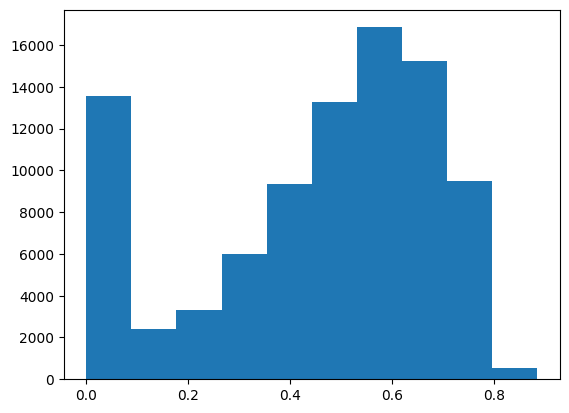

In [34]:
plt.hist(test_pred_total_mean)

In [35]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('CODE_recentgit_lgbmcat_cpu_mac_sunghyun+StandardScaler.csv', index=False)